# Drought Analysis using CHIRPS3.0

### SPI 

- Standard Precipitation Index is calculated using [CHIRPS 3.0](https://www.chc.ucsb.edu/data/chirps3) global monthly precipitation data. 

- The extracted global rainfall tiff images are clipped for Syria boundaries and processed into a single netCDF file which contains rainfall data with longitude, latitude and time dimensions. This data format enables us to easily analyze and plot trends over time with georeference information

- SPI indices are calculated using the netCDF data through climate-indices python package at time scales of 1,6 and 12 months respectively

- *This webbook shows drought characteristic trends using SPI indices calculated over 6 months duration.*

### Drought Characteristics using SPI indices

Drought characteristics were identified using calculated monthly SPI for the total period of 25 years (2000–2024). Drought is defined as the period in which SPI is continuously below a critical threshold (-1.2).

For each category, we identified and analysed the following four main drought characteristics: events (E), duration (D), inter-arrival time (T), magnitude (M), and severity (S = M/D).

- **Event [E]**: Month in which the SPI is less than a threshold.

- **Duration [D]**: the number of consecutive months in which the SPI is below the threshold.

- **Inter-arrival [T]**: the duration (month) between the initiation time of two successive drought events (regardless of the length) in the same drought category. It includes the drought and subsequent non-drought periods. Therefore, T characterizes the timing variability of drought events.

- **Magnitude [M]**: the absolute cumulative SPI value during drought events. Unitless. (On Le’s paper, Magnitude are called as Severity)

- **Severity [S]**: the number came from magnitude divided by duration to get level of severity. Unitless. (According to attached picture, many papers also mixed up between last two variables, magnitude and severity and also intensity)



### Drought Event
- A drought event is identified when the SPI value falls below -1.2. 

- If this condition is met, the value is set to 1; otherwise, it is set to 0. This operation is applied throughout the dataset accordingly.

- The updated dataset, now containing the drought event variable, is then stored as a new NetCDF file. 

- The Drought Event variable data is used to analyze trends of drought magnitude, duration and severity. 

In [5]:
import xarray as xr
import numpy as np

# Open the SPI dataset
ds_drought = xr.open_dataset("C:\\Users\\wb621815\\Documents\\mar_cli_chirps_spi_gamma_6_month.nc")
#ds_drought

# Define a drought event as an SPI value less than -1.2
ds_drought['drought_event'] = xr.where(ds_drought['spi'] < -1.2, 1, ds_drought['spi'] * 0)

# Transpose to the original dimensions
ds_drought = ds_drought.transpose('time', 'lat', 'lon')

# Save the new drought event variable to a new netCDF file
ds_drought.to_netcdf('C:\\Users\\wb621815\\Documents\\mar_cli_spi06_drought_event.nc')

print('Completed!')

Completed!


In [3]:
ds_drought

<xarray.Dataset> Size: 16MB
Dimensions:  (time: 300, lon: 136, lat: 101)
Coordinates:
  * lat      (lat) float32 404B 32.33 32.38 32.42 32.47 ... 37.22 37.28 37.33
  * lon      (lon) float32 544B 35.63 35.68 35.73 35.78 ... 42.28 42.33 42.38
  * time     (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2024-12-01
Data variables:
    spi      (time, lon, lat) float32 16MB ...

In [8]:
import xarray as xr
import numpy as np
import pandas as pd

# Open the SPI dataset
ds_drought = xr.open_dataset('C:\\Users\\wb621815\\Documents\\mar_cli_spi06_drought_event.nc')

# Transpose the dataset to respect original dimensions
ds_drought = ds_drought.transpose('time', 'lat', 'lon')

# Convert to a multi-indexed DataFrame
df_drought = ds_drought.to_dataframe()

# Reset the index to put 'lat' and 'lon' into columns
df_drought.reset_index(inplace=True)

# Handle missing values: if drought_event is NaN, fill with previous value
df_drought['drought_event'] = df_drought.groupby(['lat', 'lon'])['drought_event'].fillna(method='ffill')

# Get the drought_event column
drought_events = df_drought['drought_event']

# Function to compute interarrival times for a time series
def compute_interarrival_times(time_series):
    # For the first date, use the value from the drought event
    interarrival_time_series = pd.Series(np.full_like(time_series, np.nan), index=time_series.index)
    interarrival_time_series.iloc[0] = time_series.iloc[0]
    
    # Get the indices where time_series represents a drought event (where time_series is 1)
    event_indices = np.where(time_series == 1)[0]

    # Calculate the differences between successive events
    interarrival_times = np.diff(event_indices)

    # Assign the computed interarrival times to the indices following the start of each event
    # Skip the first event (because there's no previous event to measure an interarrival time from)
    interarrival_time_series.iloc[event_indices[1:]] = interarrival_times

    return interarrival_time_series

# Apply the function to each ('lat', 'lon') group
df_drought['interarrival_times'] = df_drought.groupby(['lat', 'lon'])['drought_event'].transform(compute_interarrival_times)

# Convert the DataFrame back to an xarray Dataset
ds_drought = df_drought.set_index(['time', 'lat', 'lon']).to_xarray()

# Save the new drought interarrival times variable to a new netCDF file
ds_drought.to_netcdf('C:\\Users\\wb621815\\Documents\\mar_cli_spi06_interarrival_times.nc')

# Close the original file
ds_drought.close()

print('Completed!')

C:\Users\wb621815\AppData\Local\Temp\ipykernel_10520\2666083590.py:18: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df_drought['drought_event'] = df_drought.groupby(['lat', 'lon'])['drought_event'].fillna(method='ffill')
C:\Users\wb621815\AppData\Local\Temp\ipykernel_10520\2666083590.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_drought['drought_event'] = df_drought.groupby(['lat', 'lon'])['drought_event'].fillna(method='ffill')


Completed!


In [6]:
ds_drought

<xarray.Dataset> Size: 33MB
Dimensions:        (time: 300, lon: 136, lat: 101)
Coordinates:
  * lat            (lat) float32 404B 32.33 32.38 32.42 ... 37.22 37.28 37.33
  * lon            (lon) float32 544B 35.63 35.68 35.73 ... 42.28 42.33 42.38
  * time           (time) datetime64[ns] 2kB 2000-01-01 ... 2024-12-01
Data variables:
    spi            (time, lat, lon) float32 16MB 0.0001608 ... 0.0001608
    drought_event  (time, lat, lon) float32 16MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [2]:
import xarray as xr
ds_drought_intra = xr.open_dataset("C:\\Users\\wb621815\\Documents\\mar_cli_spi06_interarrival_times.nc")
ds_drought_intra

<xarray.Dataset> Size: 49MB
Dimensions:             (time: 300, lat: 101, lon: 136)
Coordinates:
  * time                (time) datetime64[ns] 2kB 2000-01-01 ... 2024-12-01
  * lat                 (lat) float32 404B 32.33 32.38 32.42 ... 37.28 37.33
  * lon                 (lon) float32 544B 35.63 35.68 35.73 ... 42.33 42.38
Data variables:
    spi                 (time, lat, lon) float32 16MB ...
    drought_event       (time, lat, lon) float32 16MB ...
    interarrival_times  (time, lat, lon) float32 16MB ...

#### Drought Inter-arrival Times
The processed drought event dataset is then used to analyze the time intervals for drought occurences from 2000 to 2024. The difference between successive drought events over time is calculated as inter-arrival time and this method is applied to each location individually.The calculated time gaps are incorporated into the dataset as an additional variable, and the modified dataset is stored in a new NetCDF file

![drought_inter-arrival_times_data](../../docs/images/agriculture/drought_interarrival_times_data.png)

### Maximum Drought Magnitude
- The drought magnitude calculation involves filtering timesteps with active drought event followed by extracting the SPI index for that location and time step. 

- If a drought event is occurring at a given time step, the magnitude is determined by summing the absolute SPI value at that time with the previously recorded drought magnitude.

- This approach allows for a cumulative representation of drought severity over time. 

- If no drought event is present, the previously stored magnitude value remains unchanged.

- This process is applied independently across all spatial locations in the dataset for capturing localized drought conditions.

![Maximum_drought_magnitude.png](../../docs/images/agriculture/Max_drought_magnitude.png)

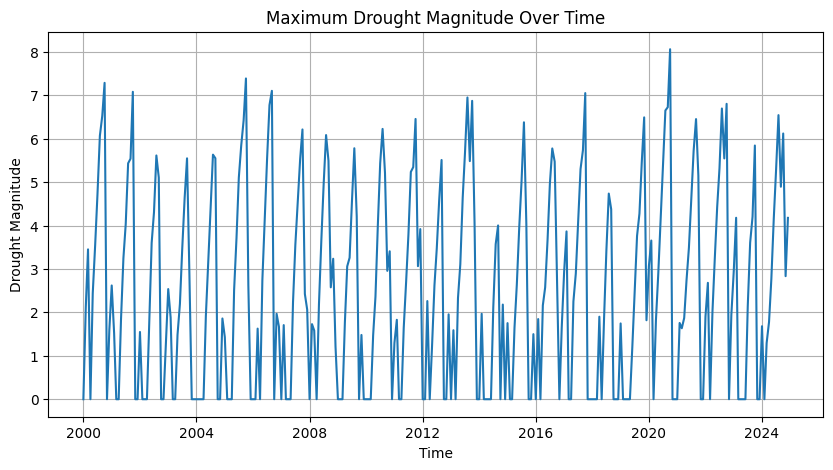

Completed!


In [11]:
import xarray as xr
import numpy as np
import os

# Open the drought event and spi data
ds_drought = xr.open_dataset('C:\\Users\\wb621815\\Documents\\mar_cli_spi06_interarrival_times.nc')

# Transpose the dataset to respect original dimensions
ds_drought = ds_drought.transpose('time', 'lat', 'lon')

# Preallocate an empty array for drought_magnitude and set all to NaN
drought_magnitude_arr = np.empty_like(ds_drought['drought_event'].values, dtype=float)
drought_magnitude_arr[:] = np.nan

# Find the first time step where not all spi_gamma_3_month values are NaN
start_time = next(i for i in range(len(ds_drought.time)) if not np.isnan(ds_drought['spi'].isel(time=i).values).all())

# Start from the determined time step
for i in range(start_time, len(ds_drought.time)):
    # For each point, check if it's a drought event
    drought_event = ds_drought['drought_event'].isel(time=i).values
    spi_value = ds_drought['spi'].isel(time=i).values
    prev_drought_magnitude = drought_magnitude_arr[i-1]

    # Calculate drought magnitude based on your conditions
    drought_magnitude_arr[i] = np.where(drought_event, abs(spi_value) + prev_drought_magnitude, 0)

# Assign the calculated values to the drought_magnitude in the dataset
ds_drought['drought_magnitude'] = (('time', 'lat', 'lon'), drought_magnitude_arr)

# Save the new drought magnitude variable to a new netCDF file
ds_drought.to_netcdf('C:\\Users\\wb621815\\Documents\\mar_cli_spi06_drought_magnitude.nc')

import matplotlib.pyplot as plt
# Plot maximum drought magnitude at each time step
plt.figure(figsize=(10, 5))
ds_drought['drought_magnitude'].max(dim=['lat', 'lon']).plot()
plt.title('Maximum Drought Magnitude Over Time')
plt.xlabel('Time')
plt.ylabel('Drought Magnitude')
plt.grid(True)
plt.show()

# Close the original file
ds_drought.close()

print('Completed!')

### Maximum Drought Duration
- Drought duration is set wherever a valid drought event is detected. 

- As the analysis progresses through subsequent time steps, each point is evaluated to determine if a drought event is occurring. 

- If a drought event is present, the duration is incremented from the previous time step, representing a continuous period of drought. 

- If no drought event is detected, the duration resets to zero. If the data is missing, the duration remains unchanged.

![Maximum_Drought_Duration](../../docs/images/agriculture/Max_drought_duration.png)

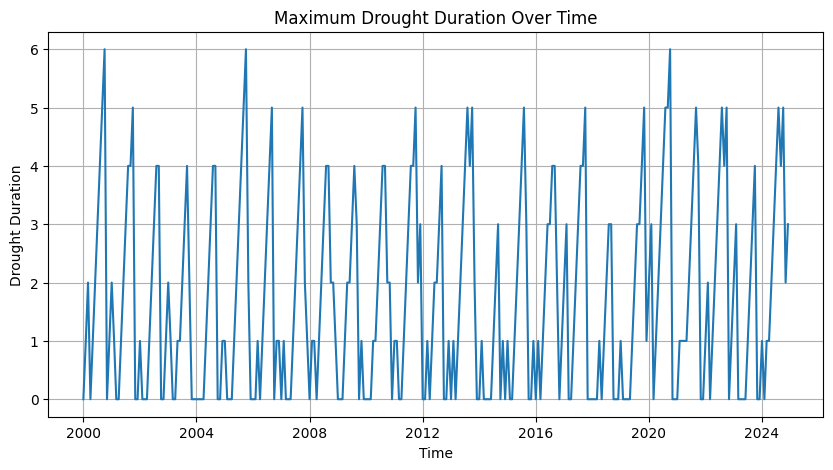

Completed!


In [13]:
import xarray as xr
import numpy as np
import os

# Open the drought event and spi data
ds_drought = xr.open_dataset('C:\\Users\\wb621815\\Documents\\mar_cli_spi06_drought_magnitude.nc')

# Transpose the dataset to respect original dimensions
ds_drought = ds_drought.transpose('time', 'lat', 'lon')

# Preallocate an empty array for drought_duration and set all to NaN
drought_duration_arr = np.empty_like(ds_drought['drought_event'].values, dtype=float)
drought_duration_arr[:] = np.nan

# Find the first time step where not all spi_gamma_12_month values are NaN
start_time = next(i for i in range(len(ds_drought.time)) if not np.isnan(ds_drought['spi'].isel(time=i).values).all())

# Start from the determined time step
for i in range(start_time, len(ds_drought.time)):
    # For each point, check if it's a drought event
    drought_event = ds_drought['drought_event'].isel(time=i).values
    prev_drought_duration = drought_duration_arr[i-1]

    # Calculate drought duration based on your conditions
    drought_duration_arr[i] = np.where(drought_event, 1 + prev_drought_duration, 0)

# Assign the calculated values to the drought_duration in the dataset
ds_drought['drought_duration'] = (('time', 'lat', 'lon'), drought_duration_arr)

# Save the new drought duration variable to a new netCDF file
ds_drought.to_netcdf('C:\\Users\\wb621815\\Documents\\mar_cli_spi06_drought_duration.nc')

import matplotlib.pyplot as plt
# Plot maximum drought duration at each time step
plt.figure(figsize=(10, 5))
ds_drought['drought_duration'].max(dim=['lat', 'lon']).plot()
plt.title('Maximum Drought Duration Over Time')
plt.xlabel('Time')
plt.ylabel('Drought Duration')
plt.grid(True)
plt.show()

# Close the original file
ds_drought.close()

print('Completed!')

### Drought Severity
- Drought severity is then calculated by identifying locations where both magnitude and duration have valid values. 

- The severity is determined as the ratio of drought magnitude to duration

![Drought_Severity.png](../../docs/images/agriculture/Mean_drought_severity.png)

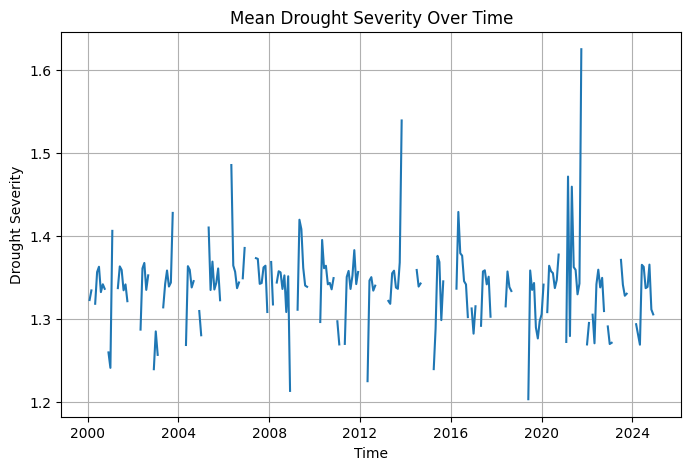

Completed!


In [15]:
import xarray as xr
import numpy as np
import os

# Open the drought event and spi data
ds_drought = xr.open_dataset('C:\\Users\\wb621815\\Documents\\mar_cli_spi06_drought_duration.nc')

# Transpose the dataset to have 'time', 'lat', 'lon' order
ds_drought = ds_drought.transpose('time', 'lat', 'lon')

# Compute the drought_severity
ds_drought['drought_severity'] = xr.full_like(ds_drought['drought_event'], np.nan)
drought_duration = ds_drought['drought_duration']
drought_magnitude = ds_drought['drought_magnitude']

# Compute mask for non-zero and finite values
is_finite_and_nonzero = (np.isfinite(drought_magnitude) & (drought_magnitude != 0) &
                         np.isfinite(drought_duration) & (drought_duration != 0))

ds_drought['drought_severity'].values = np.where(is_finite_and_nonzero, 
                                                 drought_magnitude / drought_duration, 
                                                 np.nan)

# Save the new drought duration variable to a new netCDF file
ds_drought.to_netcdf('C:\\Users\\wb621815\\Documents\\mar_cli_spi06_drought_severity.nc')

import matplotlib.pyplot as plt
# Plot mean drought severity at each time step
plt.figure(figsize=(8, 5))
ds_drought['drought_severity'].mean(dim=['lat', 'lon']).plot()
plt.title('Mean Drought Severity Over Time')
plt.xlabel('Time')
plt.ylabel('Drought Severity')
plt.grid(True)
plt.show()

# Close the original file
ds_drought.close()

print('Completed!')

### SPI Classification

In [14]:
import warnings
import xarray as xr
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

# Ignore warnings
warnings.filterwarnings('ignore')

# Load the point shapefile
gdf = gpd.read_file(r"C:\Users\wb621815\Documents\syria_grid_points.shp")

# Extract the x and y coordinates of each point in gdf and round them
gdf['x'] = gdf.geometry.x.round(2)
gdf['y'] = gdf.geometry.y.round(2)
gdf['geometry'] = gpd.points_from_xy(gdf['x'], gdf['y'])

# Open the netCDF file
ds = xr.open_dataset('C:\\Users\\wb621815\\Documents\\mar_cli_spi06_drought_severity.nc')

ds

<xarray.Dataset> Size: 148MB
Dimensions:             (time: 300, lat: 101, lon: 136)
Coordinates:
  * time                (time) datetime64[ns] 2kB 2000-01-01 ... 2024-12-01
  * lat                 (lat) float32 404B 32.33 32.38 32.42 ... 37.28 37.33
  * lon                 (lon) float32 544B 35.63 35.68 35.73 ... 42.33 42.38
Data variables:
    spi                 (time, lat, lon) float32 16MB ...
    drought_event       (time, lat, lon) float32 16MB ...
    interarrival_times  (time, lat, lon) float32 16MB ...
    drought_magnitude   (time, lat, lon) float64 33MB ...
    drought_duration    (time, lat, lon) float64 33MB ...
    drought_severity    (time, lat, lon) float64 33MB ...

In [15]:
# Define the classification bins and labels
bins = [-float('inf'), -2.00, -1.50, -1.20, -0.70, -0.50, 0.50, 0.70, 1.20, 1.50, 2.00, float('inf')]
labels = ['Exceptionally Dry', 'Extremely Dry', 'Severely Dry', 'Moderately Dry', 'Abnormally Dry', 'Near Normal', 
          'Abnormally Moist', 'Moderately Moist', 'Very Moist', 'Extremely Moist', 'Exceptionally Moist']


In [7]:
# Convert the DataArray for "spi_gamma_12_month" to a DataFrame
df = ds['spi'].to_dataframe().reset_index()

# Pivot the DataFrame to have dates as columns
df_pivot = df.pivot_table(index=["lon", "lat"], columns="time", values="spi").reset_index()

# Convert the time columns to yyyymmdd format
df_pivot.columns.name = None
df_pivot.columns = [str(col) if isinstance(col, str) else col.strftime('%Y%m%d') for col in df_pivot.columns]

# Classify "spi_gamma_12_month"
for column in df_pivot.columns:
    if column not in ['lon', 'lat']:
        df_pivot[column] = pd.cut(df_pivot[column], bins=bins, labels=labels)

# Convert the DataFrame to a GeoDataFrame, with Point geometries
gdf_pivot = gpd.GeoDataFrame(df_pivot, geometry=gpd.points_from_xy(df_pivot.lon, df_pivot.lat))

# Extract the x and y coordinates of each point in gdf_pivot and round them
gdf_pivot['x'] = gdf_pivot.geometry.x.round(2)
gdf_pivot['y'] = gdf_pivot.geometry.y.round(2)
gdf_pivot['geometry'] = gpd.points_from_xy(gdf_pivot['x'], gdf_pivot['y'])

# Set the CRS of the GeoDataFrame to match the shapefile
gdf_pivot.crs = "EPSG:4326"

# Spatial join between the points and the GeoDataFrame
gdf_joined = gpd.sjoin(gdf, gdf_pivot, predicate='intersects', how='inner')

# Drop unnecessary columns
gdf_joined = gdf_joined.drop(columns=['x_left', 'y_left', 'index_right', 'x_right', 'y_right'])

# Save the DataFrame to a CSV file
gdf_joined.to_csv(f'C:\\Users\\wb621815\\Documents\\mar_cli_spi06_classification.csv', index=False)

# Close the original file
ds.close()

print("CSV file has been created.")

CSV file has been created.


In [8]:
spi_class =  pd.read_csv(r"C:\Users\wb621815\Documents\mar_cli_spi06_classification.csv")
spi_class.head()

Empty DataFrame
Columns: [FID, geometry, lon, lat, 20000101, 20000201, 20000301, 20000401, 20000501, 20000601, 20000701, 20000801, 20000901, 20001001, 20001101, 20001201, 20010101, 20010201, 20010301, 20010401, 20010501, 20010601, 20010701, 20010801, 20010901, 20011001, 20011101, 20011201, 20020101, 20020201, 20020301, 20020401, 20020501, 20020601, 20020701, 20020801, 20020901, 20021001, 20021101, 20021201, 20030101, 20030201, 20030301, 20030401, 20030501, 20030601, 20030701, 20030801, 20030901, 20031001, 20031101, 20031201, 20040101, 20040201, 20040301, 20040401, 20040501, 20040601, 20040701, 20040801, 20040901, 20041001, 20041101, 20041201, 20050101, 20050201, 20050301, 20050401, 20050501, 20050601, 20050701, 20050801, 20050901, 20051001, 20051101, 20051201, 20060101, 20060201, 20060301, 20060401, 20060501, 20060601, 20060701, 20060801, 20060901, 20061001, 20061101, 20061201, 20070101, 20070201, 20070301, 20070401, 20070501, 20070601, 20070701, 20070801, 20070901, 20071001, 20071101, 20071201, ...]
Index: []

[0 rows x 304 columns]

In [11]:
gdf_pivot

lon        lat     20000101     20000201     20000301  \
0      35.625004  32.325001  Near Normal  Near Normal  Near Normal   
1      35.625004  32.375000  Near Normal  Near Normal  Near Normal   
2      35.625004  32.424999  Near Normal  Near Normal  Near Normal   
3      35.625004  32.474998  Near Normal  Near Normal  Near Normal   
4      35.625004  32.524998  Near Normal  Near Normal  Near Normal   
...          ...        ...          ...          ...          ...   
13731  42.375004  37.125000  Near Normal  Near Normal  Near Normal   
13732  42.375004  37.174999  Near Normal  Near Normal  Near Normal   
13733  42.375004  37.224998  Near Normal  Near Normal  Near Normal   
13734  42.375004  37.275002  Near Normal  Near Normal  Near Normal   
13735  42.375004  37.325001  Near Normal  Near Normal  Near Normal   

          20000401     20000501     20000601     20000701     20000801  ...  \
0      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
1      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
2      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
3      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
4      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
...            ...          ...          ...          ...          ...  ...   
13731  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13732  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13733  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13734  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13735  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   

          20240601     20240701     20240801     20240901     20241001  \
0      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
1      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
2      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
3      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
4      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
...            ...          ...          ...          ...          ...   
13731  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
13732  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
13733  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
13734  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
13735  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   

          20241101     20241201             geometry      x      y  
0      Near Normal  Near Normal  POINT (35.63 32.33)  35.63  32.33  
1      Near Normal  Near Normal  POINT (35.63 32.38)  35.63  32.38  
2      Near Normal  Near Normal  POINT (35.63 32.42)  35.63  32.42  
3      Near Normal  Near Normal  POINT (35.63 32.47)  35.63  32.47  
4      Near Normal  Near Normal  POINT (35.63 32.52)  35.63  32.52  
...            ...          ...                  ...    ...    ...  
13731  Near Normal  Near Normal  POINT (42.38 37.12)  42.38  37.12  
13732  Near Normal  Near Normal  POINT (42.38 37.17)  42.38  37.17  
13733  Near Normal  Near Normal  POINT (42.38 37.22)  42.38  37.22  
13734  Near Normal  Near Normal  POINT (42.38 37.28)  42.38  37.28  
13735  Near Normal  Near Normal  POINT (42.38 37.33)  42.38  37.33  

[13736 rows x 305 columns]

In [12]:
gdf_pivot.to_file(r"C:\Users\wb621815\Documents\mar_cli_spi06_classification.shp",driver = 'ESRI shapefile')

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import cartopy.feature as cfeature

# Open the dataset
ds_drought = xr.open_dataset("C:\\Users\\wb621815\\OneDrive - WBG\\Desktop\\DataLab\\SPI_anlaysis\\07_drought_variable\\mar_cli_spi06_drought_severity.nc")

# Resample to yearly frequency, summing over all months in each year
ds_yearly = ds_drought.resample(time='1Y').sum('time')

# Compute the average number of events per year, excluding NaN and zero values
num_events = ds_yearly['drought_event'].where(ds_yearly['drought_event'] > 0).mean(dim='time', skipna=True)

# Compute the other statistics
total_count = ds_drought['drought_event'].count(dim='time')
frequency = ds_drought['drought_event'].sum(dim='time') / total_count
max_magnitude = ds_drought['drought_magnitude'].max(dim='time', skipna=True)
max_duration = ds_drought['drought_duration'].max(dim='time', skipna=True)
mean_severity = ds_drought['drought_severity'].mean(dim='time', skipna=True)



In [5]:
# List of the computed statistics and their titles
statistics = [num_events, frequency, max_magnitude, max_duration, mean_severity]
titles = ["Average of Drought Event per Year", "Drought Frequency (Jan 2000 - Dec 2024)", 
          "Maximum of Drought Magnitude (Jan 2000 - Dec 2024)", "Maximum of Drought Duration (Jan 2000 - Dec 2024)", 
          "Mean of Drought Severity (Jan 2000 - Dec 2024)"]
colorbars = ["Events/Year", "Frequency", "Magnitude", "Duration (Month)", "Severity"]
cmaps = ['hot_r', 'hot_r', 'hot_r', 'hot_r', 'hot_r']

# Read the shapefile
shapefile = gpd.read_file("C:\\Users\\wb621815\\OneDrive - WBG\\Desktop\\DataLab\\SPI_anlaysis\\09_shapefiles\\syr_admin0.shp")



In [8]:
shapefile.bounds

minx       miny       maxx       maxy
0  35.613939  32.316442  42.385042  37.319139

In [14]:
import numpy as np

In [17]:
# Define a function to add administration boundaries with specific colors
def add_admin_boundaries(ax):
    # Loop through each row in the shapefile dataframe
    for index, row in shapefile.iterrows():
        if row['NAME_EN'] == "Syrian Arab Republic":
            facecolor = 'none'
        else:
            facecolor = 'gray'
        
        # Add the feature with the specified color
        ax.add_feature(cfeature.ShapelyFeature([row['geometry']], ccrs.PlateCarree(), edgecolor='black', facecolor=facecolor))



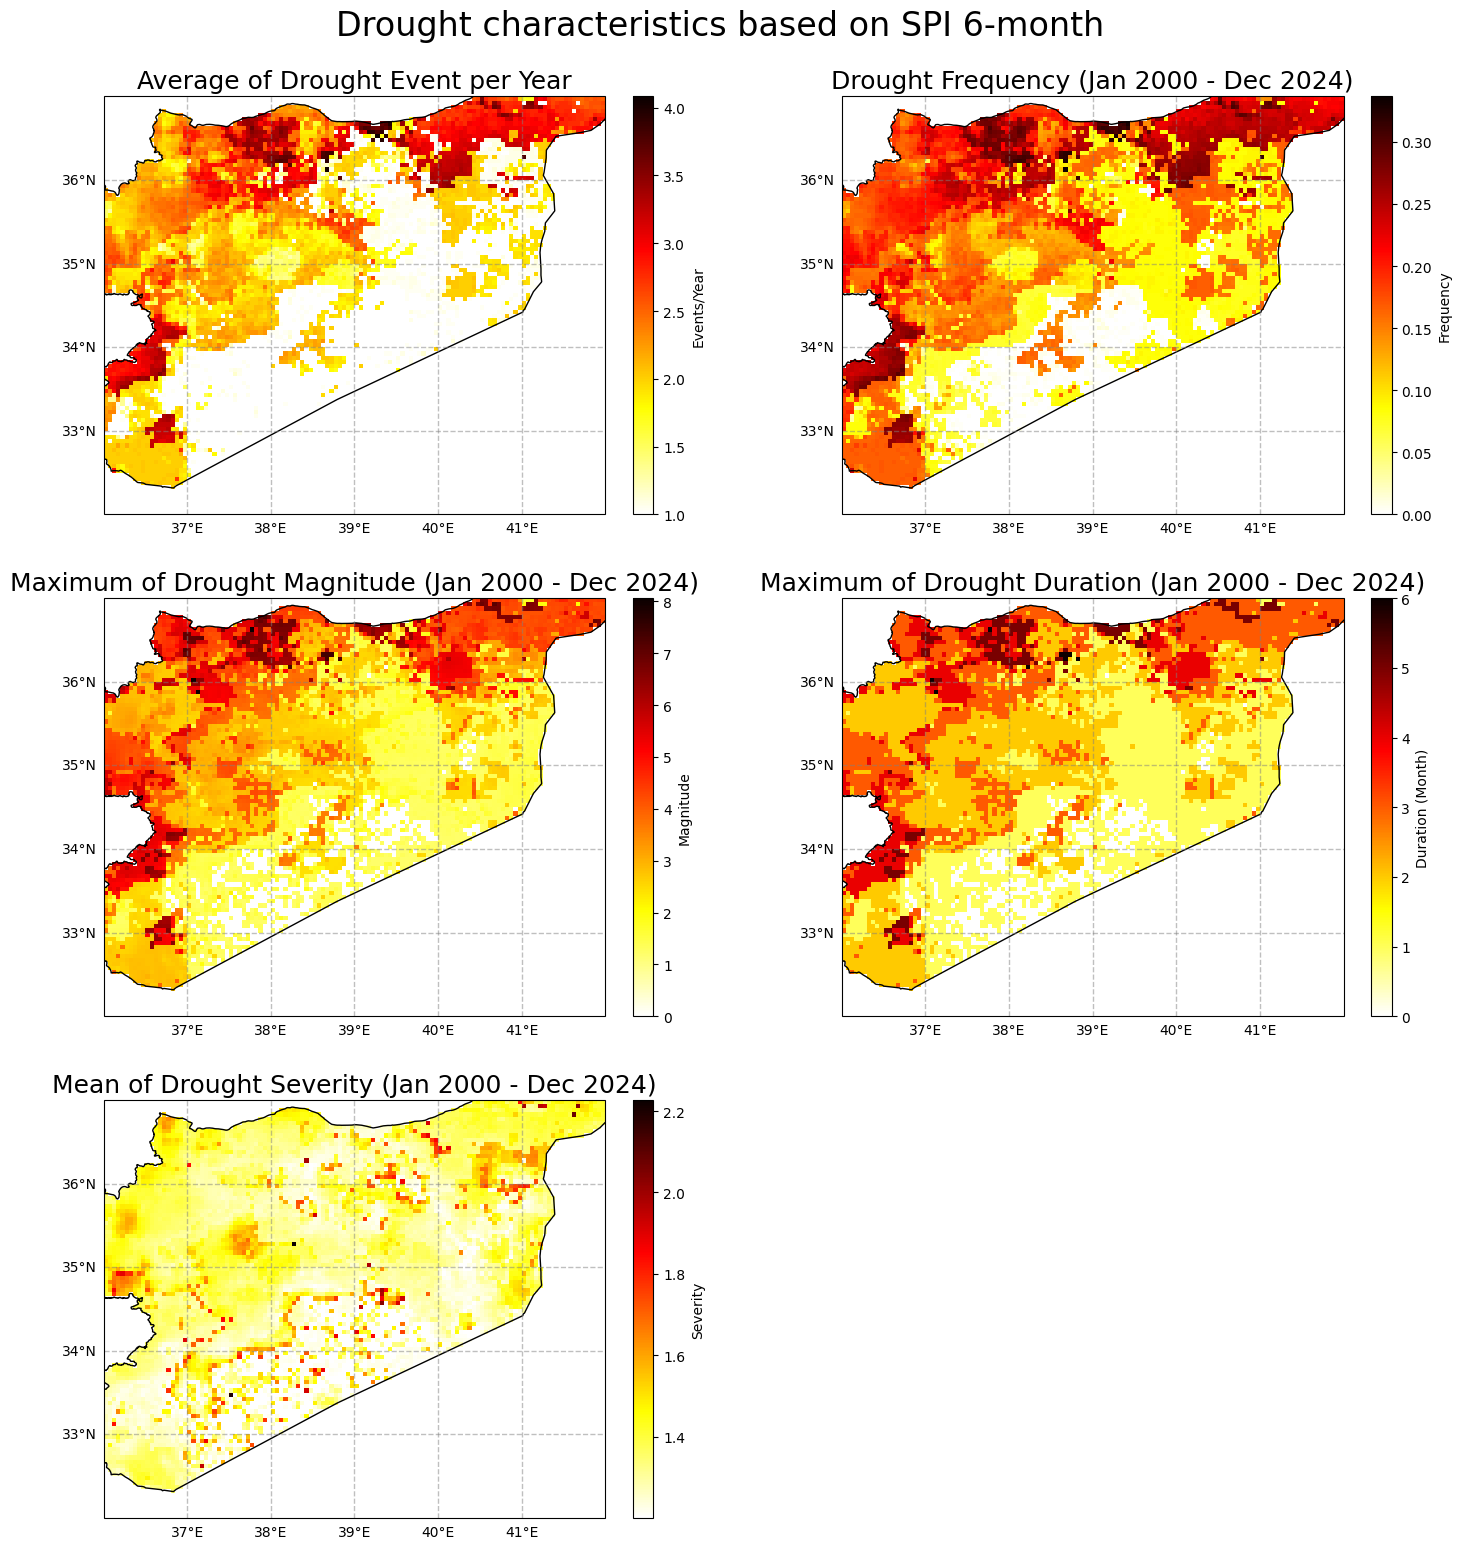

In [20]:
# Define the extent of your map for Morocco
lon_min, lon_max, lat_min, lat_max = 36, 42, 32, 37

# Create a figure with subplots arranged in 2 rows and 3 columns
fig, axs = plt.subplots(3, 2, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()  # Flatten the axes array for easy looping

# Set colorbar size
cbar_kwargs = {'fraction': 0.046, 'pad': 0.04}

#Loop over the subplots to create each map
for i, (ax, stat, title, cbar_title, cmap) in enumerate(zip(axs, statistics, titles, colorbars, cmaps)):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
    stat = stat.where(~np.isnan(stat))  # Add this line to mask NaN values
    im = stat.plot(ax=ax, cmap=cmap, add_colorbar=False, extend='both')  # Plot without colorbar first
    fig.colorbar(im, ax=ax, label=cbar_title, **cbar_kwargs)  # Then add colorbar with label
    ax.set_title(title, fontsize=18)  # Set title with increased font size
    add_admin_boundaries(ax)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

# Remove the last subplot if it's not used
if i < len(axs) - 1:
    fig.delaxes(axs[-1])

# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()

# Adjust the space between rows
plt.subplots_adjust(hspace=0.2)

# Add the main title and save the chart
fig.suptitle("Drought characteristics based on SPI 6-month", fontsize=24, y=1.03)
fig.savefig("C:\\Users\\wb621815\\Documents\\syria_spi_drought_images", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

# Close the original file
ds_drought.close()

In [16]:
import geopandas as gpd
gdf_pivot = gpd.read_file(r"C:\Users\wb621815\Documents\mar_cli_spi06_classification.shp")
gdf_pivot

lon        lat     20000101     20000201     20000301  \
0      35.625004  32.325001  Near Normal  Near Normal  Near Normal   
1      35.625004  32.375000  Near Normal  Near Normal  Near Normal   
2      35.625004  32.424999  Near Normal  Near Normal  Near Normal   
3      35.625004  32.474998  Near Normal  Near Normal  Near Normal   
4      35.625004  32.524998  Near Normal  Near Normal  Near Normal   
...          ...        ...          ...          ...          ...   
13731  42.375004  37.125000  Near Normal  Near Normal  Near Normal   
13732  42.375004  37.174999  Near Normal  Near Normal  Near Normal   
13733  42.375004  37.224998  Near Normal  Near Normal  Near Normal   
13734  42.375004  37.275002  Near Normal  Near Normal  Near Normal   
13735  42.375004  37.325001  Near Normal  Near Normal  Near Normal   

          20000401     20000501     20000601     20000701     20000801  ...  \
0      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
1      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
2      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
3      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
4      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
...            ...          ...          ...          ...          ...  ...   
13731  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13732  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13733  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13734  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13735  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   

          20240601     20240701     20240801     20240901     20241001  \
0      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
1      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
2      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
3      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
4      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
...            ...          ...          ...          ...          ...   
13731  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
13732  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
13733  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
13734  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   
13735  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal   

          20241101     20241201      x      y             geometry  
0      Near Normal  Near Normal  35.63  32.33  POINT (35.63 32.33)  
1      Near Normal  Near Normal  35.63  32.38  POINT (35.63 32.38)  
2      Near Normal  Near Normal  35.63  32.42  POINT (35.63 32.42)  
3      Near Normal  Near Normal  35.63  32.47  POINT (35.63 32.47)  
4      Near Normal  Near Normal  35.63  32.52  POINT (35.63 32.52)  
...            ...          ...    ...    ...                  ...  
13731  Near Normal  Near Normal  42.38  37.12  POINT (42.38 37.12)  
13732  Near Normal  Near Normal  42.38  37.17  POINT (42.38 37.17)  
13733  Near Normal  Near Normal  42.38  37.22  POINT (42.38 37.22)  
13734  Near Normal  Near Normal  42.38  37.28  POINT (42.38 37.28)  
13735  Near Normal  Near Normal  42.38  37.33  POINT (42.38 37.33)  

[13736 rows x 305 columns]

In [3]:
syr_adm1 = gpd.read_file(r"C:\Users\wb621815\OneDrive - WBG\Desktop\DataLab\SPI_anlaysis\09_shapefiles\syr-administrative-divisions-shapefiles\Shapefiles\syr_admbnda_adm1_uncs_unocha_20201217.shp")
syr_adm1

Shape_Leng  Shape_Area         ADM1_EN    ADM1_AR ADM1_PCODE ADM1_REF  \
0     7.896684    2.330266      Al-Hasakeh     الحسكة       SY08     None   
1     9.302662    1.993687          Aleppo        حلب       SY02     None   
2     7.030809    1.762222        Ar-Raqqa      الرقة       SY11     None   
3     3.511850    0.611739       As-Sweida   السويداء       SY13     None   
4     0.608190    0.011323        Damascus       دمشق       SY01     None   
5     3.822855    0.369290           Dar'a       درعا       SY12     Dara   
6     6.688064    2.487944     Deir-ez-Zor  دير الزور       SY09     None   
7     7.750905    1.098435            Hama       حماة       SY05     None   
8    11.843404    4.241915            Homs        حمص       SY04     None   
9     4.639533    0.539967           Idleb       إدلب       SY07     None   
10    2.606488    0.237480        Lattakia   اللاذقية       SY06     None   
11    2.143966    0.165849        Quneitra   القنيطرة       SY14     None   
12    9.864787    2.547691  Rural Damascus   ريف دمشق       SY03     None   
13    2.361167    0.184948         Tartous      طرطوس       SY10     None   

   ADM1ALT1EN ADM1ALT2EN ADM1ALT1AR ADM1ALT2AR               ADM0_EN  \
0        None       None       None       None  Syrian Arab Republic   
1        None       None       None       None  Syrian Arab Republic   
2        None       None       None       None  Syrian Arab Republic   
3        None       None       None       None  Syrian Arab Republic   
4        None       None       None       None  Syrian Arab Republic   
5        None       None       None       None  Syrian Arab Republic   
6        None       None       None       None  Syrian Arab Republic   
7        None       None       None       None  Syrian Arab Republic   
8        None       None       None       None  Syrian Arab Republic   
9        None       None       None       None  Syrian Arab Republic   
10       None       None       None       None  Syrian Arab Republic   
11       None       None       None       None  Syrian Arab Republic   
12       None       None       None       None  Syrian Arab Republic   
13       None       None       None       None  Syrian Arab Republic   

                      ADM0_AR ADM0_PCODE       date    validOn     validTo  \
0   الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
1   الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
2   الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
3   الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
4   الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
5   الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
6   الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
7   الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
8   الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
9   الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
10  الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
11  الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
12  الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
13  الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   

                                             geometry  
0   POLYGON ((42.22692 37.27664, 42.2271 37.27661,...  
1   POLYGON ((38.29637 36.90689, 38.3116 36.90575,...  
2   POLYGON ((38.79528 36.69788, 38.80076 36.69744...  
3   POLYGON ((36.88491 33.05645, 36.89817 33.05393...  
4   POLYGON ((36.32519 33.56409, 36.32534 33.56412...  
5   POLYGON ((36.56994 33.19104, 36.57234 33.1827,...  
6   POLYGON ((40.36438 35.93839, 40.37608 35.92403...  
7   POLYGON ((36.34093 35.74678, 36.34576 35.74273...  
8   POLYGON ((38.87133 35.37107, 39.13431 35.32397...  
9   POLYGON ((36.75562 36.32489, 36.

In [7]:
gdf_pivot_adm1 = gpd.sjoin(gdf_pivot,syr_adm1[['geometry','ADM1_EN']],predicate='within',how='left')
gdf_pivot_adm1

lon        lat     20000101     20000201     20000301  \
0      35.625004  32.325001  Near Normal  Near Normal  Near Normal   
1      35.625004  32.375000  Near Normal  Near Normal  Near Normal   
2      35.625004  32.424999  Near Normal  Near Normal  Near Normal   
3      35.625004  32.474998  Near Normal  Near Normal  Near Normal   
4      35.625004  32.524998  Near Normal  Near Normal  Near Normal   
...          ...        ...          ...          ...          ...   
13731  42.375004  37.125000  Near Normal  Near Normal  Near Normal   
13732  42.375004  37.174999  Near Normal  Near Normal  Near Normal   
13733  42.375004  37.224998  Near Normal  Near Normal  Near Normal   
13734  42.375004  37.275002  Near Normal  Near Normal  Near Normal   
13735  42.375004  37.325001  Near Normal  Near Normal  Near Normal   

          20000401     20000501     20000601     20000701     20000801  ...  \
0      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
1      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
2      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
3      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
4      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
...            ...          ...          ...          ...          ...  ...   
13731  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13732  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13733  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13734  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13735  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   

          20240801     20240901     20241001     20241101     20241201      x  \
0      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  35.63   
1      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  35.63   
2      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  35.63   
3      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  35.63   
4      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  35.63   
...            ...          ...          ...          ...          ...    ...   
13731  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  42.38   
13732  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  42.38   
13733  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  42.38   
13734  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  42.38   
13735  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  42.38   

           y             geometry index_right ADM1_EN  
0      32.33  POINT (35.63 32.33)         NaN     NaN  
1      32.38  POINT (35.63 32.38)         NaN     NaN  
2      32.42  POINT (35.63 32.42)         NaN     NaN  
3      32.47  POINT (35.63 32.47)         NaN     NaN  
4      32.52  POINT (35.63 32.52)         NaN     NaN  
...      ...                  ...         ...     ...  
13731  37.12  POINT (42.38 37.12)         NaN     NaN  
13732  37.17  POINT (42.38 37.17)         NaN     NaN  
13733  37.22  POINT (42.38 37.22)         NaN     NaN  
13734  37.28  POINT (42.38 37.28)         NaN     NaN  
13735  37.33  POINT (42.38 37.33)         NaN     NaN  

[13736 rows x 307 columns]

In [11]:
gdf_pivot['x'] = gdf_pivot.geometry.x.round(2)
gdf_pivot['y'] = gdf_pivot.geometry.y.round(2)
gdf_pivot['geometry'] = gpd.points_from_xy(gdf_pivot['x'], gdf_pivot['y'])

In [12]:
gdf_pivot.crs = "EPSG:4326"

In [12]:
gdf_joined = gpd.sjoin(gdf, gdf_pivot, predicate='intersects', how='inner')


In [14]:
print(gdf.crs)         # Check CRS of Syria grid points
print(gdf_pivot.crs)   # Check CRS of SPI classified points


EPSG:4326
EPSG:4326


In [15]:
gdf['x'] = gdf.geometry.x.round(4)  # Increase precision
gdf['y'] = gdf.geometry.y.round(4)
gdf_pivot['x'] = gdf_pivot.geometry.x.round(4)
gdf_pivot['y'] = gdf_pivot.geometry.y.round(4)

In [16]:
print(gdf.geom_type.unique())  # Should print ['Point']
print(gdf_pivot.geom_type.unique()) 

['Point']
['Point']


In [17]:
gdf_joined2 = gpd.sjoin_nearest(gdf, gdf_pivot, how='inner', distance_col='distance')
gdf_joined2

FID             geometry  x_left  y_left  index_right        lon  \
0        0  POINT (35.66 32.72)   35.66   32.72          109  35.675003   
1        1  POINT (35.66 32.77)   35.66   32.77          110  35.675003   
2        2  POINT (35.66 32.82)   35.66   32.82          111  35.675003   
3        3  POINT (35.66 32.87)   35.66   32.87          112  35.675003   
4        4  POINT (35.66 32.92)   35.66   32.92          113  35.675003   
...    ...                  ...     ...     ...          ...        ...   
7422  7422  POINT (42.31 37.07)   42.31   37.07        13629  42.325005   
7423  7423  POINT (42.31 37.12)   42.31   37.12        13630  42.325005   
7424  7424  POINT (42.31 37.17)   42.31   37.17        13631  42.325005   
7425  7425  POINT (42.31 37.22)   42.31   37.22        13632  42.325005   
7426  7426  POINT (42.36 37.07)   42.36   37.07        13730  42.375004   

            lat          20000101          20000201          20000301  ...  \
0     32.724998   Extremely Moist  Abnormally Moist  Moderately Moist  ...   
1     32.774998   Extremely Moist  Abnormally Moist  Moderately Moist  ...   
2     32.825001   Extremely Moist  Abnormally Moist  Moderately Moist  ...   
3     32.875000   Extremely Moist  Abnormally Moist  Moderately Moist  ...   
4     32.924999   Extremely Moist  Abnormally Moist  Moderately Moist  ...   
...         ...               ...               ...               ...  ...   
7422  37.075001  Moderately Moist    Moderately Dry  Moderately Moist  ...   
7423  37.125000  Moderately Moist    Abnormally Dry  Moderately Moist  ...   
7424  37.174999  Moderately Moist    Abnormally Dry  Moderately Moist  ...   
7425  37.224998  Moderately Moist       Near Normal  Moderately Moist  ...   
7426  37.075001  Moderately Moist    Abnormally Dry  Moderately Moist  ...   

            20240601      20240701       20240801        20240901  \
0     Moderately Dry  Severely Dry   Severely Dry  Moderately Dry   
1       Severely Dry  Severely Dry   Severely Dry  Moderately Dry   
2       Severely Dry  Severely Dry   Severely Dry  Moderately Dry   
3       Severely Dry  Severely Dry   Severely Dry  Moderately Dry   
4       Severely Dry  Severely Dry   Severely Dry  Moderately Dry   
...              ...           ...            ...             ...   
7422     Near Normal  Severely Dry  Extremely Dry  Abnormally Dry   
7423     Near Normal  Severely Dry  Extremely Dry  Abnormally Dry   
7424     Near Normal  Severely Dry  Extremely Dry  Abnormally Dry   
7425     Near Normal  Severely Dry  Extremely Dry     Near Normal   
7426     Near Normal  Severely Dry  Extremely Dry     Near Normal   

            20241001          20241101          20241201 x_right y_right  \
0        Near Normal       Near Normal        Very Moist   35.68   32.72   
1        Near Normal       Near Normal        Very Moist   35.68   32.77   
2        Near Normal       Near Normal        Very Moist   35.68   32.83   
3        Near Normal       Near Normal        Very Moist   35.68   32.88   
4        Near Normal       Near Normal   Extremely Moist   35.68   32.92   
...              ...               ...               ...     ...     ...   
7422  Moderately Dry       Near Normal  Abnormally Moist   42.33   37.08   
7423  Moderately Dry       Near Normal  Abnormally Moist   42.33   37.12   
7424  Moderately Dry       Near Normal  Abnormally Moist   42.33   37.17   
7425  Moderately Dry       Near Normal  Abnormally Moist   42.33   37.22   
7426  Moderately Dry  Abnormally Moist  Abnormally Moist   42.38   37.08   

      distance  
0     0.020000  
1     0.020000  
2     0.022361  
3     0.022361  
4     0.020000  
...        ...  
7422  0.022361  
7423  0.020000  
7424  0.020000  
7425  0.020000  
7426  0.022361  

[7427 rows x 310 columns]

In [19]:
gdf_joined3 = gpd.sjoin(gdf, gdf_pivot,predicate='intersects', how='inner')
gdf_joined3

Empty GeoDataFrame
Columns: [FID, geometry, x_left, y_left, index_right, lon, lat, 20000101, 20000201, 20000301, 20000401, 20000501, 20000601, 20000701, 20000801, 20000901, 20001001, 20001101, 20001201, 20010101, 20010201, 20010301, 20010401, 20010501, 20010601, 20010701, 20010801, 20010901, 20011001, 20011101, 20011201, 20020101, 20020201, 20020301, 20020401, 20020501, 20020601, 20020701, 20020801, 20020901, 20021001, 20021101, 20021201, 20030101, 20030201, 20030301, 20030401, 20030501, 20030601, 20030701, 20030801, 20030901, 20031001, 20031101, 20031201, 20040101, 20040201, 20040301, 20040401, 20040501, 20040601, 20040701, 20040801, 20040901, 20041001, 20041101, 20041201, 20050101, 20050201, 20050301, 20050401, 20050501, 20050601, 20050701, 20050801, 20050901, 20051001, 20051101, 20051201, 20060101, 20060201, 20060301, 20060401, 20060501, 20060601, 20060701, 20060801, 20060901, 20061001, 20061101, 20061201, 20070101, 20070201, 20070301, 20070401, 20070501, 20070601, 20070701, 20070801, 20070901, ...]
Index: []

[0 rows x 309 columns]

In [20]:
# Drop unnecessary columns
gdf_joined2 = gdf_joined2.drop(columns=['x_left', 'y_left', 'index_right', 'x_right', 'y_right'])

# Save the DataFrame to a CSV file
gdf_joined2.to_csv(f'C:\\Users\\wb621815\\Documents\\mar_cli_spi06_classification2.csv', index=False)

# Close the original file
ds.close()

print("CSV file has been created.")

CSV file has been created.


In [21]:
gdf_joined2

FID             geometry        lon        lat          20000101  \
0        0  POINT (35.66 32.72)  35.675003  32.724998   Extremely Moist   
1        1  POINT (35.66 32.77)  35.675003  32.774998   Extremely Moist   
2        2  POINT (35.66 32.82)  35.675003  32.825001   Extremely Moist   
3        3  POINT (35.66 32.87)  35.675003  32.875000   Extremely Moist   
4        4  POINT (35.66 32.92)  35.675003  32.924999   Extremely Moist   
...    ...                  ...        ...        ...               ...   
7422  7422  POINT (42.31 37.07)  42.325005  37.075001  Moderately Moist   
7423  7423  POINT (42.31 37.12)  42.325005  37.125000  Moderately Moist   
7424  7424  POINT (42.31 37.17)  42.325005  37.174999  Moderately Moist   
7425  7425  POINT (42.31 37.22)  42.325005  37.224998  Moderately Moist   
7426  7426  POINT (42.36 37.07)  42.375004  37.075001  Moderately Moist   

              20000201          20000301          20000401        20000501  \
0     Abnormally Moist  Moderately Moist       Near Normal  Moderately Dry   
1     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
2     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
3     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
4     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
...                ...               ...               ...             ...   
7422    Moderately Dry  Moderately Moist  Moderately Moist     Near Normal   
7423    Abnormally Dry  Moderately Moist  Moderately Moist     Near Normal   
7424    Abnormally Dry  Moderately Moist  Moderately Moist     Near Normal   
7425       Near Normal  Moderately Moist  Moderately Moist     Near Normal   
7426    Abnormally Dry  Moderately Moist  Moderately Moist     Near Normal   

            20000601  ...          20240401          20240501        20240601  \
0     Moderately Dry  ...       Near Normal       Near Normal  Moderately Dry   
1       Severely Dry  ...       Near Normal       Near Normal    Severely Dry   
2       Severely Dry  ...       Near Normal    Abnormally Dry    Severely Dry   
3       Severely Dry  ...       Near Normal    Abnormally Dry    Severely Dry   
4       Severely Dry  ...       Near Normal    Abnormally Dry    Severely Dry   
...              ...  ...               ...               ...             ...   
7422    Severely Dry  ...  Abnormally Moist  Moderately Moist     Near Normal   
7423    Severely Dry  ...  Abnormally Moist  Moderately Moist     Near Normal   
7424    Severely Dry  ...  Abnormally Moist  Moderately Moist     Near Normal   
7425    Severely Dry  ...       Near Normal  Abnormally Moist     Near Normal   
7426    Severely Dry  ...  Abnormally Moist  Moderately Moist     Near Normal   

          20240701       20240801        20240901        20241001  \
0     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
1     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
2     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
3     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
4     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
...            ...            ...             ...             ...   
7422  Severely Dry  Extremely Dry  Abnormally Dry  Moderately Dry   
7423  Severely Dry  Extremely Dry  Abnormally Dry  Moderately Dry   
7424  Severely Dry  Extremely Dry  Abnormally Dry  Moderately Dry   
7425  Severely Dry  Extremely Dry     Near Normal  Moderately Dry   
7426  Severely Dry  Extremely Dry     Near Normal  Moderately Dry   

              20241101          20241201  distance  
0          Near Normal        Very Moist  0.020000  
1          Near Normal        Very Moist  0.020000  
2          Near Normal        Very Moist  0.022361  
3          Near Normal        Very Moist  0.022361  
4          Near Normal   Extremely Moist  0.020000  
...                ...               ...       ..

In [22]:
print(gdf_joined2.crs)  # Check grid points CRS
print(syr_adm1.crs)

EPSG:4326
EPSG:4326


In [25]:
gdf_joined2 = gdf_joined2.drop(columns=['FID'])

In [41]:
gdf_with_admin1 = gpd.sjoin(gdf_joined2, syr_adm1[['geometry', 'ADM1_EN']], how="left", predicate="intersects")

# Drop unnecessary columns
gdf_with_admin1 = gdf_with_admin1.drop(columns=["index_right"])

gdf_with_admin1

geometry        lon        lat          20000101  \
0     POINT (35.66 32.72)  35.675003  32.724998   Extremely Moist   
1     POINT (35.66 32.77)  35.675003  32.774998   Extremely Moist   
2     POINT (35.66 32.82)  35.675003  32.825001   Extremely Moist   
3     POINT (35.66 32.87)  35.675003  32.875000   Extremely Moist   
4     POINT (35.66 32.92)  35.675003  32.924999   Extremely Moist   
...                   ...        ...        ...               ...   
7422  POINT (42.31 37.07)  42.325005  37.075001  Moderately Moist   
7423  POINT (42.31 37.12)  42.325005  37.125000  Moderately Moist   
7424  POINT (42.31 37.17)  42.325005  37.174999  Moderately Moist   
7425  POINT (42.31 37.22)  42.325005  37.224998  Moderately Moist   
7426  POINT (42.36 37.07)  42.375004  37.075001  Moderately Moist   

              20000201          20000301          20000401        20000501  \
0     Abnormally Moist  Moderately Moist       Near Normal  Moderately Dry   
1     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
2     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
3     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
4     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
...                ...               ...               ...             ...   
7422    Moderately Dry  Moderately Moist  Moderately Moist     Near Normal   
7423    Abnormally Dry  Moderately Moist  Moderately Moist     Near Normal   
7424    Abnormally Dry  Moderately Moist  Moderately Moist     Near Normal   
7425       Near Normal  Moderately Moist  Moderately Moist     Near Normal   
7426    Abnormally Dry  Moderately Moist  Moderately Moist     Near Normal   

            20000601      20000701  ...          20240501        20240601  \
0     Moderately Dry  Severely Dry  ...       Near Normal  Moderately Dry   
1       Severely Dry  Severely Dry  ...       Near Normal    Severely Dry   
2       Severely Dry  Severely Dry  ...    Abnormally Dry    Severely Dry   
3       Severely Dry  Severely Dry  ...    Abnormally Dry    Severely Dry   
4       Severely Dry  Severely Dry  ...    Abnormally Dry    Severely Dry   
...              ...           ...  ...               ...             ...   
7422    Severely Dry  Severely Dry  ...  Moderately Moist     Near Normal   
7423    Severely Dry  Severely Dry  ...  Moderately Moist     Near Normal   
7424    Severely Dry  Severely Dry  ...  Moderately Moist     Near Normal   
7425    Severely Dry  Severely Dry  ...  Abnormally Moist     Near Normal   
7426    Severely Dry  Severely Dry  ...  Moderately Moist     Near Normal   

          20240701       20240801        20240901        20241001  \
0     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
1     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
2     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
3     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
4     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
...            ...            ...             ...             ...   
7422  Severely Dry  Extremely Dry  Abnormally Dry  Moderately Dry   
7423  Severely Dry  Extremely Dry  Abnormally Dry  Moderately Dry   
7424  Severely Dry  Extremely Dry  Abnormally Dry  Moderately Dry   
7425  Severely Dry  Extremely Dry     Near Normal  Moderately Dry   
7426  Severely Dry  Extremely Dry     Near Normal  Moderately Dry   

              20241101          20241201  distance     ADM1_EN  
0          Near Normal        Very Moist  0.020000    Quneitra  
1          Near Normal        Very Moist  0.020000         NaN  
2          Near Normal        Very Moist  0.022361    Quneitra  
3          Near Normal        Very Moist  0.022361    Quneitra  
4          Near Normal   Extremely Moist  0.020000    Quneitra  
...                ...               ...       ...         ...  
7422       Near Normal  Abnormally Moist  

In [28]:
# Count occurrences of each classification per Admin 1 region
agg_data = gdf_with_admin1.groupby("ADM1_EN").apply(lambda x: x.value_counts().index[0]).reset_index()
agg_data

ADM1_EN                                                  0
0       Al-Hasakeh  (POINT (41.36 35.72), 41.375004, 35.725, Moder...
1           Aleppo  (POINT (38.16 35.77), 38.175003, 35.775, Very ...
2         Ar-Raqqa  (POINT (39.56 35.67), 39.575005, 35.675, Excep...
3        As-Sweida  (POINT (36.51 32.37), 36.525, 32.375, Abnormal...
4         Damascus  (POINT (36.21 33.47), 36.225002, 33.475, Near ...
5            Dar'a  (POINT (36.11 32.57), 36.125004, 32.575, Extre...
6      Deir-ez-Zor  (POINT (41.11 34.62), 41.125004, 34.625, Near ...
7             Hama  (POINT (38.31 35.07), 38.325005, 35.075, Extre...
8             Homs  (POINT (40.11 34.02), 40.125004, 34.024998, Ne...
9            Idleb  (POINT (36.41 35.62), 36.425003, 35.625, Extre...
10        Lattakia  (POINT (35.96 35.32), 35.975002, 35.325, Extre...
11        Quneitra  (POINT (35.66 32.72), 35.675003, 32.725, Extre...
12  Rural Damascus  (POINT (37.51 32.72), 37.525, 32.725, Moderate...
13         Tartous  (POINT (35.96 34.72), 35.975002, 34.725, Extre...

In [ ]:
agg_data.shape

(14, 2)

In [42]:
# Convert column names to string and extract year part
gdf_with_admin1.columns = gdf_with_admin1.columns.astype(str)
yearly_columns = [col for col in gdf_with_admin1.columns if col.isdigit()]  # Identify SPI columns
year_mapping = {col: col[:4] for col in yearly_columns}  # Map to year


In [43]:
gdf_with_admin1 = gdf_with_admin1.rename(columns=year_mapping)

In [44]:
gdf_with_admin1

geometry        lon        lat              2000  \
0     POINT (35.66 32.72)  35.675003  32.724998   Extremely Moist   
1     POINT (35.66 32.77)  35.675003  32.774998   Extremely Moist   
2     POINT (35.66 32.82)  35.675003  32.825001   Extremely Moist   
3     POINT (35.66 32.87)  35.675003  32.875000   Extremely Moist   
4     POINT (35.66 32.92)  35.675003  32.924999   Extremely Moist   
...                   ...        ...        ...               ...   
7422  POINT (42.31 37.07)  42.325005  37.075001  Moderately Moist   
7423  POINT (42.31 37.12)  42.325005  37.125000  Moderately Moist   
7424  POINT (42.31 37.17)  42.325005  37.174999  Moderately Moist   
7425  POINT (42.31 37.22)  42.325005  37.224998  Moderately Moist   
7426  POINT (42.36 37.07)  42.375004  37.075001  Moderately Moist   

                  2000              2000              2000            2000  \
0     Abnormally Moist  Moderately Moist       Near Normal  Moderately Dry   
1     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
2     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
3     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
4     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
...                ...               ...               ...             ...   
7422    Moderately Dry  Moderately Moist  Moderately Moist     Near Normal   
7423    Abnormally Dry  Moderately Moist  Moderately Moist     Near Normal   
7424    Abnormally Dry  Moderately Moist  Moderately Moist     Near Normal   
7425       Near Normal  Moderately Moist  Moderately Moist     Near Normal   
7426    Abnormally Dry  Moderately Moist  Moderately Moist     Near Normal   

                2000          2000  ...              2024            2024  \
0     Moderately Dry  Severely Dry  ...       Near Normal  Moderately Dry   
1       Severely Dry  Severely Dry  ...       Near Normal    Severely Dry   
2       Severely Dry  Severely Dry  ...    Abnormally Dry    Severely Dry   
3       Severely Dry  Severely Dry  ...    Abnormally Dry    Severely Dry   
4       Severely Dry  Severely Dry  ...    Abnormally Dry    Severely Dry   
...              ...           ...  ...               ...             ...   
7422    Severely Dry  Severely Dry  ...  Moderately Moist     Near Normal   
7423    Severely Dry  Severely Dry  ...  Moderately Moist     Near Normal   
7424    Severely Dry  Severely Dry  ...  Moderately Moist     Near Normal   
7425    Severely Dry  Severely Dry  ...  Abnormally Moist     Near Normal   
7426    Severely Dry  Severely Dry  ...  Moderately Moist     Near Normal   

              2024           2024            2024            2024  \
0     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
1     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
2     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
3     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
4     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
...            ...            ...             ...             ...   
7422  Severely Dry  Extremely Dry  Abnormally Dry  Moderately Dry   
7423  Severely Dry  Extremely Dry  Abnormally Dry  Moderately Dry   
7424  Severely Dry  Extremely Dry  Abnormally Dry  Moderately Dry   
7425  Severely Dry  Extremely Dry     Near Normal  Moderately Dry   
7426  Severely Dry  Extremely Dry     Near Normal  Moderately Dry   

                  2024              2024  distance     ADM1_EN  
0          Near Normal        Very Moist  0.020000    Quneitra  
1          Near Normal        Very Moist  0.020000         NaN  
2          Near Normal        Very Moist  0.022361    Quneitra  
3          Near Normal        Very Moist  0.022361    Quneitra  
4          Near Normal   Extremely Moist  0.020000    Quneitra  
...                ...               ...       ...         ...  
7422       Near Normal  Abnormally Moist  

In [32]:
# Perform aggregation: Get most frequent classification per year for each region
agg_yearly = gdf_with_admin1.groupby("ADM1_EN")[list(year_mapping.values())].agg(lambda x: x.mode()[0]).reset_index()

In [33]:
agg_yearly

ADM1_EN              2000              2000              2000  \
0       Al-Hasakeh  Moderately Moist       Near Normal  Moderately Moist   
1           Aleppo        Very Moist       Near Normal      Severely Dry   
2         Ar-Raqqa        Very Moist       Near Normal       Near Normal   
3        As-Sweida   Extremely Moist       Near Normal  Moderately Moist   
4         Damascus       Near Normal       Near Normal  Moderately Moist   
5            Dar'a   Extremely Moist       Near Normal  Moderately Moist   
6      Deir-ez-Zor       Near Normal    Moderately Dry  Moderately Moist   
7             Hama   Extremely Moist      Severely Dry       Near Normal   
8             Homs       Near Normal    Moderately Dry  Moderately Moist   
9            Idleb   Extremely Moist    Moderately Dry       Near Normal   
10        Lattakia   Extremely Moist       Near Normal       Near Normal   
11        Quneitra   Extremely Moist  Abnormally Moist  Moderately Moist   
12  Rural Damascus  Moderately Moist    Moderately Dry  Moderately Moist   
13         Tartous   Extremely Moist       Near Normal       Near Normal   

                2000            2000            2000            2000  \
0   Moderately Moist     Near Normal    Severely Dry   Extremely Dry   
1   Moderately Moist     Near Normal    Severely Dry    Severely Dry   
2   Moderately Moist  Moderately Dry  Moderately Dry  Moderately Dry   
3        Near Normal  Moderately Dry  Moderately Dry    Severely Dry   
4        Near Normal  Moderately Dry  Moderately Dry    Severely Dry   
5        Near Normal  Moderately Dry  Moderately Dry    Severely Dry   
6   Moderately Moist  Moderately Dry  Moderately Dry  Moderately Dry   
7   Moderately Moist    Severely Dry    Severely Dry  Moderately Dry   
8   Moderately Moist  Moderately Dry    Severely Dry  Moderately Dry   
9   Moderately Moist  Moderately Dry  Moderately Dry    Severely Dry   
10       Near Normal  Moderately Dry    Severely Dry    Severely Dry   
11       Near Normal  Moderately Dry    Severely Dry    Severely Dry   
12       Near Normal  Moderately Dry  Moderately Dry  Moderately Dry   
13       Near Normal  Moderately Dry    Severely Dry   Extremely Dry   

              2000            2000  ...              2024              2024  \
0     Severely Dry  Moderately Dry  ...   Extremely Moist       Near Normal   
1   Moderately Dry     Near Normal  ...  Abnormally Moist       Near Normal   
2     Severely Dry  Moderately Dry  ...  Moderately Moist       Near Normal   
3     Severely Dry  Moderately Dry  ...  Abnormally Moist       Near Normal   
4     Severely Dry  Abnormally Dry  ...       Near Normal  Abnormally Moist   
5     Severely Dry  Moderately Dry  ...  Abnormally Moist       Near Normal   
6     Severely Dry  Moderately Dry  ...   Extremely Moist    Moderately Dry   
7   Moderately Dry  Moderately Dry  ...  Moderately Moist       Near Normal   
8   Moderately Dry  Moderately Dry  ...   Extremely Moist       Near Normal   
9   Moderately Dry  Moderately Dry  ...  Moderately Moist       Near Normal   
10  Moderately Dry     Near Normal  ...  Moderately Moist       Near Normal   
11    Severely Dry  Moderately Dry  ...       Near Normal       Near Normal   
12  Moderately Dry  Moderately Dry  ...       Near Normal       Near Normal   
13  Moderately Dry     Near Normal  ...  Moderately Moist       Near Normal   

           2024            2024            2024            2024  \
0   Near Normal  Moderately Dry   Extremely Dry    Severely Dry   
1   Near Normal     Near Normal    Severely Dry    Severely Dry   
2   Near Normal     Near Normal  Moderately Dry    Severely Dry   
3   Near Normal  Moderately Dry    Severely Dry    Severely Dry   
4   Near Normal  Moderately Dry    Severely Dry    Severely Dry   
5   Near Normal  Moderately Dry    Severely Dry    Severely Dry   
6   Near Normal  Moderately Dry  Moderately Dry    Severely Dry   
7   Near Normal  Moderately Dry  Moderately Dry  Moderately Dry   


In [45]:
# Exclude the first column ("ADM1_EN") and compute the mode across all years
agg_mode = agg_yearly.set_index("ADM1_EN").mode(axis=1)

# Ensure we only keep the first mode (in case of multiple modes)
agg_mode = agg_mode.iloc[:, 0].reset_index()

# Rename column for clarity
agg_mode.columns = ["ADM1_EN", "Most_Frequent_SPI"]


In [46]:
agg_mode

ADM1_EN Most_Frequent_SPI
0       Al-Hasakeh       Near Normal
1           Aleppo       Near Normal
2         Ar-Raqqa    Moderately Dry
3        As-Sweida  Moderately Moist
4         Damascus       Near Normal
5            Dar'a    Moderately Dry
6      Deir-ez-Zor    Moderately Dry
7             Hama       Near Normal
8             Homs    Moderately Dry
9            Idleb       Near Normal
10        Lattakia       Near Normal
11        Quneitra       Near Normal
12  Rural Damascus    Moderately Dry
13         Tartous       Near Normal

In [47]:
# Group by Admin 1 region and take mode across each year's columns
agg_mode_per_year = agg_yearly.set_index("ADM1_EN").apply(lambda x: x.mode()[0], axis=1).reset_index()
agg_mode_per_year.columns = ["ADM1_EN"] + [f"Mode_{col}" for col in agg_mode_per_year.columns[1:]]
agg_mode_per_year

ADM1_EN            Mode_0
0       Al-Hasakeh       Near Normal
1           Aleppo       Near Normal
2         Ar-Raqqa    Moderately Dry
3        As-Sweida  Moderately Moist
4         Damascus       Near Normal
5            Dar'a    Moderately Dry
6      Deir-ez-Zor    Moderately Dry
7             Hama       Near Normal
8             Homs    Moderately Dry
9            Idleb       Near Normal
10        Lattakia       Near Normal
11        Quneitra       Near Normal
12  Rural Damascus    Moderately Dry
13         Tartous       Near Normal

In [48]:
# Group by Admin 1 region and apply mode for each year
agg_mode_per_year = agg_yearly.groupby("ADM1_EN").agg(lambda x: x.mode()[0]).reset_index()
agg_mode_per_year

ADM1_EN              2000              2000              2000  \
0       Al-Hasakeh  Moderately Moist       Near Normal  Moderately Moist   
1           Aleppo        Very Moist       Near Normal      Severely Dry   
2         Ar-Raqqa        Very Moist       Near Normal       Near Normal   
3        As-Sweida   Extremely Moist       Near Normal  Moderately Moist   
4         Damascus       Near Normal       Near Normal  Moderately Moist   
5            Dar'a   Extremely Moist       Near Normal  Moderately Moist   
6      Deir-ez-Zor       Near Normal    Moderately Dry  Moderately Moist   
7             Hama   Extremely Moist      Severely Dry       Near Normal   
8             Homs       Near Normal    Moderately Dry  Moderately Moist   
9            Idleb   Extremely Moist    Moderately Dry       Near Normal   
10        Lattakia   Extremely Moist       Near Normal       Near Normal   
11        Quneitra   Extremely Moist  Abnormally Moist  Moderately Moist   
12  Rural Damascus  Moderately Moist    Moderately Dry  Moderately Moist   
13         Tartous   Extremely Moist       Near Normal       Near Normal   

                2000            2000            2000            2000  \
0   Moderately Moist     Near Normal    Severely Dry   Extremely Dry   
1   Moderately Moist     Near Normal    Severely Dry    Severely Dry   
2   Moderately Moist  Moderately Dry  Moderately Dry  Moderately Dry   
3        Near Normal  Moderately Dry  Moderately Dry    Severely Dry   
4        Near Normal  Moderately Dry  Moderately Dry    Severely Dry   
5        Near Normal  Moderately Dry  Moderately Dry    Severely Dry   
6   Moderately Moist  Moderately Dry  Moderately Dry  Moderately Dry   
7   Moderately Moist    Severely Dry    Severely Dry  Moderately Dry   
8   Moderately Moist  Moderately Dry    Severely Dry  Moderately Dry   
9   Moderately Moist  Moderately Dry  Moderately Dry    Severely Dry   
10       Near Normal  Moderately Dry    Severely Dry    Severely Dry   
11       Near Normal  Moderately Dry    Severely Dry    Severely Dry   
12       Near Normal  Moderately Dry  Moderately Dry  Moderately Dry   
13       Near Normal  Moderately Dry    Severely Dry   Extremely Dry   

              2000            2000  ...              2024              2024  \
0     Severely Dry  Moderately Dry  ...   Extremely Moist       Near Normal   
1   Moderately Dry     Near Normal  ...  Abnormally Moist       Near Normal   
2     Severely Dry  Moderately Dry  ...  Moderately Moist       Near Normal   
3     Severely Dry  Moderately Dry  ...  Abnormally Moist       Near Normal   
4     Severely Dry  Abnormally Dry  ...       Near Normal  Abnormally Moist   
5     Severely Dry  Moderately Dry  ...  Abnormally Moist       Near Normal   
6     Severely Dry  Moderately Dry  ...   Extremely Moist    Moderately Dry   
7   Moderately Dry  Moderately Dry  ...  Moderately Moist       Near Normal   
8   Moderately Dry  Moderately Dry  ...   Extremely Moist       Near Normal   
9   Moderately Dry  Moderately Dry  ...  Moderately Moist       Near Normal   
10  Moderately Dry     Near Normal  ...  Moderately Moist       Near Normal   
11    Severely Dry  Moderately Dry  ...       Near Normal       Near Normal   
12  Moderately Dry  Moderately Dry  ...       Near Normal       Near Normal   
13  Moderately Dry     Near Normal  ...  Moderately Moist       Near Normal   

           2024            2024            2024            2024  \
0   Near Normal  Moderately Dry   Extremely Dry    Severely Dry   
1   Near Normal     Near Normal    Severely Dry    Severely Dry   
2   Near Normal     Near Normal  Moderately Dry    Severely Dry   
3   Near Normal  Moderately Dry    Severely Dry    Severely Dry   
4   Near Normal  Moderately Dry    Severely Dry    Severely Dry   
5   Near Normal  Moderately Dry    Severely Dry    Severely Dry   
6   Near Normal  Moderately Dry  Moderately Dry    Severely Dry   
7   Near Normal  Moderately Dry  Moderately Dry  Moderately Dry   


In [49]:
agg_mode_per_year_long = agg_mode_per_year.melt(id_vars=["ADM1_EN"], var_name="Year", value_name="Most_Frequent_SPI")
agg_mode_per_year_long

ADM1_EN  Year Most_Frequent_SPI
0          Al-Hasakeh  2000  Moderately Moist
1              Aleppo  2000        Very Moist
2            Ar-Raqqa  2000        Very Moist
3           As-Sweida  2000   Extremely Moist
4            Damascus  2000       Near Normal
...               ...   ...               ...
50395           Idleb  2024  Moderately Moist
50396        Lattakia  2024        Very Moist
50397        Quneitra  2024        Very Moist
50398  Rural Damascus  2024  Moderately Moist
50399         Tartous  2024   Extremely Moist

[50400 rows x 3 columns]

In [50]:
admin1_gdf = syr_adm1.merge(agg_mode_per_year_long, on="ADM1_EN", how="left")


In [51]:
admin1_gdf

Shape_Leng  Shape_Area     ADM1_EN ADM1_AR ADM1_PCODE ADM1_REF  \
0        7.896684    2.330266  Al-Hasakeh  الحسكة       SY08     None   
1        7.896684    2.330266  Al-Hasakeh  الحسكة       SY08     None   
2        7.896684    2.330266  Al-Hasakeh  الحسكة       SY08     None   
3        7.896684    2.330266  Al-Hasakeh  الحسكة       SY08     None   
4        7.896684    2.330266  Al-Hasakeh  الحسكة       SY08     None   
...           ...         ...         ...     ...        ...      ...   
50395    2.361167    0.184948     Tartous   طرطوس       SY10     None   
50396    2.361167    0.184948     Tartous   طرطوس       SY10     None   
50397    2.361167    0.184948     Tartous   طرطوس       SY10     None   
50398    2.361167    0.184948     Tartous   طرطوس       SY10     None   
50399    2.361167    0.184948     Tartous   طرطوس       SY10     None   

      ADM1ALT1EN ADM1ALT2EN ADM1ALT1AR ADM1ALT2AR               ADM0_EN  \
0           None       None       None       None  Syrian Arab Republic   
1           None       None       None       None  Syrian Arab Republic   
2           None       None       None       None  Syrian Arab Republic   
3           None       None       None       None  Syrian Arab Republic   
4           None       None       None       None  Syrian Arab Republic   
...          ...        ...        ...        ...                   ...   
50395       None       None       None       None  Syrian Arab Republic   
50396       None       None       None       None  Syrian Arab Republic   
50397       None       None       None       None  Syrian Arab Republic   
50398       None       None       None       None  Syrian Arab Republic   
50399       None       None       None       None  Syrian Arab Republic   

                         ADM0_AR ADM0_PCODE       date    validOn     validTo  \
0      الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
1      الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
2      الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
3      الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
4      الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
...                          ...        ...        ...        ...         ...   
50395  الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
50396  الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
50397  الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
50398  الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   
50399  الجمهورية العربية السورية         SY 2017-06-01 2020-12-17  0000/00/00   

                                                geometry  Year  \
0      POLYGON ((42.22692 37.27664, 42.2271 37.27661,...  2000   
1      POLYGON ((42.22692 37.27664, 42.2271 37.27661,...  2000   
2      POLYGON ((42.22692 37.27664, 42.2271 37.27661,...  2000   
3      POLYGON ((42.22692 37.27664, 42.2271 37.27661,...  2000   
4      POLYGON ((42.22692 37.27664, 42.2271 37.27661,...  2000   
...                                                  ...   ...   
50395  MULTIPOLYGON (((35.85782 34.8591, 35.85969 34....  2024   
50396  MULTIPOLYGON (((35.85782 34.8591, 35.85969 34....  2024   
50397  MULTIPOLYGON (((35.85782 34.8591, 35.85969 34....  2024   
50398  MULTIPOLYGON (((35.85782 34.8591, 35.85969 34....  2024   
50399  MULTIPOLYGON (((35.85782 34.8591, 35.85969 34....  2024   

      Most_Frequent_SPI  
0      Moderately Moist  
1           Near Normal  
2      Moderately Moist  
3      Moderately Moist  
4           Near Normal  
...                 ...  
50395      Severely Dry  
50396       Near Normal  
50397    Abnormally Dry  
50398  Moderately Moist  
50399   Extremely Moist  

[50400 rows x 19 columns]

In [52]:
spi_class_admin1 = admin1_gdf.drop(columns=['ADM1_AR','ADM1_PCODE','ADM1_REF','ADM1ALT1EN','ADM1ALT2EN','ADM1ALT1AR','ADM1ALT2AR','ADM0_EN','ADM0_AR','ADM0_PCODE','date','validOn','validTo'])

In [53]:
spi_class_admin1

Shape_Leng  Shape_Area     ADM1_EN  \
0        7.896684    2.330266  Al-Hasakeh   
1        7.896684    2.330266  Al-Hasakeh   
2        7.896684    2.330266  Al-Hasakeh   
3        7.896684    2.330266  Al-Hasakeh   
4        7.896684    2.330266  Al-Hasakeh   
...           ...         ...         ...   
50395    2.361167    0.184948     Tartous   
50396    2.361167    0.184948     Tartous   
50397    2.361167    0.184948     Tartous   
50398    2.361167    0.184948     Tartous   
50399    2.361167    0.184948     Tartous   

                                                geometry  Year  \
0      POLYGON ((42.22692 37.27664, 42.2271 37.27661,...  2000   
1      POLYGON ((42.22692 37.27664, 42.2271 37.27661,...  2000   
2      POLYGON ((42.22692 37.27664, 42.2271 37.27661,...  2000   
3      POLYGON ((42.22692 37.27664, 42.2271 37.27661,...  2000   
4      POLYGON ((42.22692 37.27664, 42.2271 37.27661,...  2000   
...                                                  ...   ...   
50395  MULTIPOLYGON (((35.85782 34.8591, 35.85969 34....  2024   
50396  MULTIPOLYGON (((35.85782 34.8591, 35.85969 34....  2024   
50397  MULTIPOLYGON (((35.85782 34.8591, 35.85969 34....  2024   
50398  MULTIPOLYGON (((35.85782 34.8591, 35.85969 34....  2024   
50399  MULTIPOLYGON (((35.85782 34.8591, 35.85969 34....  2024   

      Most_Frequent_SPI  
0      Moderately Moist  
1           Near Normal  
2      Moderately Moist  
3      Moderately Moist  
4           Near Normal  
...                 ...  
50395      Severely Dry  
50396       Near Normal  
50397    Abnormally Dry  
50398  Moderately Moist  
50399   Extremely Moist  

[50400 rows x 6 columns]

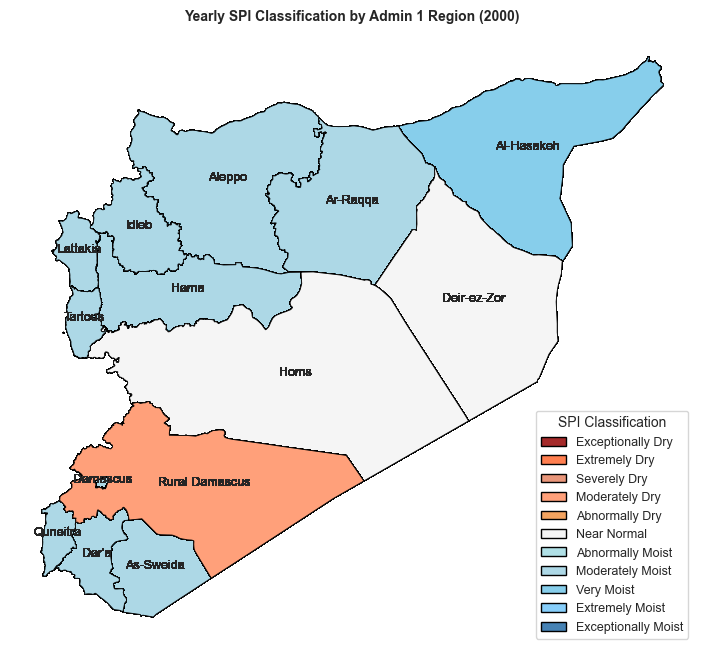

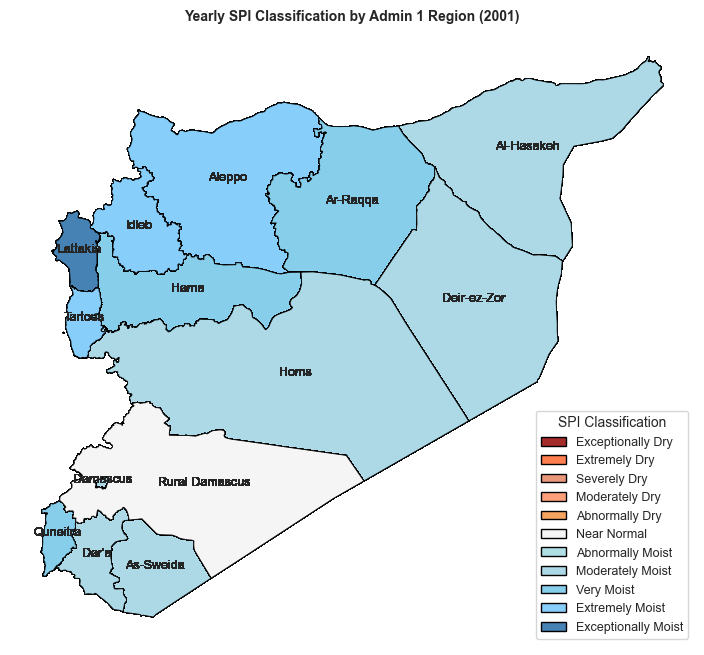

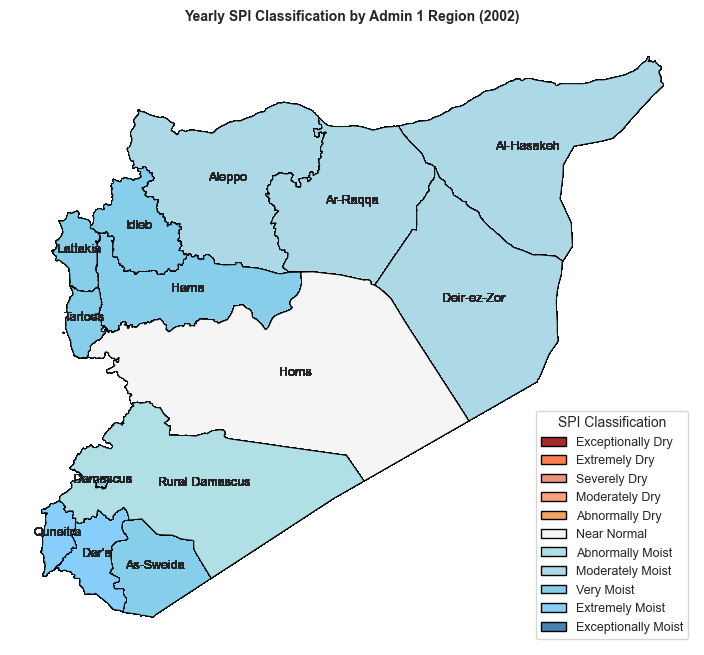

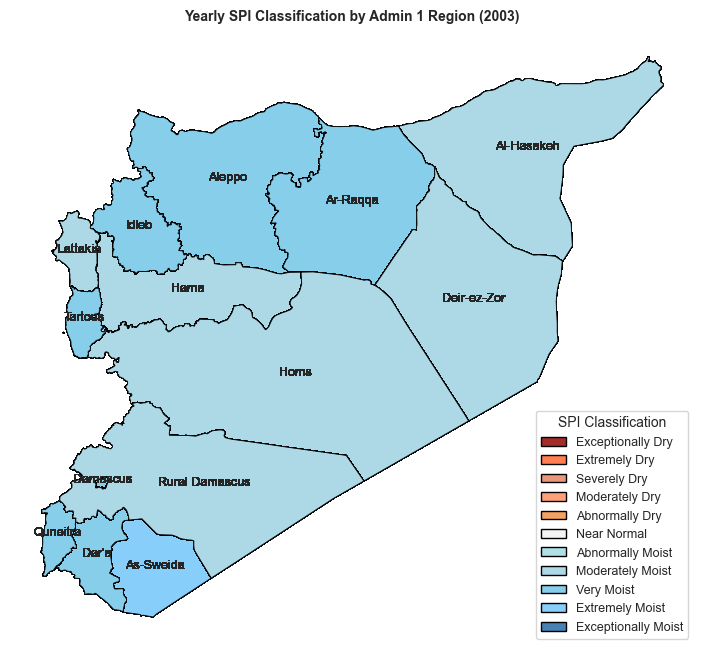

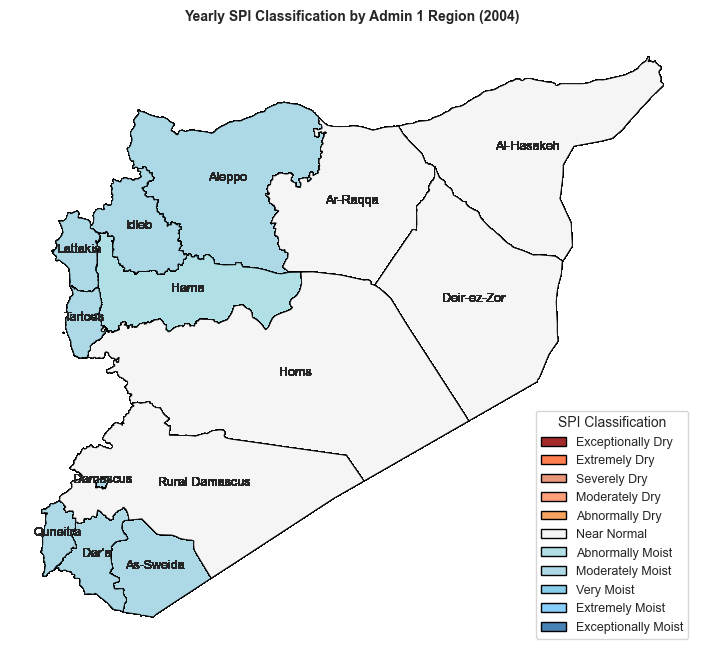

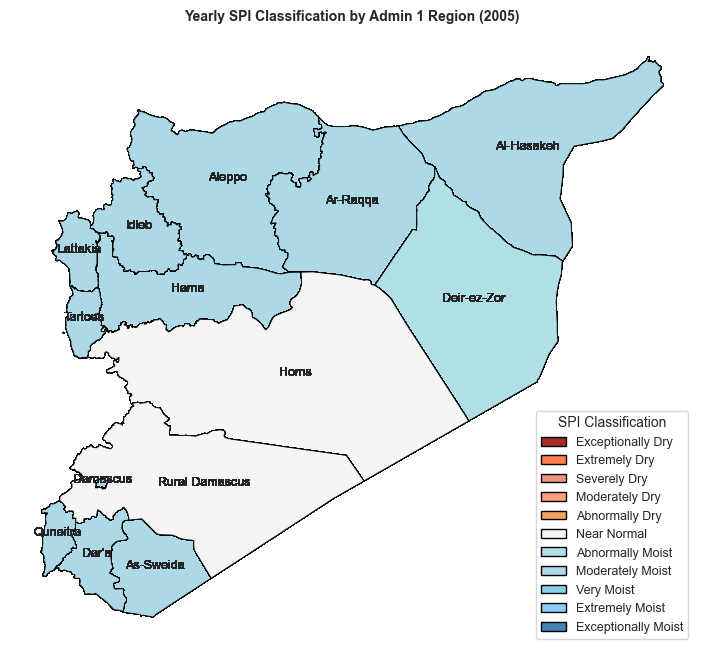

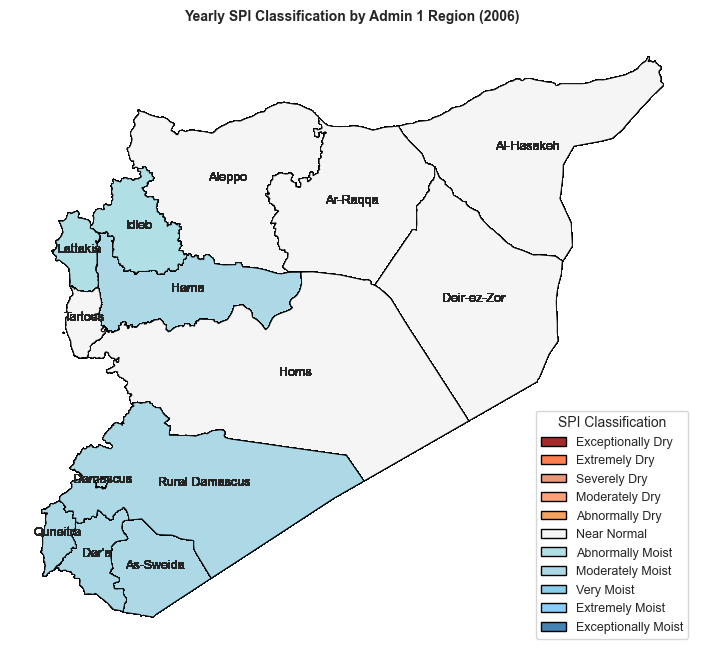

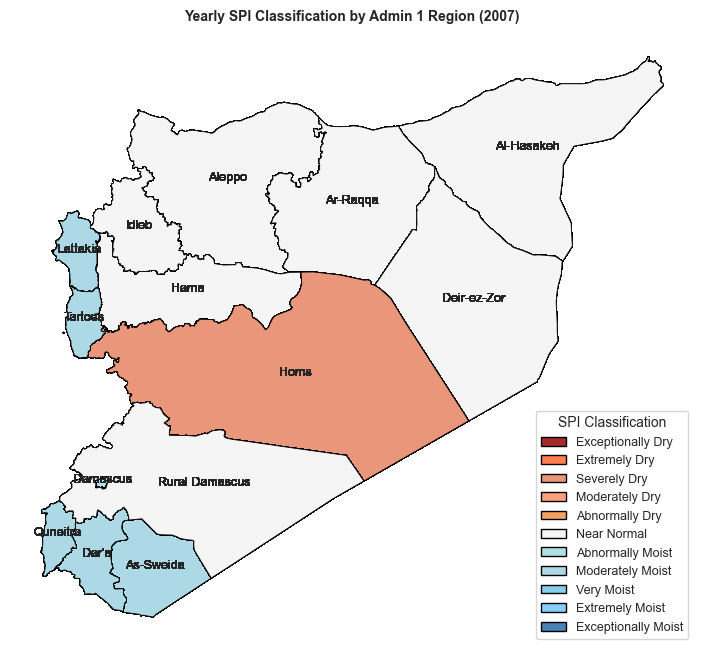

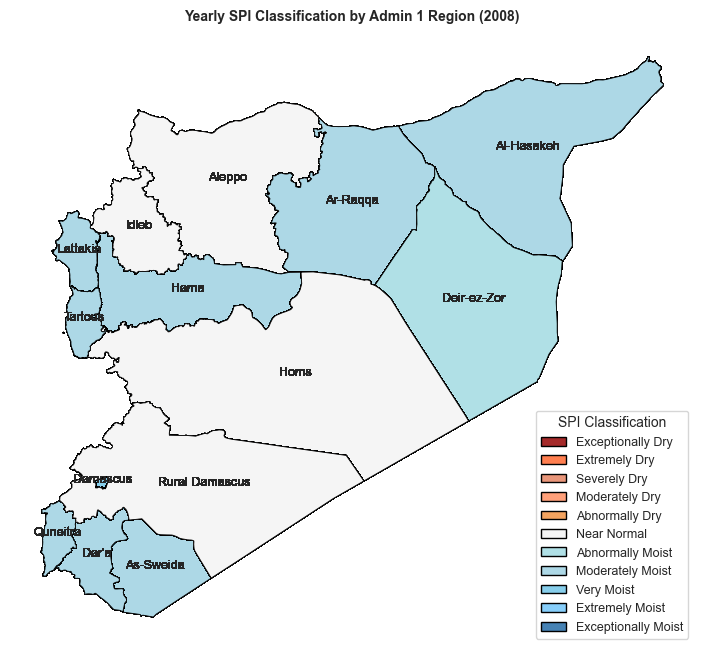

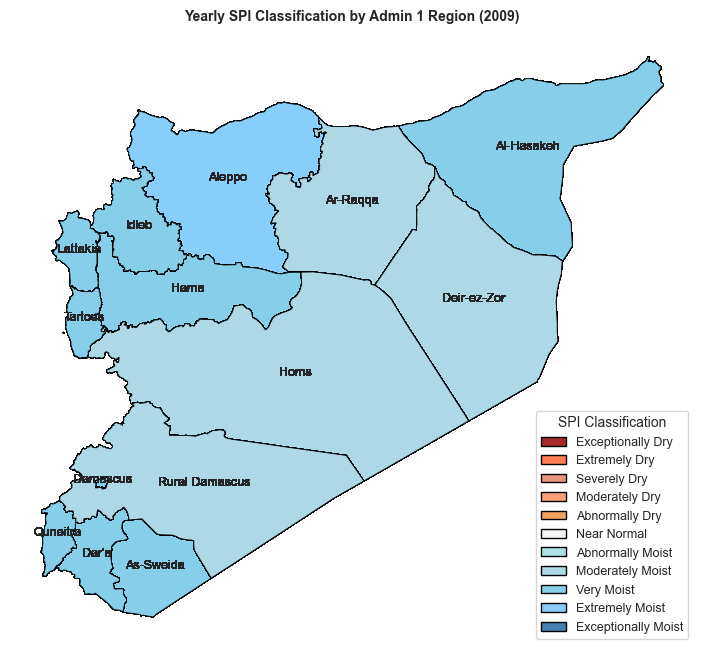

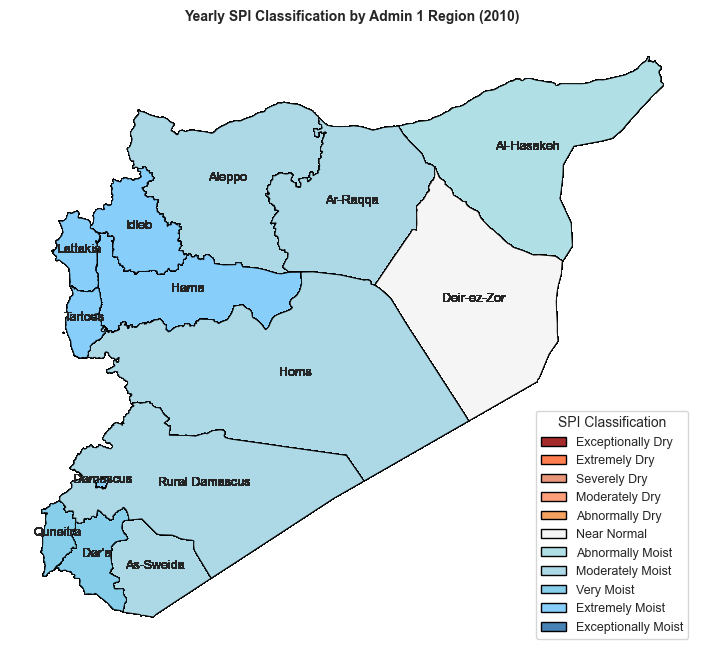

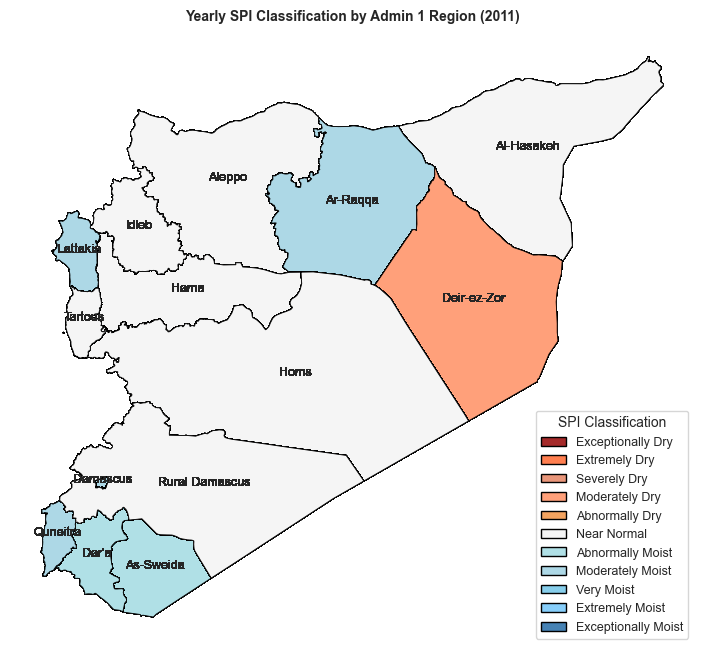

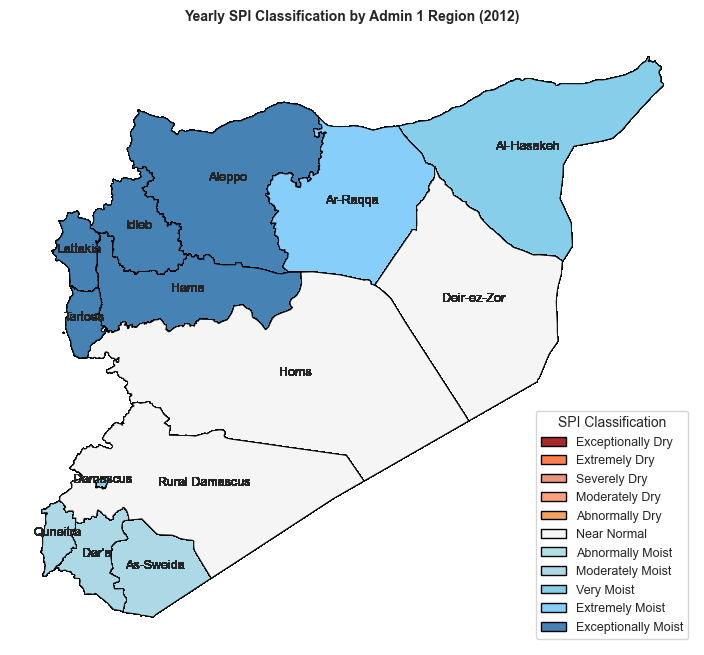

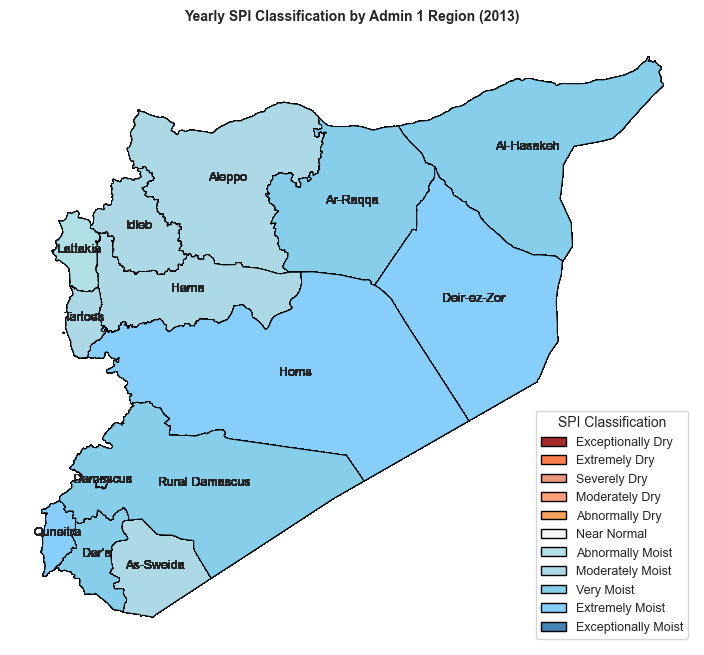

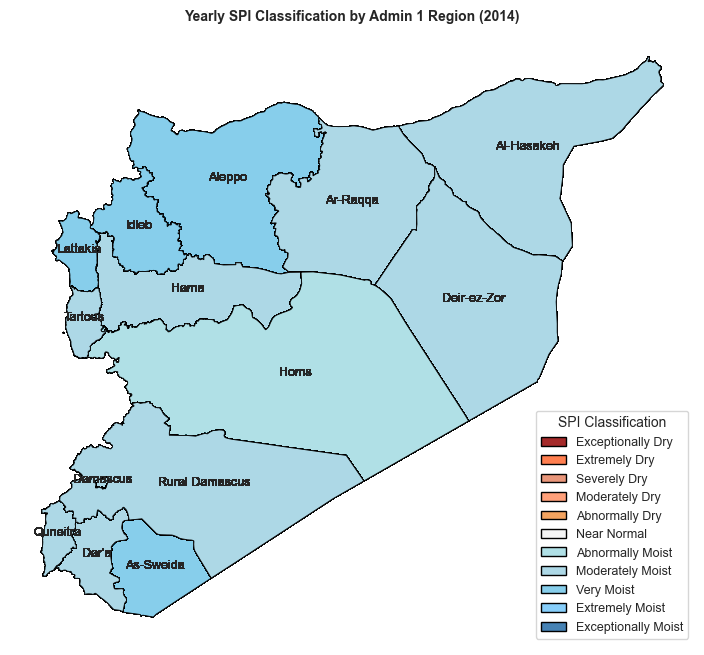

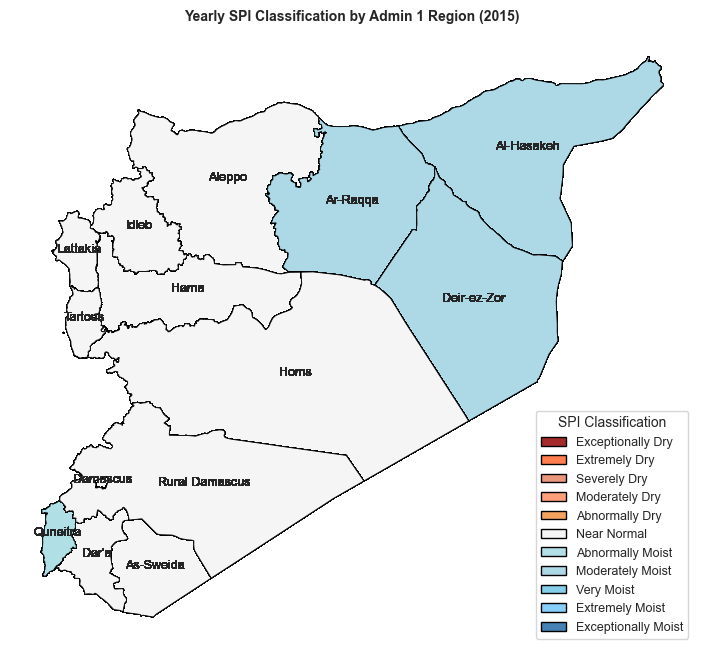

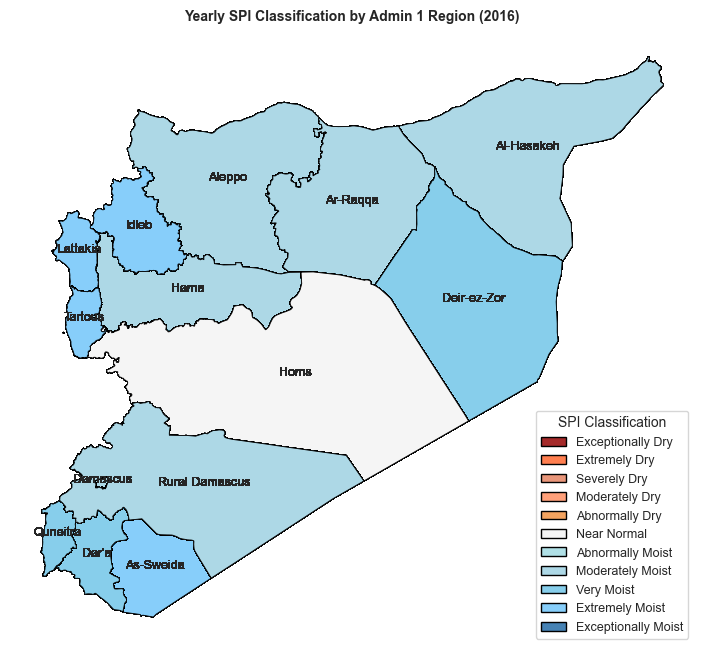

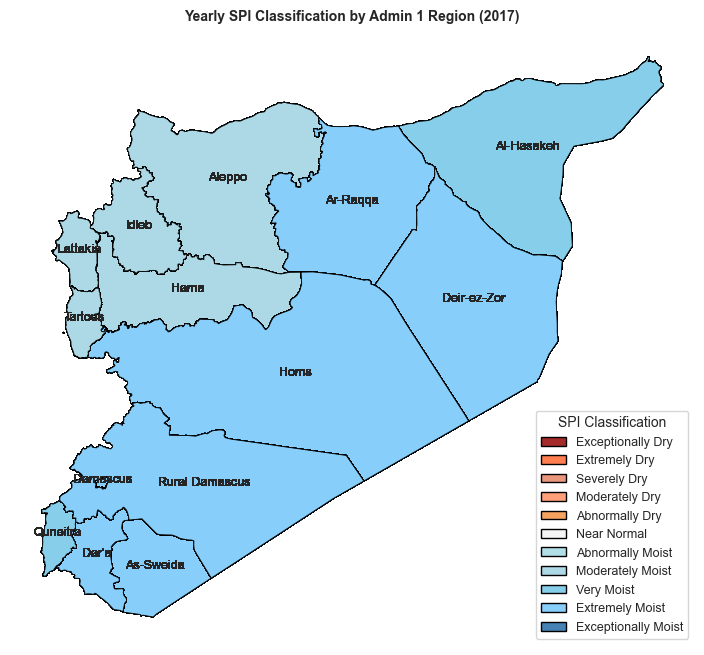

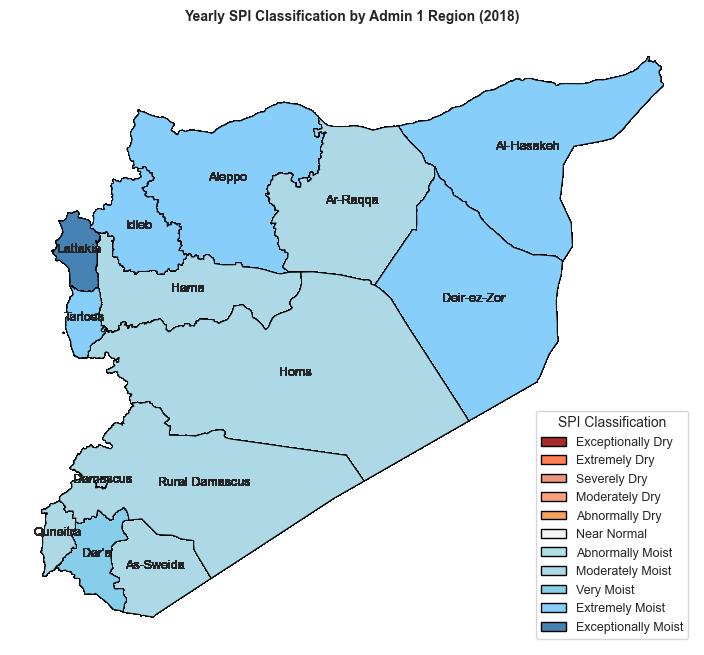

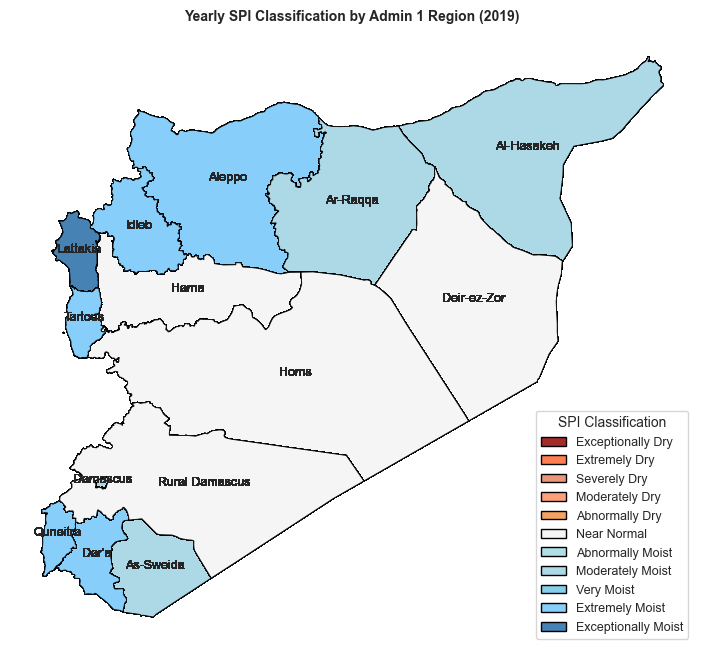

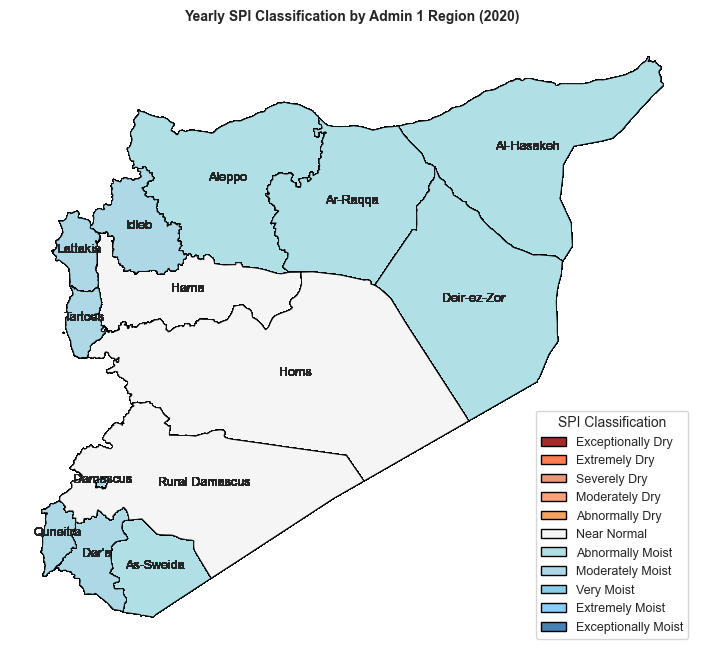

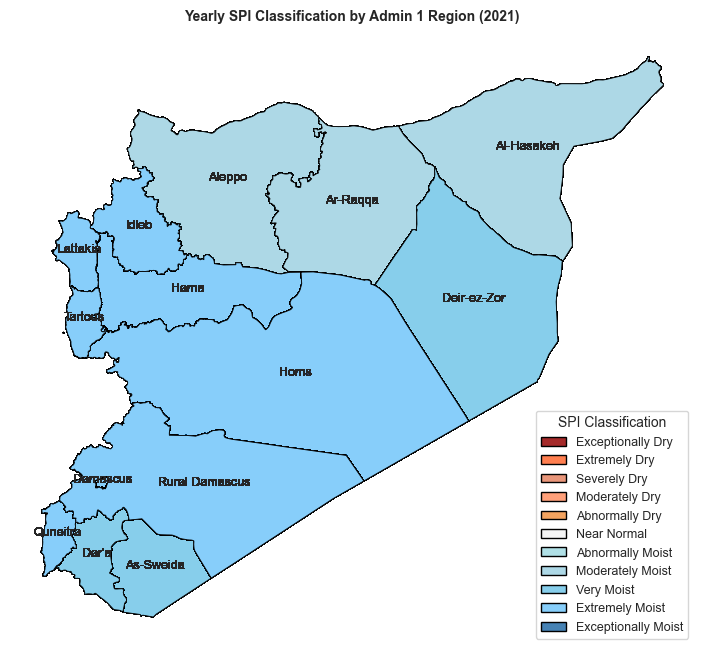

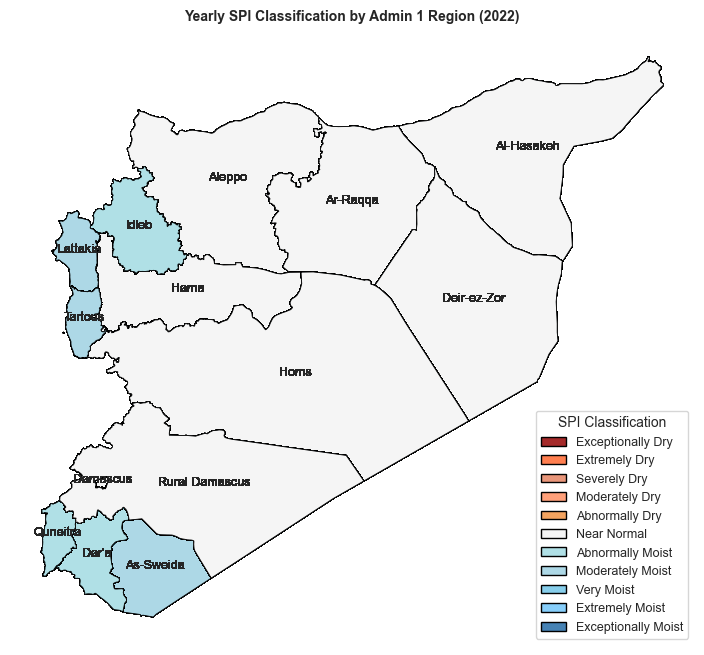

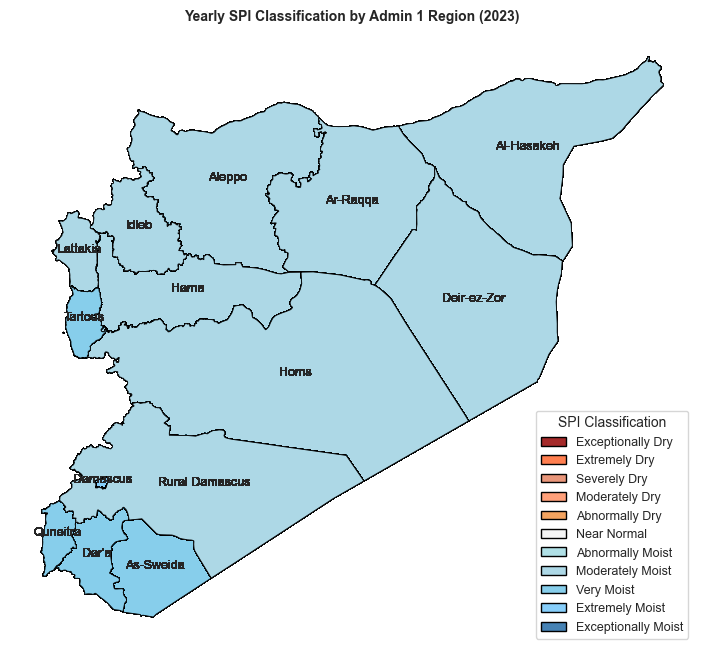

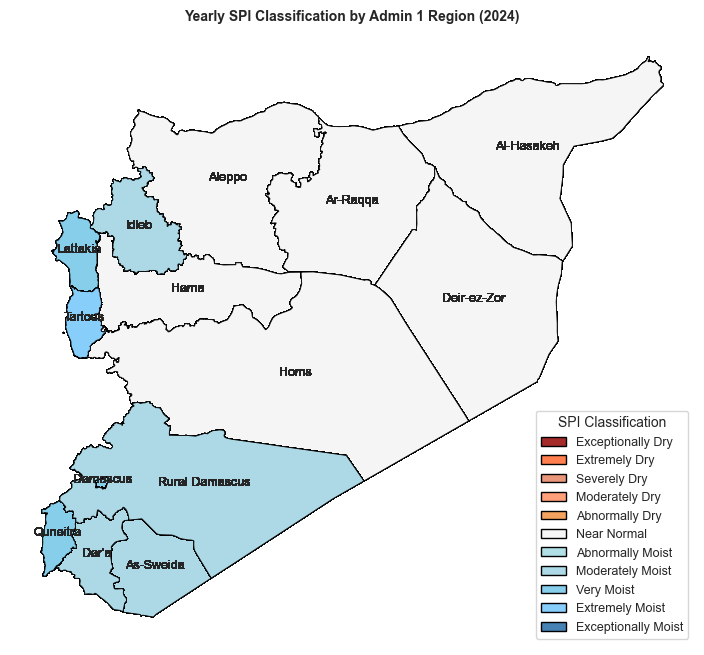

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd
from matplotlib.patches import Patch

# Set Seaborn style
sns.set_style("whitegrid")  # Alternative: "dark", "white", "ticks"

# Define a custom color dictionary
custom_colors = {
    "Exceptionally Dry": "brown",  # Dark Red
    "Extremely Dry": "coral",  # Firebrick
    "Severely Dry": "darksalmon",  # Crimson
    "Moderately Dry": "lightsalmon",  # Orange Red
    "Abnormally Dry": "sandybrown",  # Coral
    
    "Near Normal": "whitesmoke",  # Light Gray (neutral)

    "Abnormally Moist": "powderblue",  # Light Blue
    "Moderately Moist": "lightblue",  # Royal Blue
    "Very Moist": "skyblue",  # Blue
    "Extremely Moist": "lightskyblue",  # Dark Blue
    "Exceptionally Moist": "steelblue"  # Midnight Blue
}

# Iterate over each year and plot
for year in agg_mode_per_year_long["Year"].unique():
    fig, ax = plt.subplots(figsize=(12, 8))

    subset = spi_class_admin1[spi_class_admin1["Year"] == year]

    # Map classifications to colors
    subset["color"] = subset["Most_Frequent_SPI"].map(custom_colors)

    # Plot with the custom color map
    subset.plot(color=subset["color"], edgecolor="black", linewidth=0.6, ax=ax)

    # Add Admin 1 labels (non-bold, slightly smaller)
    for x, y, label in zip(subset.geometry.centroid.x, subset.geometry.centroid.y, subset["ADM1_EN"]):
        ax.text(x, y, label, fontsize=9, ha="center")

    # Remove borders and axis for cleaner look
    ax.set_frame_on(False)
    ax.axis("off")

    # Add legend manually
    legend_patches = [Patch(facecolor=color, edgecolor="black", label=label) for label, color in custom_colors.items()]
    ax.legend(handles=legend_patches, title="SPI Classification", loc="lower right", fontsize=9)

    # Add a title with Seaborn's improved formatting
    plt.title(f"Yearly SPI Classification by Admin 1 Region ({year})", fontsize=10, fontweight="bold")

    plt.show()


In [73]:
df

time        lat        lon       spi
0       2000-01-01  32.325001  35.625004  0.000161
1       2000-01-01  32.325001  35.675003  0.000161
2       2000-01-01  32.325001  35.725002  0.000161
3       2000-01-01  32.325001  35.775002  0.000161
4       2000-01-01  32.325001  35.825005  0.000161
...            ...        ...        ...       ...
4120795 2024-12-01  37.325001  42.175003  0.000161
4120796 2024-12-01  37.325001  42.225002  0.000161
4120797 2024-12-01  37.325001  42.275002  0.000161
4120798 2024-12-01  37.325001  42.325005  0.000161
4120799 2024-12-01  37.325001  42.375004  0.000161

[4120800 rows x 4 columns]

In [74]:
df['spi'].describe()

count    4.120800e+06
mean     1.930771e-04
std      7.350459e-01
min     -2.884628e+00
25%      1.607737e-04
50%      1.607737e-04
75%      3.072925e-01
max      3.091712e+00
Name: spi, dtype: float64

In [ ]:
bins = [-float('inf'), -2.50, -2.00, -1.50, -1.00, -0.50, 0.50, 1.00, 1.50, 2.00, 2.50, float('inf')]
labels = [
    'Exceptionally Dry', 'Extremely Dry', 'Severely Dry', 'Moderately Dry', 'Abnormally Dry',
    'Near Normal', 'Abnormally Moist', 'Moderately Moist', 'Very Moist', 'Extremely Moist', 'Exceptionally Moist'
]
##new bin thresholds to re visualize tomorrow

In [8]:
syr_adm2 = gpd.read_file(r"C:\Users\wb621815\OneDrive - WBG\Desktop\DataLab\SPI_anlaysis\09_shapefiles\syr-administrative-divisions-shapefiles\Shapefiles\syr_admbnda_adm2_uncs_unocha_20201217.shp")
syr_adm2

Shape_Leng  Shape_Area      ADM2_EN     ADM2_AR ADM2_PCODE ADM2_REF  \
0     1.806358    0.126727        A'zaz       اعزاز     SY0204     Azaz   
1     4.276433    0.669159    Abu Kamal    البوكمال     SY0902     None   
2     2.020909    0.185319        Afrin       عفرين     SY0203     None   
3     3.295279    0.308921  Ain Al Arab   عين العرب     SY0206     None   
4     1.272615    0.056692     Al-Haffa       الحفة     SY0603     None   
..         ...         ...          ...         ...        ...      ...   
57    7.660082    3.023978       Tadmor        تدمر     SY0405     None   
58    1.256360    0.046858  Tall Kalakh       تلكلخ     SY0403     None   
59    1.499704    0.052891      Tartous  مركز طرطوس     SY1000     None   
60    4.967437    0.485879   Tell Abiad     تل أبيض     SY1102     None   
61    1.095970    0.056594      Yabroud       يبرود     SY0305     None   

   ADM2ALT1EN ADM2ALT2EN ADM2ALT1AR ADM2ALT2AR         ADM1_EN    ADM1_AR  \
0        None       None       None       None          Aleppo        حلب   
1        None       None       None       None     Deir-ez-Zor  دير الزور   
2        None       None       None       None          Aleppo        حلب   
3        None       None       None       None          Aleppo        حلب   
4        None       None       None       None        Lattakia   اللاذقية   
..        ...        ...        ...        ...             ...        ...   
57       None       None       None       None            Homs        حمص   
58       None       None       None       None            Homs        حمص   
59       None       None       None       None         Tartous      طرطوس   
60       None       None       None       None        Ar-Raqqa      الرقة   
61       None       None       None       None  Rural Damascus   ريف دمشق   

   ADM1_PCODE               ADM0_EN                    ADM0_AR ADM0_PCODE  \
0        SY02  Syrian Arab Republic  الجمهورية العربية السورية         SY   
1        SY09  Syrian Arab Republic  الجمهورية العربية السورية         SY   
2        SY02  Syrian Arab Republic  الجمهورية العربية السورية         SY   
3        SY02  Syrian Arab Republic  الجمهورية العربية السورية         SY   
4        SY06  Syrian Arab Republic  الجمهورية العربية السورية         SY   
..        ...                   ...                        ...        ...   
57       SY04  Syrian Arab Republic  الجمهورية العربية السورية         SY   
58       SY04  Syrian Arab Republic  الجمهورية العربية السورية         SY   
59       SY10  Syrian Arab Republic  الجمهورية العربية السورية         SY   
60       SY11  Syrian Arab Republic  الجمهورية العربية السورية         SY   
61       SY03  Syrian Arab Republic  الجمهورية العربية السورية         SY   

         date    validOn     validTo  \
0  2017-06-01 2020-12-17  0000/00/00   
1  2017-06-01 2020-12-17  0000/00/00   
2  2017-06-01 2020-12-17  0000/00/00   
3  2017-06-01 2020-12-17  0000/00/00   
4  2017-06-01 2020-12-17  0000/00/00   
..        ...        ...         ...   
57 2017-06-01 2020-12-17  0000/00/00   
58 2017-06-01 2020-12-17  0000/00/00   
59 2017-06-01 2020-12-17  0000/00/00   
60 2017-06-01 2020-12-17  0000/00/00   
61 2017-06-01 2020-12-17  0000/00/00   

                                             geometry  
0   POLYGON ((37.36083 36.65404, 37.37267 36.65355...  
1   POLYGON ((41.23161 34.84192, 41.23327 34.82654...  
2   POLYGON ((36.8976 36.7785, 36.90267 36.77769, ...  
3   POLYGON ((38.29637 36.90689, 38.3116 36.90575,...  
4   POLYGON ((36.15056 35.78857, 36.16094 35.78388...  
..                                                ...  
57  POLYGON ((38.87133 35.37107, 39.13431 35.32397...  
58  POLYGON ((36.32888 34.84683, 36.332 34.84468, ...  
59  MULTIPOLYGON (((35.85782 34.8591, 35.85969 34....  
60  POLYGON ((38.79528 36.69788, 38.80076 36.69744...  
61  POLYGON ((36.44537 34.04845, 36.455 34.04353, ...  

[62 rows x 20 columns]

In [17]:
gdf_pivot_adm2 = gpd.sjoin(gdf_pivot,syr_adm2[['geometry','ADM2_EN']],predicate='within',how='left')
gdf_pivot_adm2

lon        lat     20000101     20000201     20000301  \
0      35.625004  32.325001  Near Normal  Near Normal  Near Normal   
1      35.625004  32.375000  Near Normal  Near Normal  Near Normal   
2      35.625004  32.424999  Near Normal  Near Normal  Near Normal   
3      35.625004  32.474998  Near Normal  Near Normal  Near Normal   
4      35.625004  32.524998  Near Normal  Near Normal  Near Normal   
...          ...        ...          ...          ...          ...   
13731  42.375004  37.125000  Near Normal  Near Normal  Near Normal   
13732  42.375004  37.174999  Near Normal  Near Normal  Near Normal   
13733  42.375004  37.224998  Near Normal  Near Normal  Near Normal   
13734  42.375004  37.275002  Near Normal  Near Normal  Near Normal   
13735  42.375004  37.325001  Near Normal  Near Normal  Near Normal   

          20000401     20000501     20000601     20000701     20000801  ...  \
0      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
1      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
2      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
3      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
4      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
...            ...          ...          ...          ...          ...  ...   
13731  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13732  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13733  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13734  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   
13735  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  ...   

          20240801     20240901     20241001     20241101     20241201      x  \
0      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  35.63   
1      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  35.63   
2      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  35.63   
3      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  35.63   
4      Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  35.63   
...            ...          ...          ...          ...          ...    ...   
13731  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  42.38   
13732  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  42.38   
13733  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  42.38   
13734  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  42.38   
13735  Near Normal  Near Normal  Near Normal  Near Normal  Near Normal  42.38   

           y             geometry index_right ADM2_EN  
0      32.33  POINT (35.63 32.33)         NaN     NaN  
1      32.38  POINT (35.63 32.38)         NaN     NaN  
2      32.42  POINT (35.63 32.42)         NaN     NaN  
3      32.47  POINT (35.63 32.47)         NaN     NaN  
4      32.52  POINT (35.63 32.52)         NaN     NaN  
...      ...                  ...         ...     ...  
13731  37.12  POINT (42.38 37.12)         NaN     NaN  
13732  37.17  POINT (42.38 37.17)         NaN     NaN  
13733  37.22  POINT (42.38 37.22)         NaN     NaN  
13734  37.28  POINT (42.38 37.28)         NaN     NaN  
13735  37.33  POINT (42.38 37.33)         NaN     NaN  

[13736 rows x 307 columns]

In [18]:
gdf_joined2 = gpd.sjoin_nearest(gdf, gdf_pivot, how='inner', distance_col='distance')
gdf_joined2

FID             geometry  x_left  y_left  index_right        lon  \
0        0  POINT (35.66 32.72)   35.66   32.72          109  35.675003   
1        1  POINT (35.66 32.77)   35.66   32.77          110  35.675003   
2        2  POINT (35.66 32.82)   35.66   32.82          111  35.675003   
3        3  POINT (35.66 32.87)   35.66   32.87          112  35.675003   
4        4  POINT (35.66 32.92)   35.66   32.92          113  35.675003   
...    ...                  ...     ...     ...          ...        ...   
7422  7422  POINT (42.31 37.07)   42.31   37.07        13629  42.325005   
7423  7423  POINT (42.31 37.12)   42.31   37.12        13630  42.325005   
7424  7424  POINT (42.31 37.17)   42.31   37.17        13631  42.325005   
7425  7425  POINT (42.31 37.22)   42.31   37.22        13632  42.325005   
7426  7426  POINT (42.36 37.07)   42.36   37.07        13730  42.375004   

            lat          20000101          20000201          20000301  ...  \
0     32.724998   Extremely Moist  Abnormally Moist  Moderately Moist  ...   
1     32.774998   Extremely Moist  Abnormally Moist  Moderately Moist  ...   
2     32.825001   Extremely Moist  Abnormally Moist  Moderately Moist  ...   
3     32.875000   Extremely Moist  Abnormally Moist  Moderately Moist  ...   
4     32.924999   Extremely Moist  Abnormally Moist  Moderately Moist  ...   
...         ...               ...               ...               ...  ...   
7422  37.075001  Moderately Moist    Moderately Dry  Moderately Moist  ...   
7423  37.125000  Moderately Moist    Abnormally Dry  Moderately Moist  ...   
7424  37.174999  Moderately Moist    Abnormally Dry  Moderately Moist  ...   
7425  37.224998  Moderately Moist       Near Normal  Moderately Moist  ...   
7426  37.075001  Moderately Moist    Abnormally Dry  Moderately Moist  ...   

            20240601      20240701       20240801        20240901  \
0     Moderately Dry  Severely Dry   Severely Dry  Moderately Dry   
1       Severely Dry  Severely Dry   Severely Dry  Moderately Dry   
2       Severely Dry  Severely Dry   Severely Dry  Moderately Dry   
3       Severely Dry  Severely Dry   Severely Dry  Moderately Dry   
4       Severely Dry  Severely Dry   Severely Dry  Moderately Dry   
...              ...           ...            ...             ...   
7422     Near Normal  Severely Dry  Extremely Dry  Abnormally Dry   
7423     Near Normal  Severely Dry  Extremely Dry  Abnormally Dry   
7424     Near Normal  Severely Dry  Extremely Dry  Abnormally Dry   
7425     Near Normal  Severely Dry  Extremely Dry     Near Normal   
7426     Near Normal  Severely Dry  Extremely Dry     Near Normal   

            20241001          20241101          20241201 x_right y_right  \
0        Near Normal       Near Normal        Very Moist   35.68   32.72   
1        Near Normal       Near Normal        Very Moist   35.68   32.77   
2        Near Normal       Near Normal        Very Moist   35.68   32.83   
3        Near Normal       Near Normal        Very Moist   35.68   32.88   
4        Near Normal       Near Normal   Extremely Moist   35.68   32.92   
...              ...               ...               ...     ...     ...   
7422  Moderately Dry       Near Normal  Abnormally Moist   42.33   37.08   
7423  Moderately Dry       Near Normal  Abnormally Moist   42.33   37.12   
7424  Moderately Dry       Near Normal  Abnormally Moist   42.33   37.17   
7425  Moderately Dry       Near Normal  Abnormally Moist   42.33   37.22   
7426  Moderately Dry  Abnormally Moist  Abnormally Moist   42.38   37.08   

      distance  
0     0.020000  
1     0.020000  
2     0.022361  
3     0.022361  
4     0.020000  
...        ...  
7422  0.022361  
7423  0.020000  
7424  0.020000  
7425  0.020000  
7426  0.022361  

[7427 rows x 310 columns]

In [19]:
# Drop unnecessary columns
gdf_joined2 = gdf_joined2.drop(columns=['x_left', 'y_left', 'index_right', 'x_right', 'y_right','FID'])

In [20]:
gdf_joined2

geometry        lon        lat          20000101  \
0     POINT (35.66 32.72)  35.675003  32.724998   Extremely Moist   
1     POINT (35.66 32.77)  35.675003  32.774998   Extremely Moist   
2     POINT (35.66 32.82)  35.675003  32.825001   Extremely Moist   
3     POINT (35.66 32.87)  35.675003  32.875000   Extremely Moist   
4     POINT (35.66 32.92)  35.675003  32.924999   Extremely Moist   
...                   ...        ...        ...               ...   
7422  POINT (42.31 37.07)  42.325005  37.075001  Moderately Moist   
7423  POINT (42.31 37.12)  42.325005  37.125000  Moderately Moist   
7424  POINT (42.31 37.17)  42.325005  37.174999  Moderately Moist   
7425  POINT (42.31 37.22)  42.325005  37.224998  Moderately Moist   
7426  POINT (42.36 37.07)  42.375004  37.075001  Moderately Moist   

              20000201          20000301          20000401        20000501  \
0     Abnormally Moist  Moderately Moist       Near Normal  Moderately Dry   
1     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
2     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
3     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
4     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
...                ...               ...               ...             ...   
7422    Moderately Dry  Moderately Moist  Moderately Moist     Near Normal   
7423    Abnormally Dry  Moderately Moist  Moderately Moist     Near Normal   
7424    Abnormally Dry  Moderately Moist  Moderately Moist     Near Normal   
7425       Near Normal  Moderately Moist  Moderately Moist     Near Normal   
7426    Abnormally Dry  Moderately Moist  Moderately Moist     Near Normal   

            20000601      20000701  ...          20240401          20240501  \
0     Moderately Dry  Severely Dry  ...       Near Normal       Near Normal   
1       Severely Dry  Severely Dry  ...       Near Normal       Near Normal   
2       Severely Dry  Severely Dry  ...       Near Normal    Abnormally Dry   
3       Severely Dry  Severely Dry  ...       Near Normal    Abnormally Dry   
4       Severely Dry  Severely Dry  ...       Near Normal    Abnormally Dry   
...              ...           ...  ...               ...               ...   
7422    Severely Dry  Severely Dry  ...  Abnormally Moist  Moderately Moist   
7423    Severely Dry  Severely Dry  ...  Abnormally Moist  Moderately Moist   
7424    Severely Dry  Severely Dry  ...  Abnormally Moist  Moderately Moist   
7425    Severely Dry  Severely Dry  ...       Near Normal  Abnormally Moist   
7426    Severely Dry  Severely Dry  ...  Abnormally Moist  Moderately Moist   

            20240601      20240701       20240801        20240901  \
0     Moderately Dry  Severely Dry   Severely Dry  Moderately Dry   
1       Severely Dry  Severely Dry   Severely Dry  Moderately Dry   
2       Severely Dry  Severely Dry   Severely Dry  Moderately Dry   
3       Severely Dry  Severely Dry   Severely Dry  Moderately Dry   
4       Severely Dry  Severely Dry   Severely Dry  Moderately Dry   
...              ...           ...            ...             ...   
7422     Near Normal  Severely Dry  Extremely Dry  Abnormally Dry   
7423     Near Normal  Severely Dry  Extremely Dry  Abnormally Dry   
7424     Near Normal  Severely Dry  Extremely Dry  Abnormally Dry   
7425     Near Normal  Severely Dry  Extremely Dry     Near Normal   
7426     Near Normal  Severely Dry  Extremely Dry     Near Normal   

            20241001          20241101          20241201  distance  
0        Near Normal       Near Normal        Very Moist  0.020000  
1        Near Normal       Near Normal        Very Moist  0.020000  
2        Near Normal       Near Normal        Very Moist  0.022361  
3        Near Normal       Near Normal        Very Moist  0.022361  
4        Near Normal       Near Normal   Extremely Moist  0.020000  
...              ...               ...               ...   

In [21]:
gdf_with_admin2 = gpd.sjoin(gdf_joined2, syr_adm2[['geometry', 'ADM2_EN']], how="left", predicate="intersects")

# Drop unnecessary columns
gdf_with_admin2 = gdf_with_admin2.drop(columns=["index_right"])

gdf_with_admin2

geometry        lon        lat          20000101  \
0     POINT (35.66 32.72)  35.675003  32.724998   Extremely Moist   
1     POINT (35.66 32.77)  35.675003  32.774998   Extremely Moist   
2     POINT (35.66 32.82)  35.675003  32.825001   Extremely Moist   
3     POINT (35.66 32.87)  35.675003  32.875000   Extremely Moist   
4     POINT (35.66 32.92)  35.675003  32.924999   Extremely Moist   
...                   ...        ...        ...               ...   
7422  POINT (42.31 37.07)  42.325005  37.075001  Moderately Moist   
7423  POINT (42.31 37.12)  42.325005  37.125000  Moderately Moist   
7424  POINT (42.31 37.17)  42.325005  37.174999  Moderately Moist   
7425  POINT (42.31 37.22)  42.325005  37.224998  Moderately Moist   
7426  POINT (42.36 37.07)  42.375004  37.075001  Moderately Moist   

              20000201          20000301          20000401        20000501  \
0     Abnormally Moist  Moderately Moist       Near Normal  Moderately Dry   
1     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
2     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
3     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
4     Abnormally Moist  Moderately Moist       Near Normal    Severely Dry   
...                ...               ...               ...             ...   
7422    Moderately Dry  Moderately Moist  Moderately Moist     Near Normal   
7423    Abnormally Dry  Moderately Moist  Moderately Moist     Near Normal   
7424    Abnormally Dry  Moderately Moist  Moderately Moist     Near Normal   
7425       Near Normal  Moderately Moist  Moderately Moist     Near Normal   
7426    Abnormally Dry  Moderately Moist  Moderately Moist     Near Normal   

            20000601      20000701  ...          20240501        20240601  \
0     Moderately Dry  Severely Dry  ...       Near Normal  Moderately Dry   
1       Severely Dry  Severely Dry  ...       Near Normal    Severely Dry   
2       Severely Dry  Severely Dry  ...    Abnormally Dry    Severely Dry   
3       Severely Dry  Severely Dry  ...    Abnormally Dry    Severely Dry   
4       Severely Dry  Severely Dry  ...    Abnormally Dry    Severely Dry   
...              ...           ...  ...               ...             ...   
7422    Severely Dry  Severely Dry  ...  Moderately Moist     Near Normal   
7423    Severely Dry  Severely Dry  ...  Moderately Moist     Near Normal   
7424    Severely Dry  Severely Dry  ...  Moderately Moist     Near Normal   
7425    Severely Dry  Severely Dry  ...  Abnormally Moist     Near Normal   
7426    Severely Dry  Severely Dry  ...  Moderately Moist     Near Normal   

          20240701       20240801        20240901        20241001  \
0     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
1     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
2     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
3     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
4     Severely Dry   Severely Dry  Moderately Dry     Near Normal   
...            ...            ...             ...             ...   
7422  Severely Dry  Extremely Dry  Abnormally Dry  Moderately Dry   
7423  Severely Dry  Extremely Dry  Abnormally Dry  Moderately Dry   
7424  Severely Dry  Extremely Dry  Abnormally Dry  Moderately Dry   
7425  Severely Dry  Extremely Dry     Near Normal  Moderately Dry   
7426  Severely Dry  Extremely Dry     Near Normal  Moderately Dry   

              20241101          20241201  distance        ADM2_EN  
0          Near Normal        Very Moist  0.020000         Al Fiq  
1          Near Normal        Very Moist  0.020000            NaN  
2          Near Normal        Very Moist  0.022361         Al Fiq  
3          Near Normal        Very Moist  0.022361         Al Fiq  
4          Near Normal   Extremely Moist  0.020000         Al Fiq  
...                ...               ...       ...            ...  
7422       Near Norma

In [23]:
agg_data_adm2 = gdf_with_admin2.groupby("ADM2_EN").apply(lambda x: x.value_counts().index[0]).reset_index()
agg_data_adm2

ADM2_EN                                                  0
0         A'zaz  (POINT (36.96 36.32), 36.97500228881836, 36.32...
1     Abu Kamal  (POINT (40.56 34.22), 40.57500457763672, 34.22...
2         Afrin  (POINT (36.66 36.37), 36.67500305175781, 36.37...
3   Ain Al Arab  (POINT (38.21 36.32), 38.22500228881836, 36.32...
4        Al Bab  (POINT (37.36 36.22), 37.375003814697266, 36.2...
..          ...                                                ...
57       Tadmor  (POINT (40.11 34.02), 40.125003814697266, 34.0...
58  Tall Kalakh  (POINT (36.16 34.67), 36.17500305175781, 34.67...
59      Tartous  (POINT (35.96 34.72), 35.97500228881836, 34.72...
60   Tell Abiad  (POINT (38.91 36.32), 38.92500305175781, 36.32...
61      Yabroud  (POINT (36.41 33.87), 36.42500305175781, 33.87...

[62 rows x 2 columns]

In [24]:
gdf_with_admin2.columns = gdf_with_admin2.columns.astype(str)
yearly_columns = [col for col in gdf_with_admin2.columns if col.isdigit()]  # Identify SPI columns
year_mapping = {col: col[:4] for col in yearly_columns}  # Map to year
gdf_with_admin2 = gdf_with_admin2.rename(columns=year_mapping)

In [26]:
agg_yearly_adm2 = gdf_with_admin2.groupby("ADM2_EN")[list(year_mapping.values())].agg(lambda x: x.mode()[0]).reset_index()
agg_yearly_adm2

ADM2_EN             2000            2000              2000  \
0         A'zaz  Extremely Moist    Severely Dry       Near Normal   
1     Abu Kamal      Near Normal  Moderately Dry  Moderately Moist   
2         Afrin  Extremely Moist  Moderately Dry    Moderately Dry   
3   Ain Al Arab  Extremely Moist     Near Normal      Severely Dry   
4        Al Bab       Very Moist     Near Normal       Near Normal   
..          ...              ...             ...               ...   
57       Tadmor      Near Normal  Moderately Dry  Moderately Moist   
58  Tall Kalakh  Extremely Moist     Near Normal  Abnormally Moist   
59      Tartous  Extremely Moist     Near Normal       Near Normal   
60   Tell Abiad  Extremely Moist     Near Normal       Near Normal   
61      Yabroud  Extremely Moist     Near Normal  Abnormally Moist   

                2000            2000            2000            2000  \
0   Moderately Moist     Near Normal    Severely Dry    Severely Dry   
1   Moderately Moist  Moderately Dry  Moderately Dry  Moderately Dry   
2   Moderately Moist     Near Normal   Extremely Dry   Extremely Dry   
3   Moderately Moist     Near Normal    Severely Dry    Severely Dry   
4   Moderately Moist     Near Normal    Severely Dry    Severely Dry   
..               ...             ...             ...             ...   
57  Moderately Moist  Moderately Dry  Moderately Dry  Moderately Dry   
58       Near Normal  Moderately Dry   Extremely Dry    Severely Dry   
59       Near Normal  Moderately Dry    Severely Dry    Severely Dry   
60  Moderately Moist     Near Normal    Severely Dry    Severely Dry   
61       Near Normal    Severely Dry    Severely Dry    Severely Dry   

              2000            2000  ...              2024         2024  \
0   Moderately Dry  Moderately Dry  ...       Near Normal  Near Normal   
1   Moderately Dry  Moderately Dry  ...   Extremely Moist  Near Normal   
2   Moderately Dry     Near Normal  ...       Near Normal  Near Normal   
3   Moderately Dry     Near Normal  ...  Abnormally Moist  Near Normal   
4     Severely Dry    Severely Dry  ...  Abnormally Moist  Near Normal   
..             ...             ...  ...               ...          ...   
57  Moderately Dry  Moderately Dry  ...   Extremely Moist  Near Normal   
58  Moderately Dry  Abnormally Dry  ...  Moderately Moist  Near Normal   
59  Moderately Dry     Near Normal  ...  Moderately Moist  Near Normal   
60    Severely Dry  Moderately Dry  ...       Near Normal  Near Normal   
61    Severely Dry  Abnormally Dry  ...       Near Normal  Near Normal   

                2024            2024            2024            2024  \
0        Near Normal    Severely Dry    Severely Dry  Moderately Dry   
1     Moderately Dry  Moderately Dry  Moderately Dry  Moderately Dry   
2   Abnormally Moist    Severely Dry    Severely Dry  Moderately Dry   
3        Near Normal     Near Normal    Severely Dry  Moderately Dry   
4        Near Normal    Severely Dry    Severely Dry    Severely Dry   
..               ...             ...             ...             ...   
57       Near Normal  Moderately Dry  Moderately Dry  Moderately Dry   
58    Abnormally Dry   Extremely Dry    Severely Dry  Moderately Dry   
59    Moderately Dry    Severely Dry   Extremely Dry    Severely Dry   
60       Near Normal     Near Normal    Severely Dry    Severely Dry   
61       Near Normal    Severely Dry    Severely Dry    Severely Dry   

              2024            2024              2024             2024  
0      Near Normal  Moderately Dry       Near Normal      Near Normal  
1   Moderately Dry  Moderately Dry  Moderately Moist   Moderately Dry  
2      Near Normal  Moderately Dry       Near Normal      Near Normal  
3   Moderately Dry  Moderately Dry       Near Normal      Near Normal  
4      Near Normal    Severely Dry       Near Normal      Near Normal  
..             ...             ...               ...              ...  
57  Moderately Dry  Moderately Dry       Nea

In [28]:
# Exclude the first column ("ADM1_EN") and compute the mode across all years
agg_mode = agg_yearly_adm2.set_index("ADM2_EN").mode(axis=1)

# Ensure we only keep the first mode (in case of multiple modes)
agg_mode = agg_mode.iloc[:, 0].reset_index()

# Rename column for clarity
agg_mode.columns = ["ADM2_EN", "Most_Frequent_SPI"]


In [30]:
agg_mode_per_year = agg_yearly_adm2.set_index("ADM2_EN").apply(lambda x: x.mode()[0], axis=1).reset_index()
agg_mode_per_year.columns = ["ADM2_EN"] + [f"Mode_{col}" for col in agg_mode_per_year.columns[1:]]
agg_mode_per_year

ADM2_EN          Mode_0
0         A'zaz     Near Normal
1     Abu Kamal  Moderately Dry
2         Afrin     Near Normal
3   Ain Al Arab     Near Normal
4        Al Bab    Severely Dry
..          ...             ...
57       Tadmor  Moderately Dry
58  Tall Kalakh     Near Normal
59      Tartous     Near Normal
60   Tell Abiad     Near Normal
61      Yabroud     Near Normal

[62 rows x 2 columns]

In [31]:
agg_mode_per_year = agg_yearly_adm2.groupby("ADM2_EN").agg(lambda x: x.mode()[0]).reset_index()
agg_mode_per_year

ADM2_EN             2000            2000              2000  \
0         A'zaz  Extremely Moist    Severely Dry       Near Normal   
1     Abu Kamal      Near Normal  Moderately Dry  Moderately Moist   
2         Afrin  Extremely Moist  Moderately Dry    Moderately Dry   
3   Ain Al Arab  Extremely Moist     Near Normal      Severely Dry   
4        Al Bab       Very Moist     Near Normal       Near Normal   
..          ...              ...             ...               ...   
57       Tadmor      Near Normal  Moderately Dry  Moderately Moist   
58  Tall Kalakh  Extremely Moist     Near Normal  Abnormally Moist   
59      Tartous  Extremely Moist     Near Normal       Near Normal   
60   Tell Abiad  Extremely Moist     Near Normal       Near Normal   
61      Yabroud  Extremely Moist     Near Normal  Abnormally Moist   

                2000            2000            2000            2000  \
0   Moderately Moist     Near Normal    Severely Dry    Severely Dry   
1   Moderately Moist  Moderately Dry  Moderately Dry  Moderately Dry   
2   Moderately Moist     Near Normal   Extremely Dry   Extremely Dry   
3   Moderately Moist     Near Normal    Severely Dry    Severely Dry   
4   Moderately Moist     Near Normal    Severely Dry    Severely Dry   
..               ...             ...             ...             ...   
57  Moderately Moist  Moderately Dry  Moderately Dry  Moderately Dry   
58       Near Normal  Moderately Dry   Extremely Dry    Severely Dry   
59       Near Normal  Moderately Dry    Severely Dry    Severely Dry   
60  Moderately Moist     Near Normal    Severely Dry    Severely Dry   
61       Near Normal    Severely Dry    Severely Dry    Severely Dry   

              2000            2000  ...              2024         2024  \
0   Moderately Dry  Moderately Dry  ...       Near Normal  Near Normal   
1   Moderately Dry  Moderately Dry  ...   Extremely Moist  Near Normal   
2   Moderately Dry     Near Normal  ...       Near Normal  Near Normal   
3   Moderately Dry     Near Normal  ...  Abnormally Moist  Near Normal   
4     Severely Dry    Severely Dry  ...  Abnormally Moist  Near Normal   
..             ...             ...  ...               ...          ...   
57  Moderately Dry  Moderately Dry  ...   Extremely Moist  Near Normal   
58  Moderately Dry  Abnormally Dry  ...  Moderately Moist  Near Normal   
59  Moderately Dry     Near Normal  ...  Moderately Moist  Near Normal   
60    Severely Dry  Moderately Dry  ...       Near Normal  Near Normal   
61    Severely Dry  Abnormally Dry  ...       Near Normal  Near Normal   

                2024            2024            2024            2024  \
0        Near Normal    Severely Dry    Severely Dry  Moderately Dry   
1     Moderately Dry  Moderately Dry  Moderately Dry  Moderately Dry   
2   Abnormally Moist    Severely Dry    Severely Dry  Moderately Dry   
3        Near Normal     Near Normal    Severely Dry  Moderately Dry   
4        Near Normal    Severely Dry    Severely Dry    Severely Dry   
..               ...             ...             ...             ...   
57       Near Normal  Moderately Dry  Moderately Dry  Moderately Dry   
58    Abnormally Dry   Extremely Dry    Severely Dry  Moderately Dry   
59    Moderately Dry    Severely Dry   Extremely Dry    Severely Dry   
60       Near Normal     Near Normal    Severely Dry    Severely Dry   
61       Near Normal    Severely Dry    Severely Dry    Severely Dry   

              2024            2024              2024             2024  
0      Near Normal  Moderately Dry       Near Normal      Near Normal  
1   Moderately Dry  Moderately Dry  Moderately Moist   Moderately Dry  
2      Near Normal  Moderately Dry       Near Normal      Near Normal  
3   Moderately Dry  Moderately Dry       Near Normal      Near Normal  
4      Near Normal    Severely Dry       Near Normal      Near Normal  
..             ...             ...               ...              ...  
57  Moderately Dry  Moderately Dry       Nea

In [32]:
agg_mode_per_year_long = agg_mode_per_year.melt(id_vars=["ADM2_EN"], var_name="Year", value_name="Most_Frequent_SPI")
agg_mode_per_year_long

ADM2_EN  Year Most_Frequent_SPI
0             A'zaz  2000   Extremely Moist
1         Abu Kamal  2000       Near Normal
2             Afrin  2000   Extremely Moist
3       Ain Al Arab  2000   Extremely Moist
4            Al Bab  2000        Very Moist
...             ...   ...               ...
223195       Tadmor  2024       Near Normal
223196  Tall Kalakh  2024        Very Moist
223197      Tartous  2024   Extremely Moist
223198   Tell Abiad  2024       Near Normal
223199      Yabroud  2024        Very Moist

[223200 rows x 3 columns]

In [33]:
admin2_gdf = syr_adm2.merge(agg_mode_per_year_long, on="ADM2_EN", how="left")

In [37]:
spi_class_admin2 = admin2_gdf.drop(columns=['ADM2_AR','ADM2_PCODE','ADM2_REF','ADM2ALT1EN','ADM2ALT2EN','ADM2ALT1AR','ADM2ALT2AR','ADM1_EN','ADM1_AR','ADM1_PCODE','ADM0_EN','ADM0_AR','ADM0_PCODE','date','validOn','validTo'])

In [38]:
spi_class_admin2

Shape_Leng  Shape_Area  ADM2_EN  \
0         1.806358    0.126727    A'zaz   
1         1.806358    0.126727    A'zaz   
2         1.806358    0.126727    A'zaz   
3         1.806358    0.126727    A'zaz   
4         1.806358    0.126727    A'zaz   
...            ...         ...      ...   
223195    1.095970    0.056594  Yabroud   
223196    1.095970    0.056594  Yabroud   
223197    1.095970    0.056594  Yabroud   
223198    1.095970    0.056594  Yabroud   
223199    1.095970    0.056594  Yabroud   

                                                 geometry  Year  \
0       POLYGON ((37.36083 36.65404, 37.37267 36.65355...  2000   
1       POLYGON ((37.36083 36.65404, 37.37267 36.65355...  2000   
2       POLYGON ((37.36083 36.65404, 37.37267 36.65355...  2000   
3       POLYGON ((37.36083 36.65404, 37.37267 36.65355...  2000   
4       POLYGON ((37.36083 36.65404, 37.37267 36.65355...  2000   
...                                                   ...   ...   
223195  POLYGON ((36.44537 34.04845, 36.455 34.04353, ...  2024   
223196  POLYGON ((36.44537 34.04845, 36.455 34.04353, ...  2024   
223197  POLYGON ((36.44537 34.04845, 36.455 34.04353, ...  2024   
223198  POLYGON ((36.44537 34.04845, 36.455 34.04353, ...  2024   
223199  POLYGON ((36.44537 34.04845, 36.455 34.04353, ...  2024   

       Most_Frequent_SPI  
0        Extremely Moist  
1           Severely Dry  
2            Near Normal  
3       Moderately Moist  
4            Near Normal  
...                  ...  
223195      Severely Dry  
223196       Near Normal  
223197    Moderately Dry  
223198       Near Normal  
223199        Very Moist  

[223200 rows x 6 columns]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd
from matplotlib.patches import Patch

# Set Seaborn style
sns.set_style("whitegrid")  # Alternative: "dark", "white", "ticks"

# Define a custom color dictionary
custom_colors = {
    "Exceptionally Dry": "brown",  # Dark Red
    "Extremely Dry": "coral",  # Firebrick
    "Severely Dry": "darksalmon",  # Crimson
    "Moderately Dry": "lightsalmon",  # Orange Red
    "Abnormally Dry": "sandybrown",  # Coral
    
    "Near Normal": "whitesmoke",  # Light Gray (neutral)

    "Abnormally Moist": "powderblue",  # Light Blue
    "Moderately Moist": "lightblue",  # Royal Blue
    "Very Moist": "skyblue",  # Blue
    "Extremely Moist": "lightskyblue",  # Dark Blue
    "Exceptionally Moist": "steelblue"  # Midnight Blue
}

# Iterate over each year and plot
for year in agg_mode_per_year_long["Year"].unique():
    fig, ax = plt.subplots(figsize=(12, 8))

    subset = spi_class_admin2[spi_class_admin2["Year"] == year]

    # Map classifications to colors
    subset["color"] = subset["Most_Frequent_SPI"].map(custom_colors)

    # Plot with the custom color map
    subset.plot(color=subset["color"], edgecolor="black", linewidth=0.6, ax=ax)

    # Add Admin 1 labels (non-bold, slightly smaller)
    for x, y, label in zip(subset.geometry.centroid.x, subset.geometry.centroid.y, subset["ADM2_EN"]):
        ax.text(x, y, label, fontsize=9, ha="center")

    # Remove borders and axis for cleaner look
    ax.set_frame_on(False)
    ax.axis("off")

    # Add legend manually
    legend_patches = [Patch(facecolor=color, edgecolor="black", label=label) for label, color in custom_colors.items()]
    ax.legend(handles=legend_patches, title="SPI Classification", loc="lower right", fontsize=9)

    # Add a title with Seaborn's improved formatting
    plt.title(f"Yearly SPI Classification by Admin 2 Region ({year})", fontsize=10, fontweight="bold")

    plt.show()


### Drought Characteristics Visualisation
Computing key drought indicators such as event frequency, magnitude, duration, severity from the NetCDF data aggregated from 2000 to 2024 and overlaying them on geospatial map with Syria administrative boundaries

![Drought_Characteristics_Adm0.png](../../docs/images/agriculture/Drought_map_visuals.png)

### Drought Classification at SubNational Levels
- Visualizing the Standard Precipitation Index (6 monthly) data over time from 2000 to 2024 at National Level and across all administrative level 1 regions in Syria using historical precipitation data. 

- The SPI dataset values are classified into 11 classes ranging from "Exceptionally Dry" to "Near Normal" to "Exceptionally Moist" following the SPI thresholds defined by ...

#### National Level

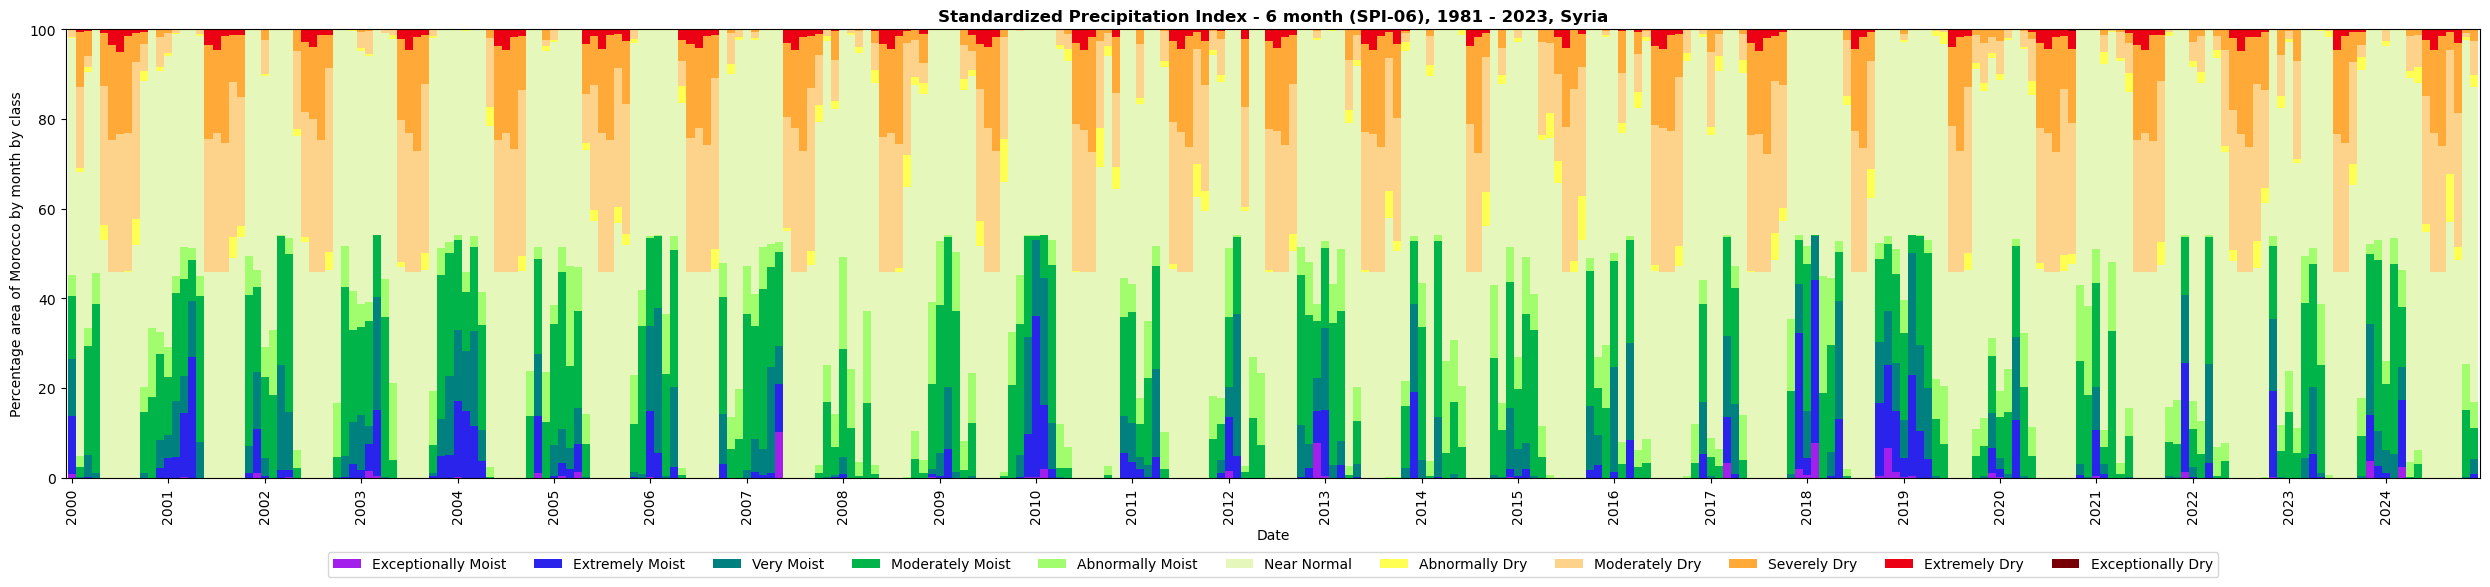

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# Load the data from the CSV file
data = pd.read_csv(r"C:\Users\ishaa\OneDrive\Desktop\DataLab\Syria\syria-economic-monitor2\syria-economic-monitor\data\mar_cli_spi_gamma_6_month.csv")

'''unique_countries = data['adm0_name'].unique()
if len(unique_countries) == 1:
    country_name = unique_countries[0]
else:
    raise ValueError("The dataset contains data for multiple countries.")
adm0_data = data[data['adm0_name'] == country_name]'''

# Define the classification bins and labels
bins = [-float('inf'), -2.00, -1.50, -1.20, -0.70, -0.50, 0.50, 0.70, 1.20, 1.50, 2.00, float('inf')]
labels = ['Exceptionally Dry', 'Extremely Dry', 'Severely Dry', 'Moderately Dry', 'Abnormally Dry', 'Near Normal', 'Abnormally Moist', 'Moderately Moist', 'Very Moist', 'Extremely Moist', 'Exceptionally Moist']
colors = ['#760005', '#ec0013', '#ffa938', '#fdd28a', '#fefe53', '#e5f7bb', '#a2fd6e', '#00b44a', '#008180', '#2a23eb', '#a21fec']

# Melt dataframe for the SPI columns into long format
spi_data = data.melt( value_vars=[col for col in data.columns if col.startswith('20')], var_name='Date', value_name='SPI')

# Drop rows with NaN values
spi_data.dropna(inplace=True)

# Classify the SPI values
spi_data['Classification'] = pd.cut(spi_data['SPI'], bins=bins, labels=labels)

# Group by Date and Classification and count
grouped = spi_data.groupby(['Date', 'Classification']).size().unstack().fillna(0)

# Convert counts to percentages
grouped_percentage = grouped.divide(grouped.sum(axis=1), axis=0) * 100

# Add missing months for the starting year
start_year = int(grouped_percentage.index[0][:4])
months_missing = int(grouped_percentage.index[0][4:6]) - 1

for i in range(months_missing, 0, -1):
    new_index = f"{start_year}{i:02}01"
    grouped_percentage.loc[new_index] = [0]*len(labels)
    
grouped_percentage.sort_index(inplace=True)

# Reverse the order of colors, bins, and labels for the desired order in the stacked chart
colors = colors[::-1]
bins = bins[::-1]
labels = labels[::-1]
grouped_percentage = grouped_percentage[labels]

# Create a stacked bar chart with increased figure width and bar width
fig, ax = plt.subplots(figsize=(25, 6))
grouped_percentage.plot(kind='bar', stacked=True, color=colors, width=1.0, ax=ax)

# Set x-ticks at the start of each year
yearly_ticks = [str(year) + '0101' for year in range(start_year, int(grouped_percentage.index[-1][:4]) + 1)]
ax.set_xticks([grouped_percentage.index.get_loc(tick) for tick in yearly_ticks])
ax.set_xticklabels([tick[:4] for tick in yearly_ticks])

# Set the y-axis limits
ax.set_ylim(0, 100)

# Plot configuration
plt.xlabel('Date')
plt.ylabel('Percentage area of Morocco by month by class')
plt.title(f'Standardized Precipitation Index - 6 month (SPI-06), 1981 - 2023, Syria',fontweight='bold')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(labels), fontsize='medium')
plt.tight_layout()

'''# Remove the space in the admin name, to make sure the image output filename doesn't have space too
filename_country = country_name.replace(" ", "")

plt.savefig(f"../SPI/mar/10_images/charts/spi_6_month_{filename_country}.png", bbox_inches="tight", dpi=300)'''

# Preview the plot
plt.show()

#### Admin 1 Level

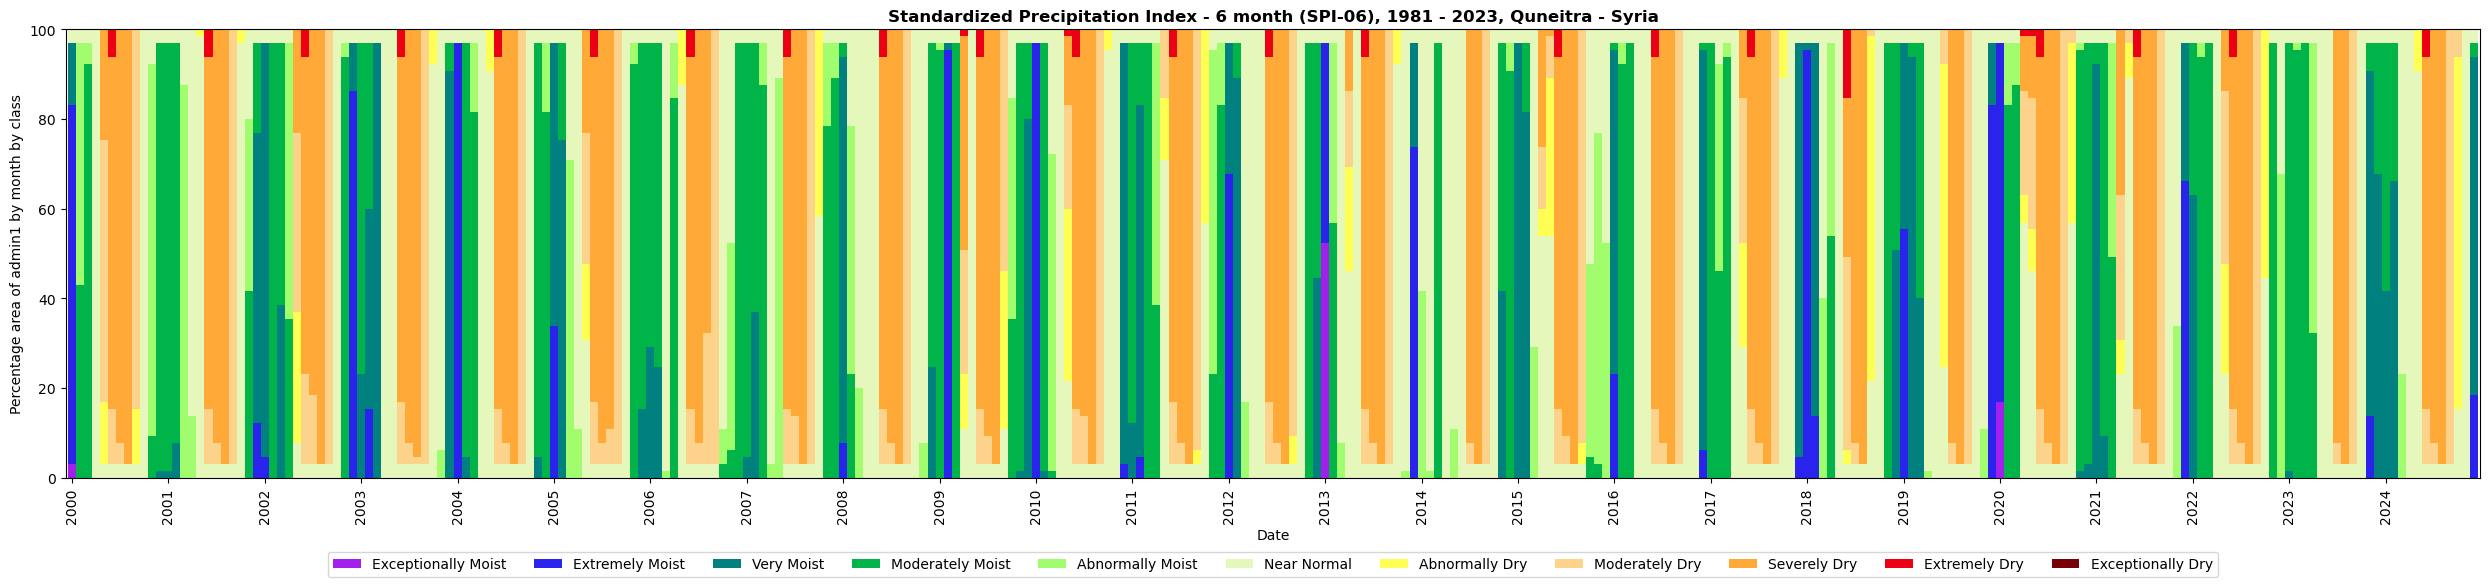

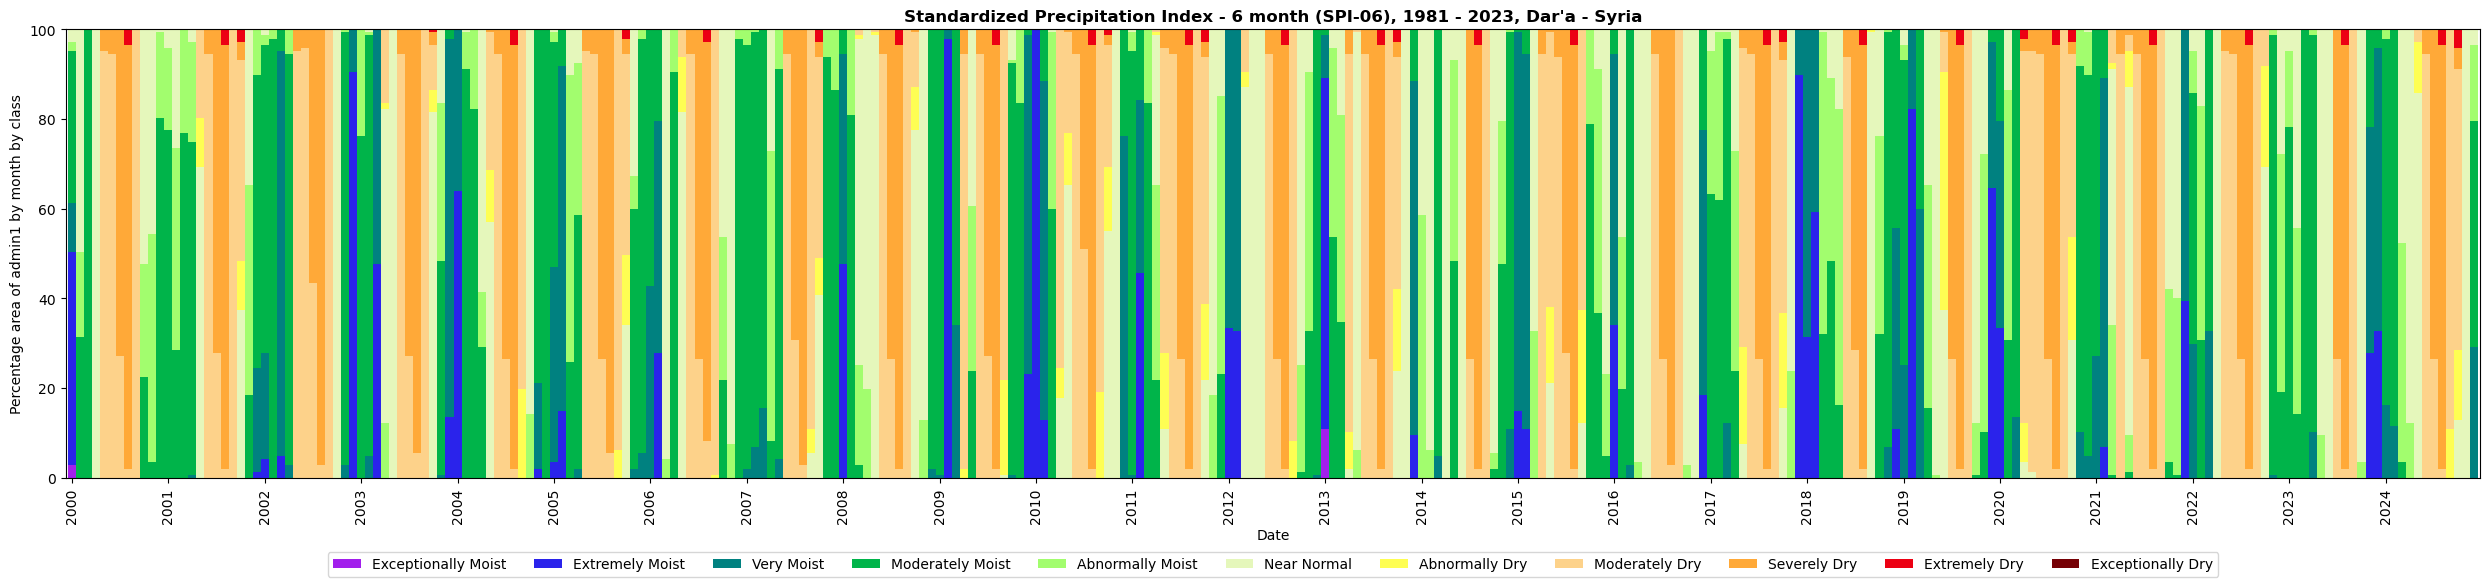

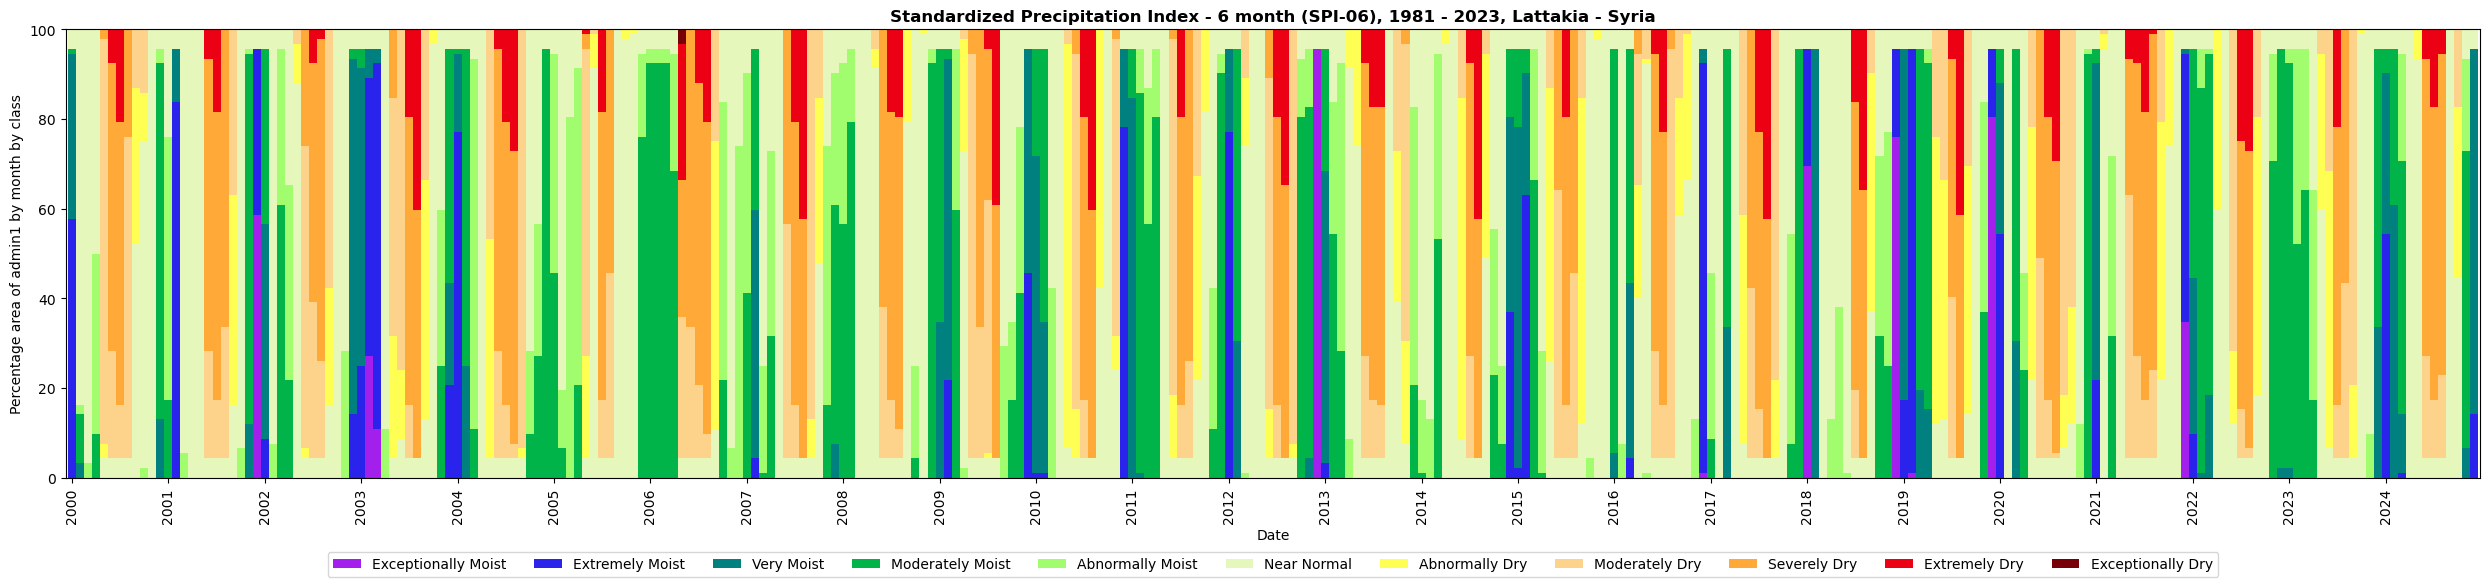

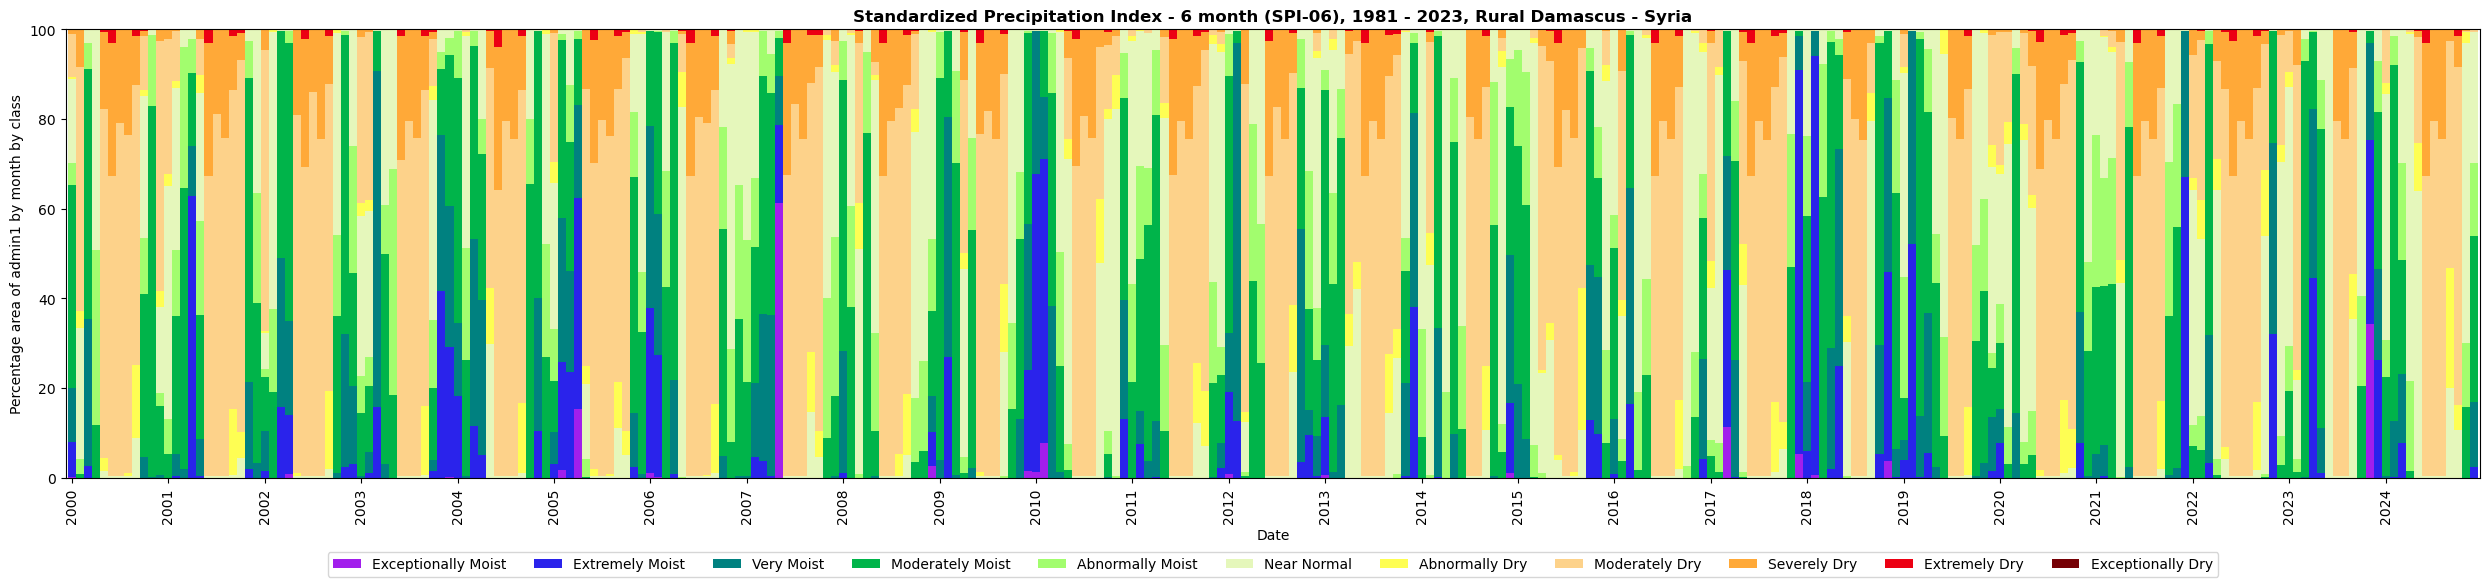

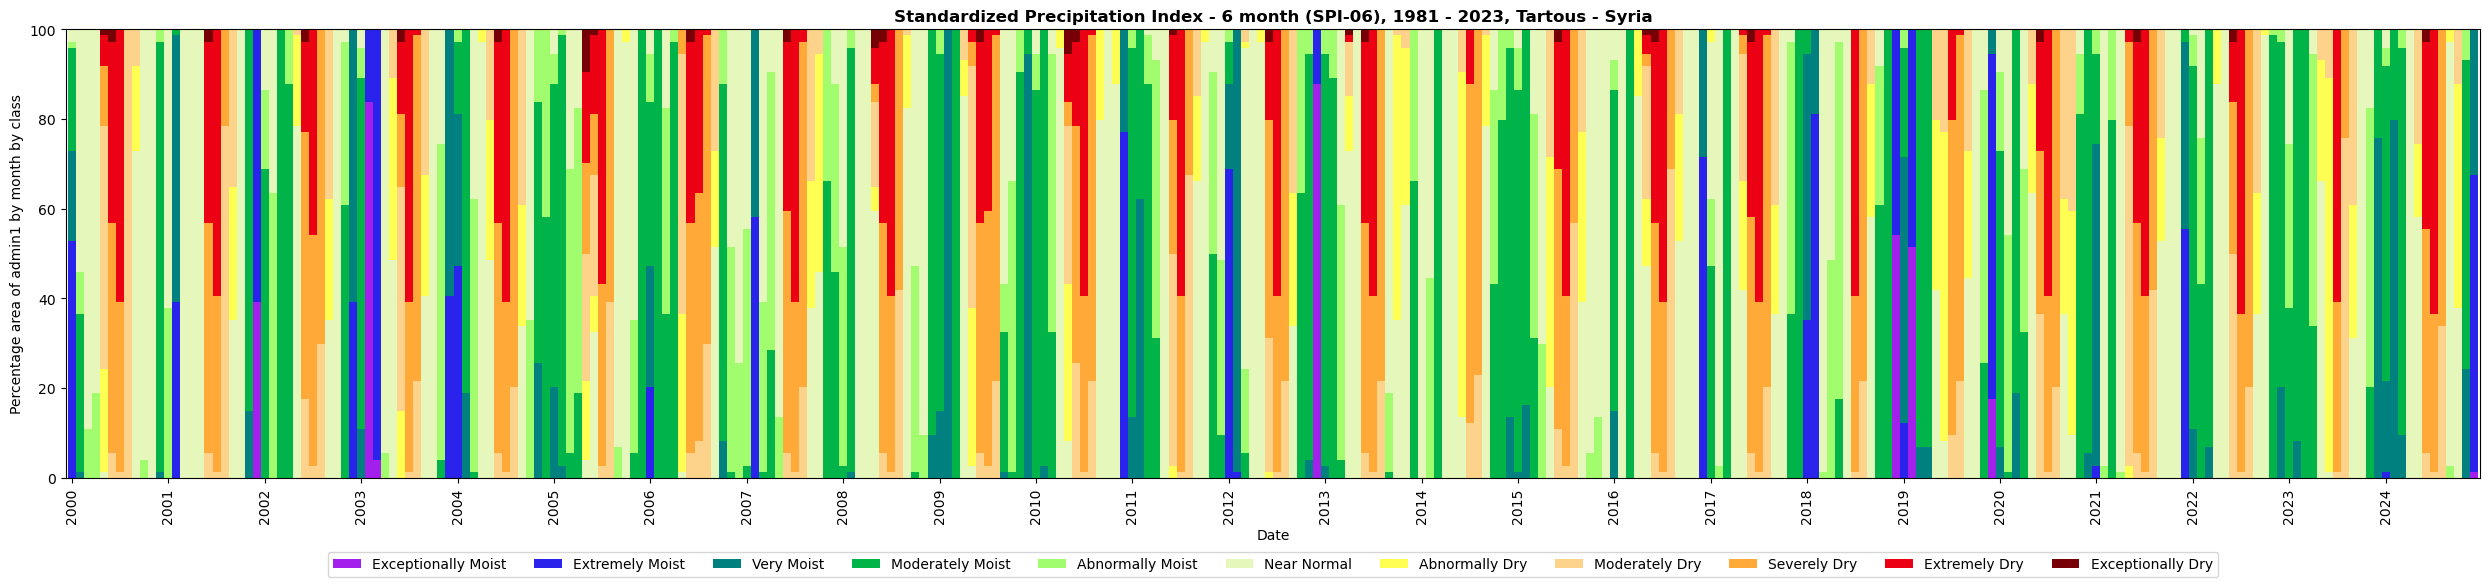

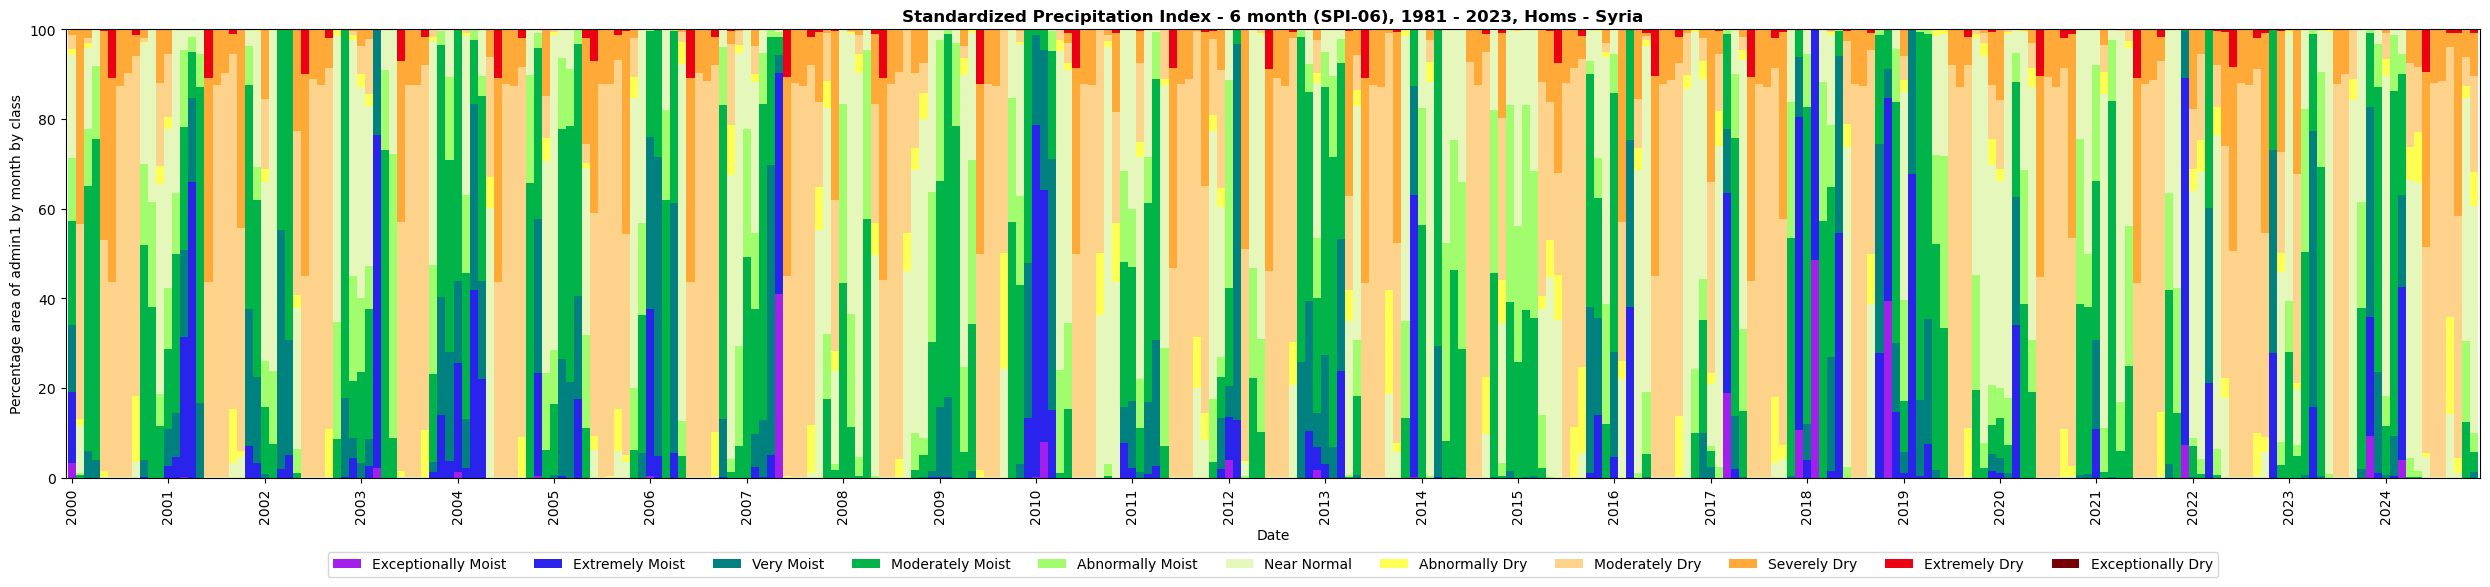

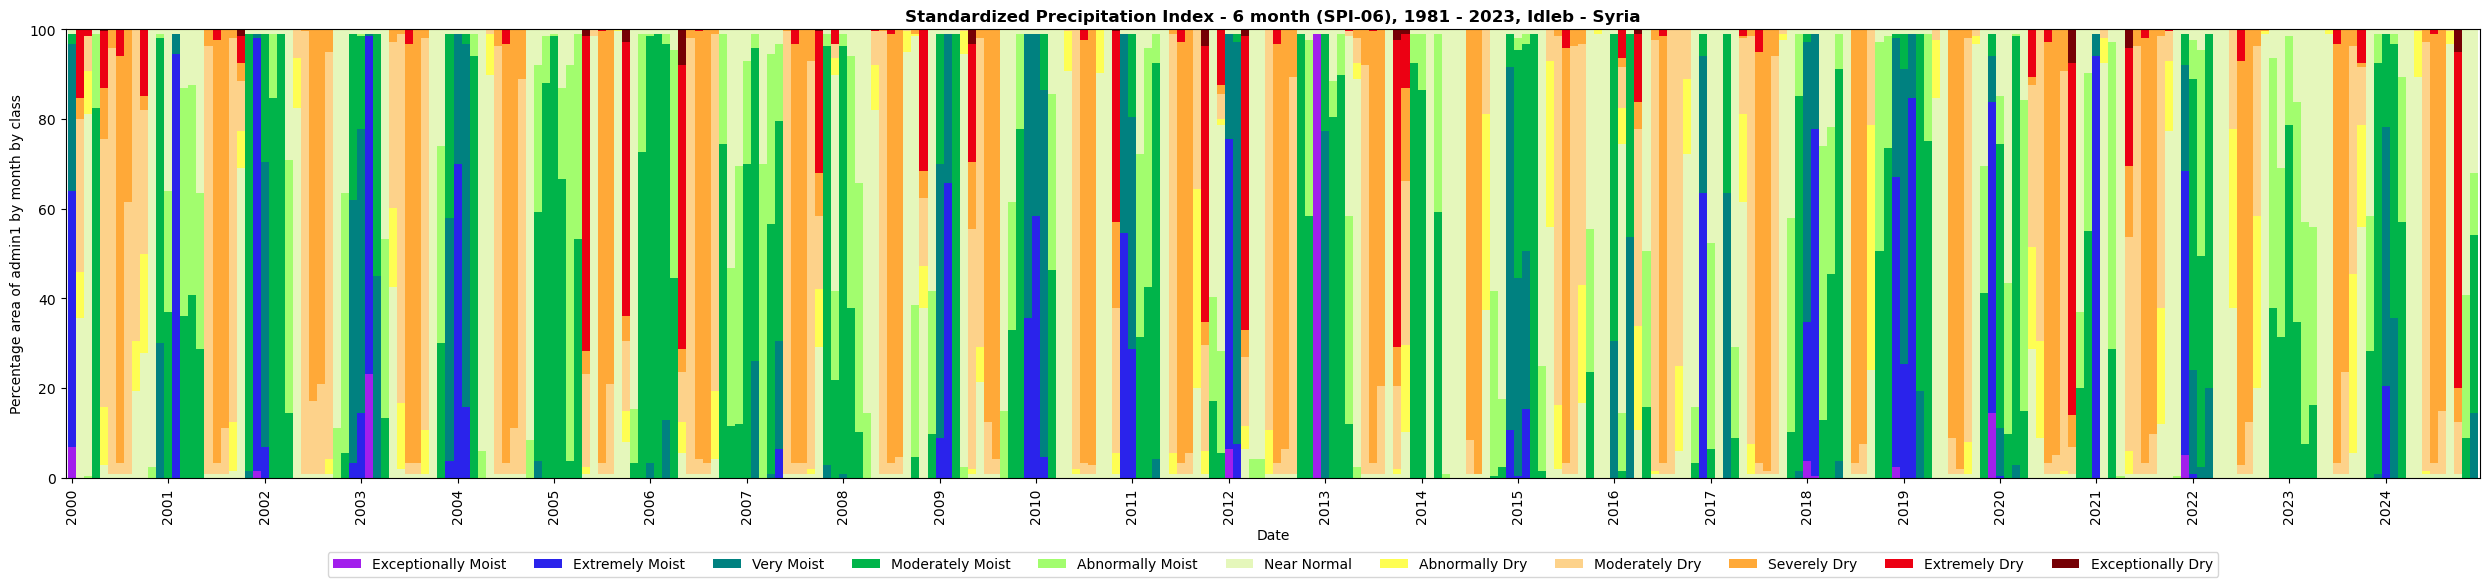

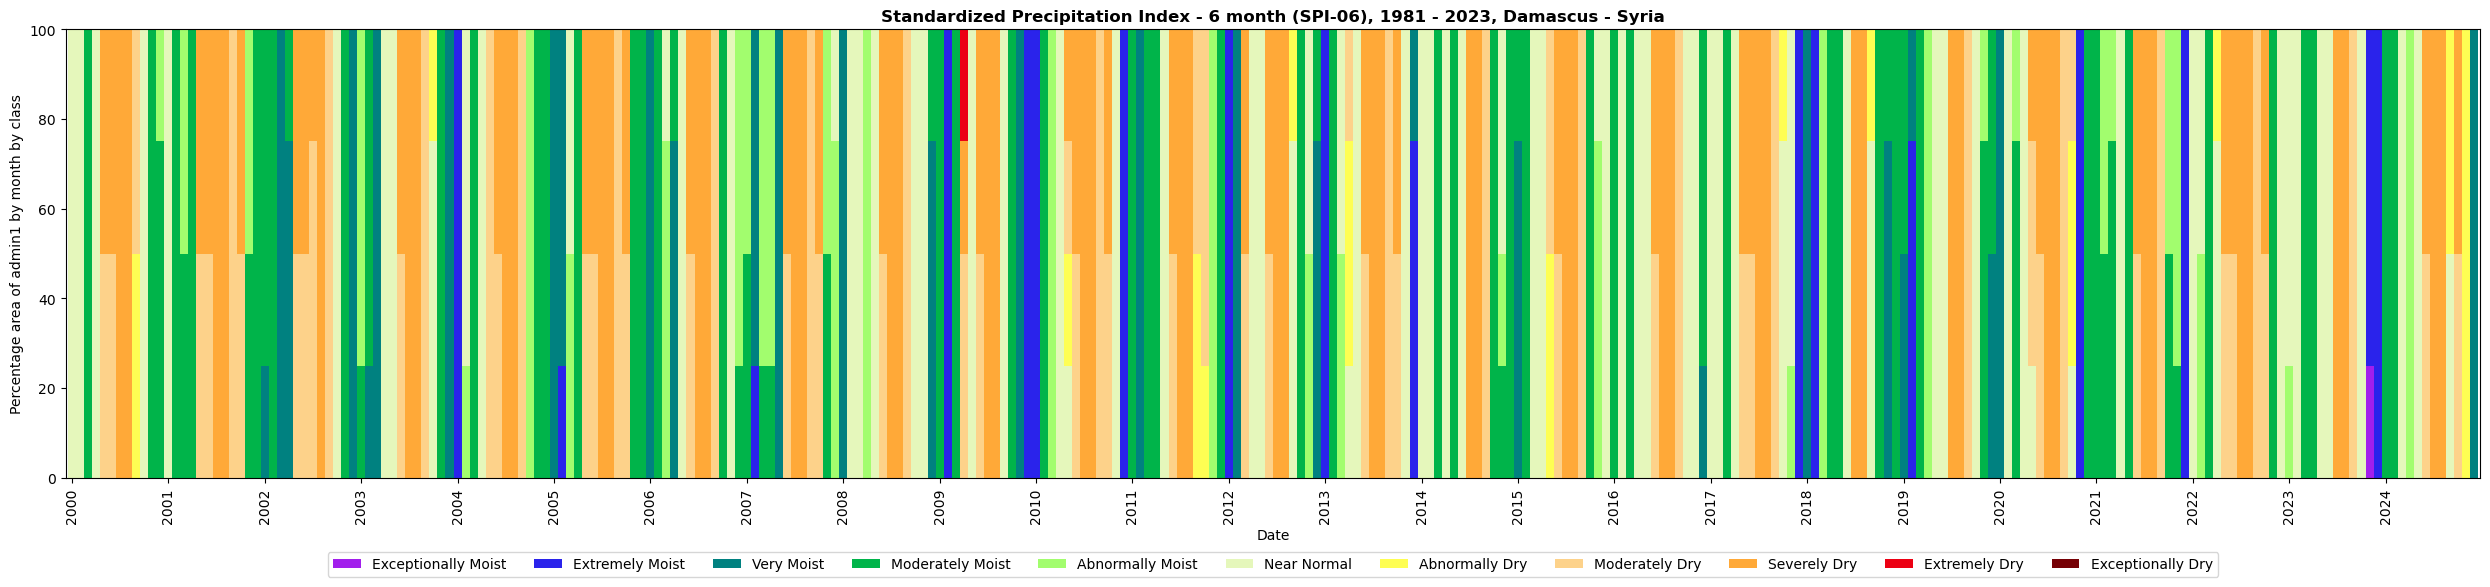

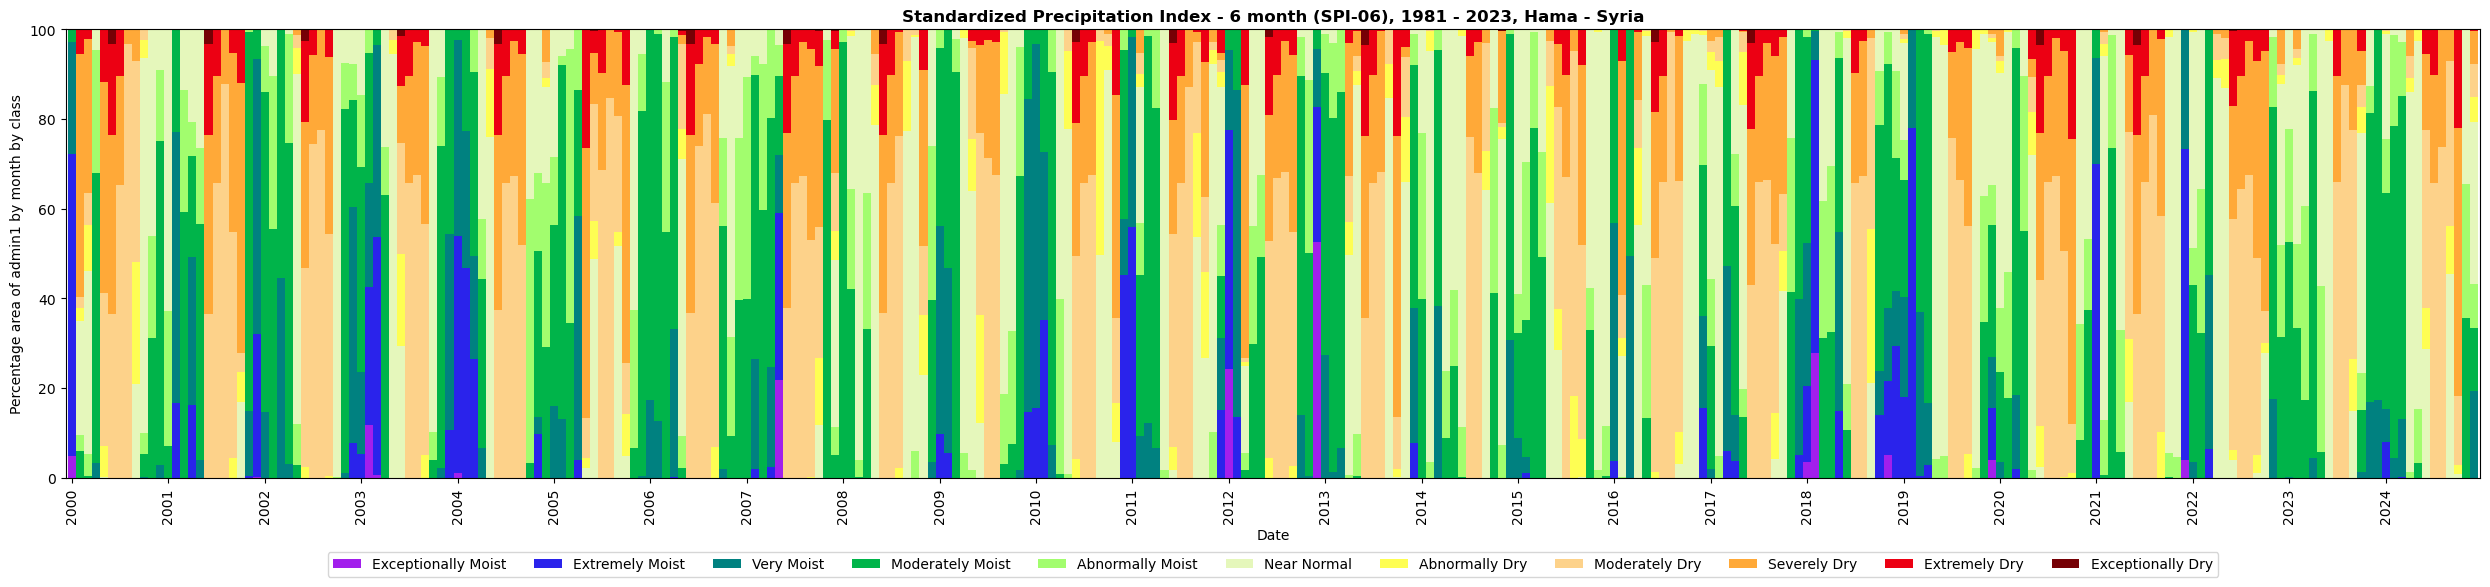

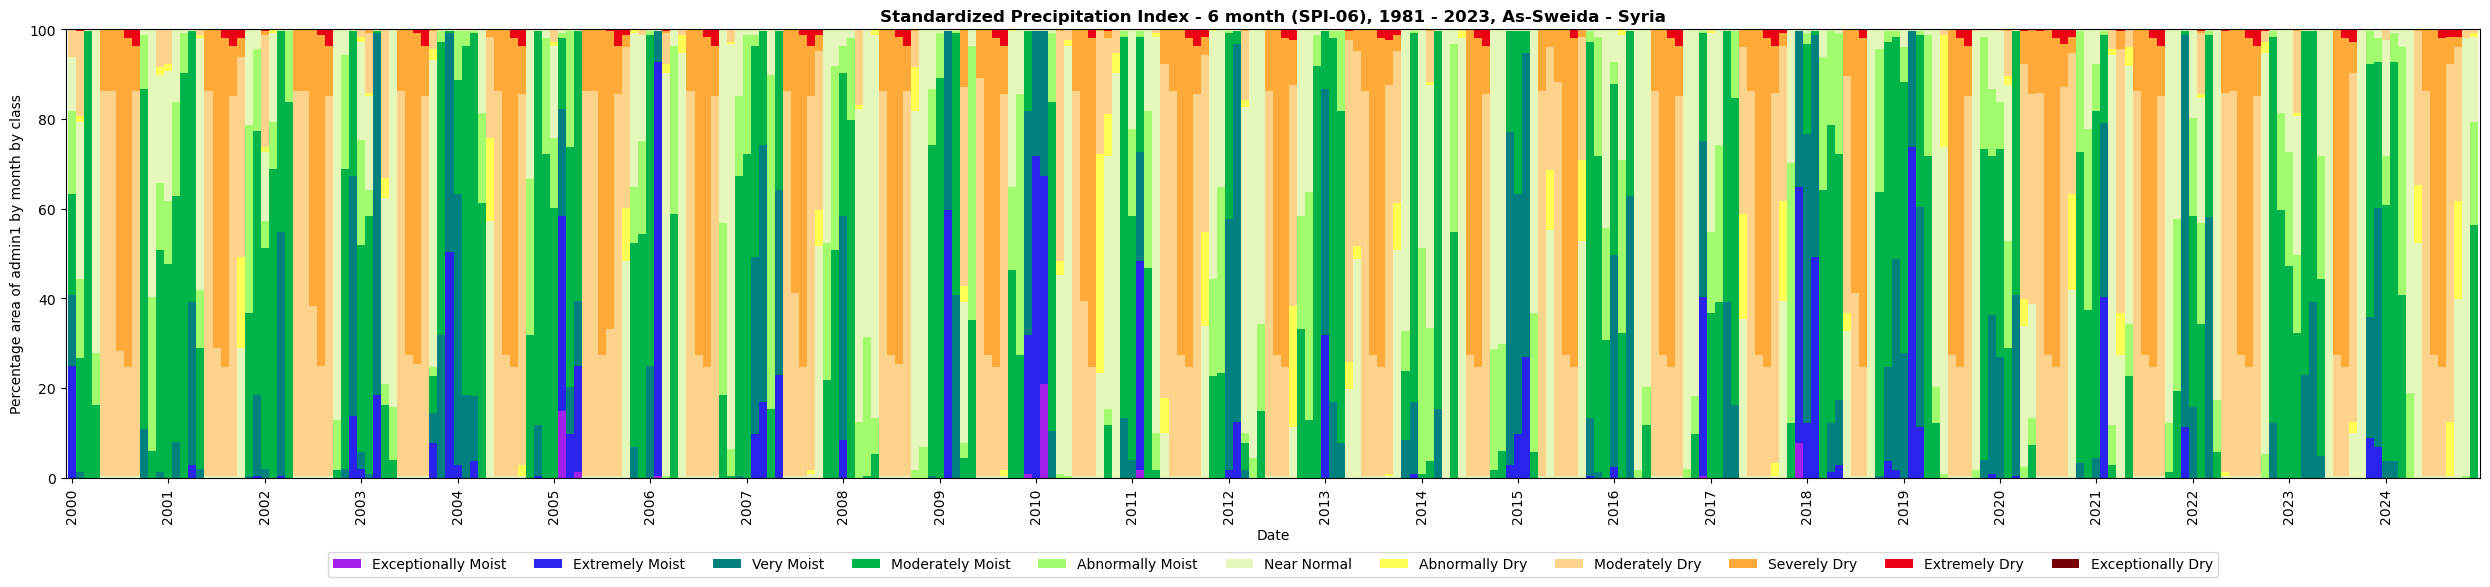

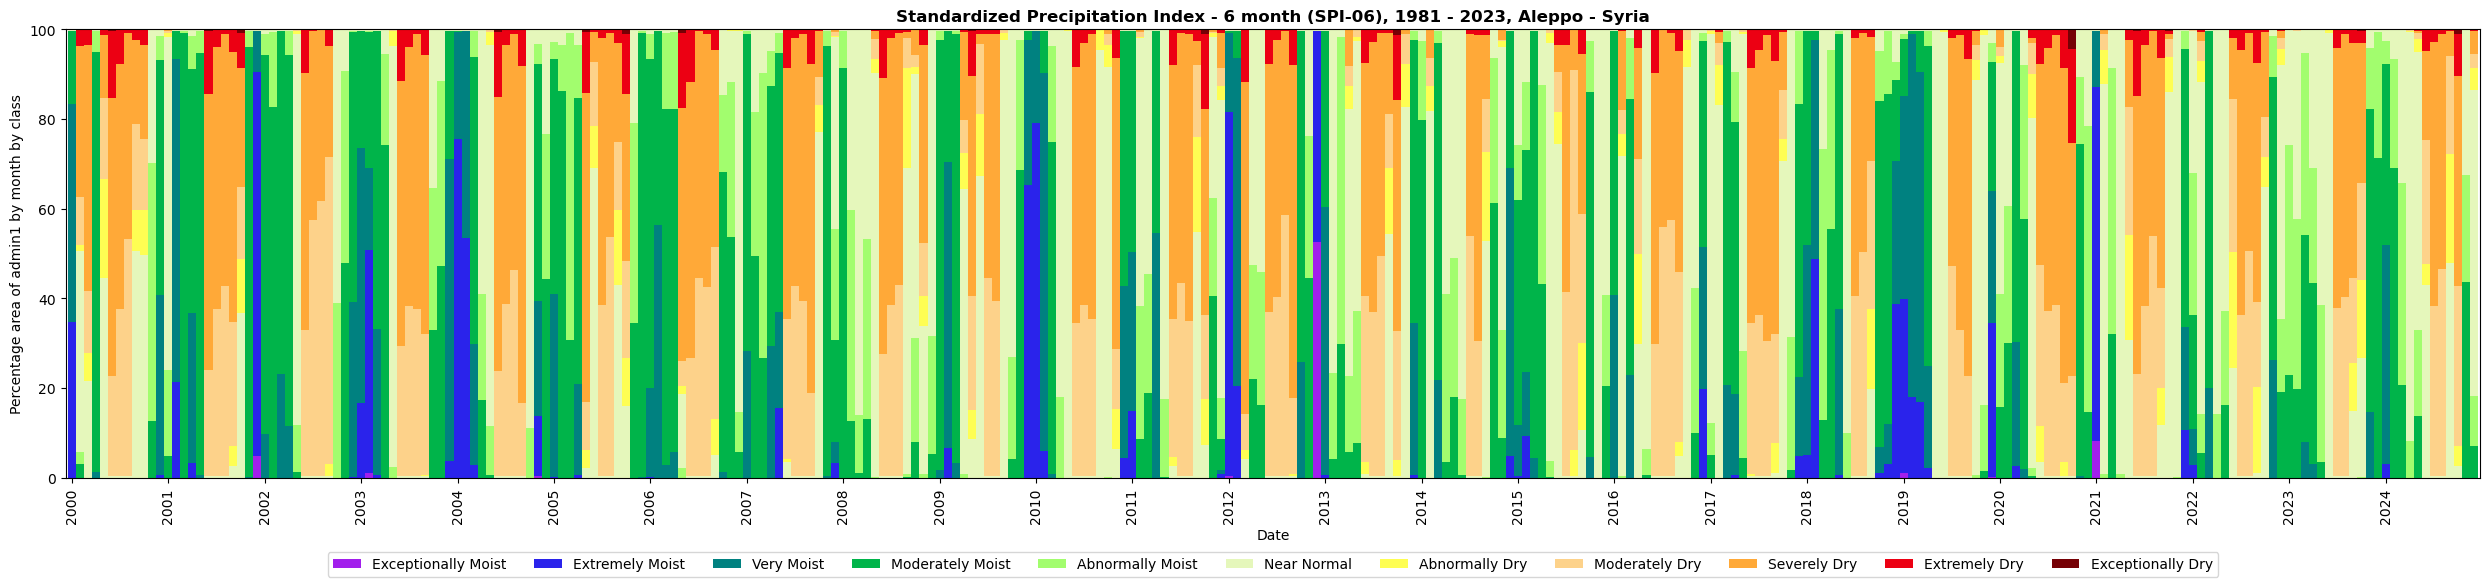

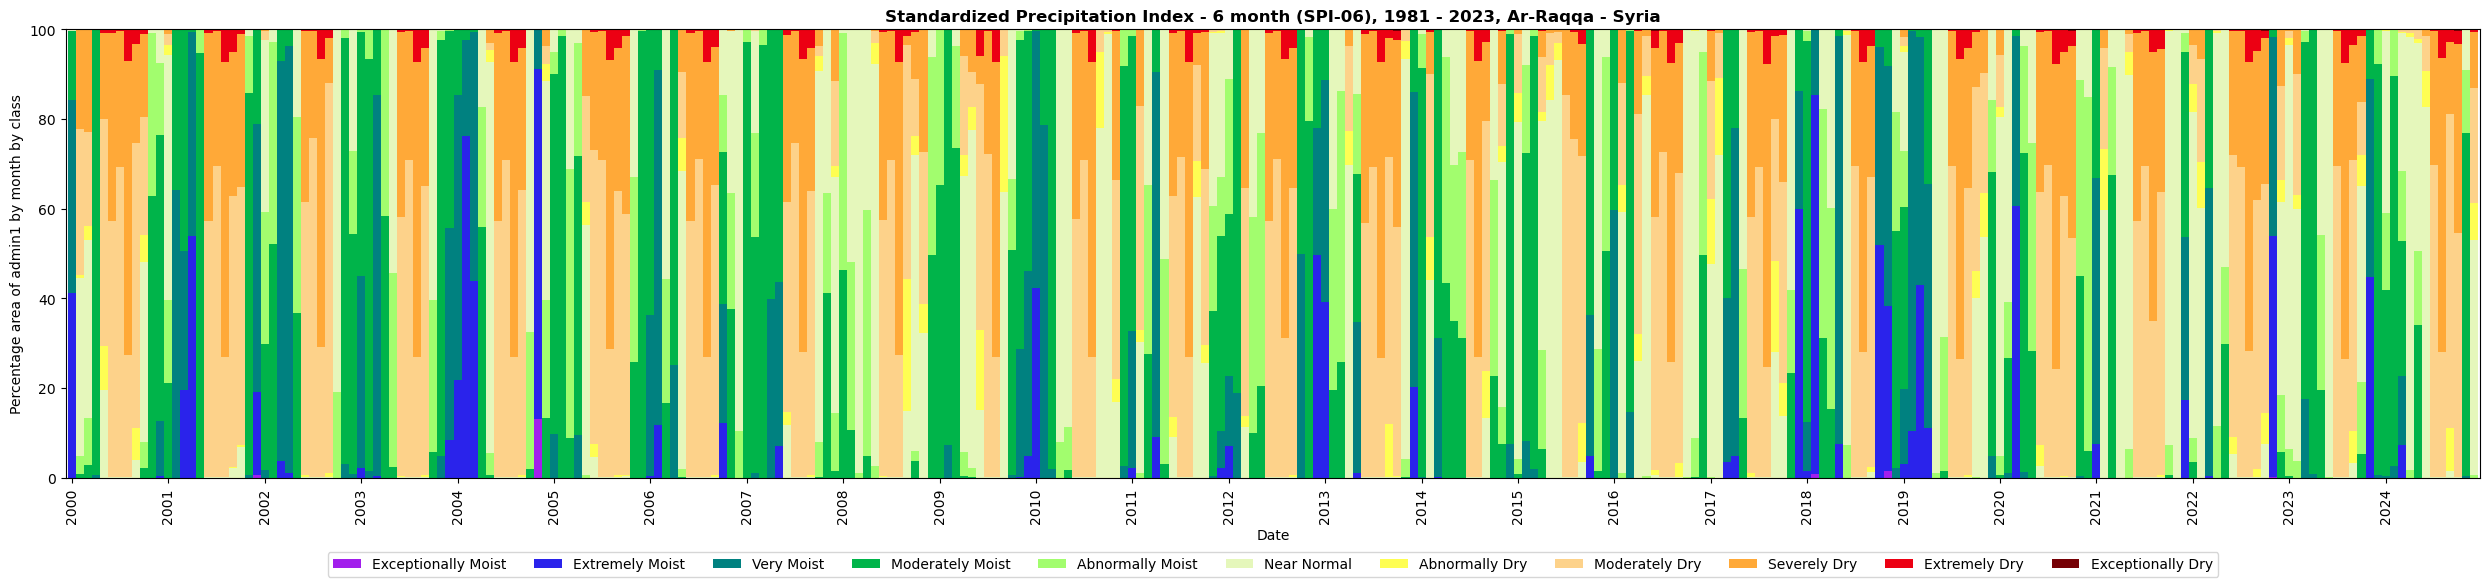

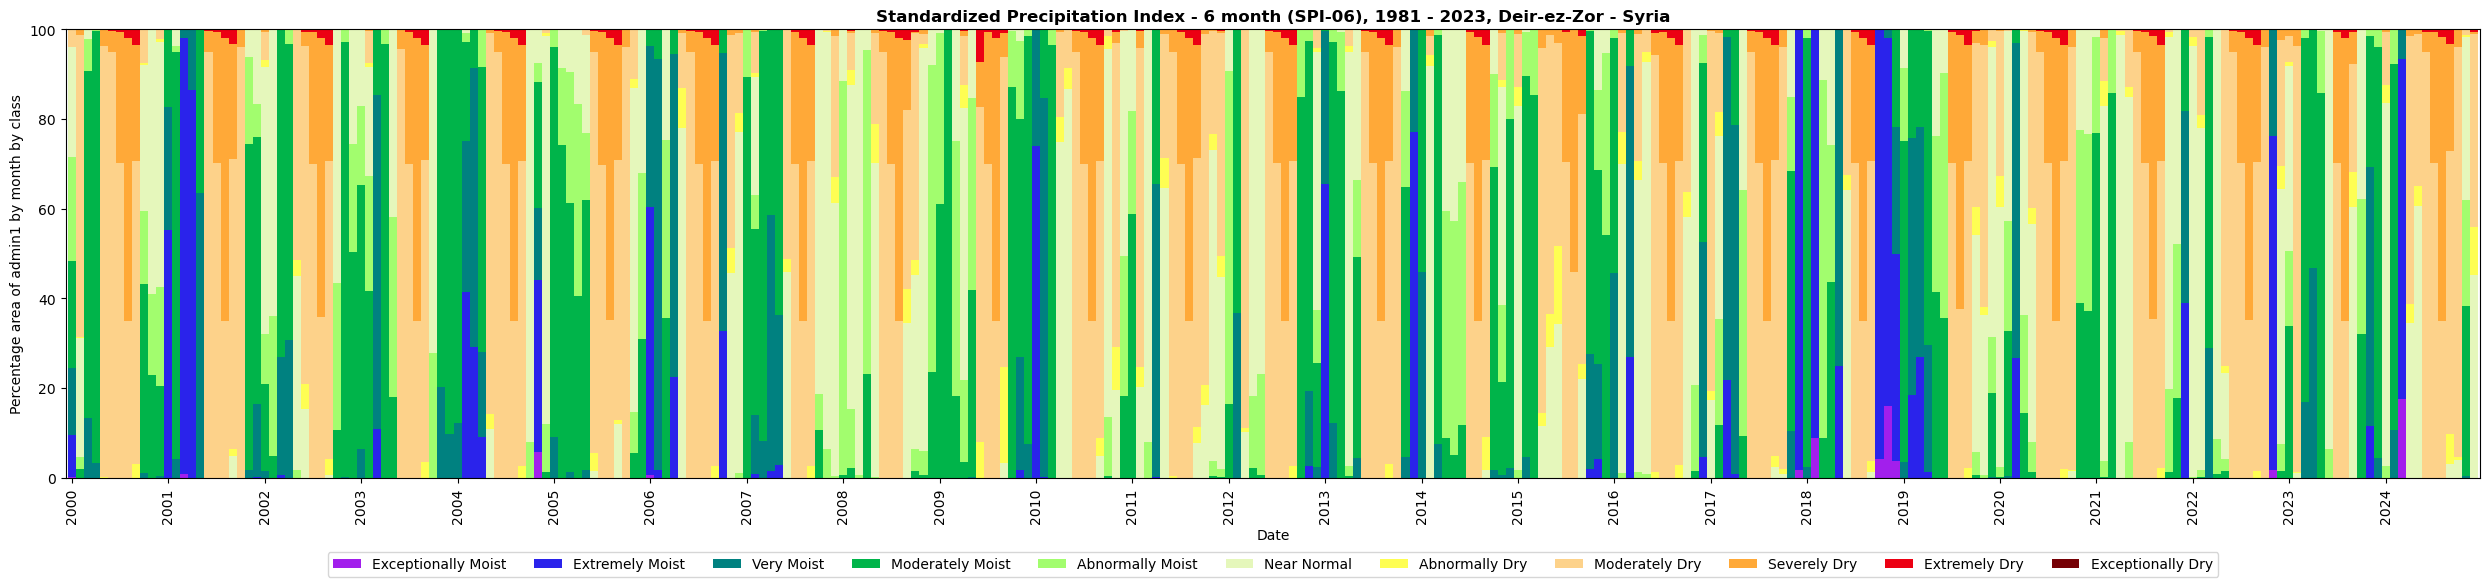

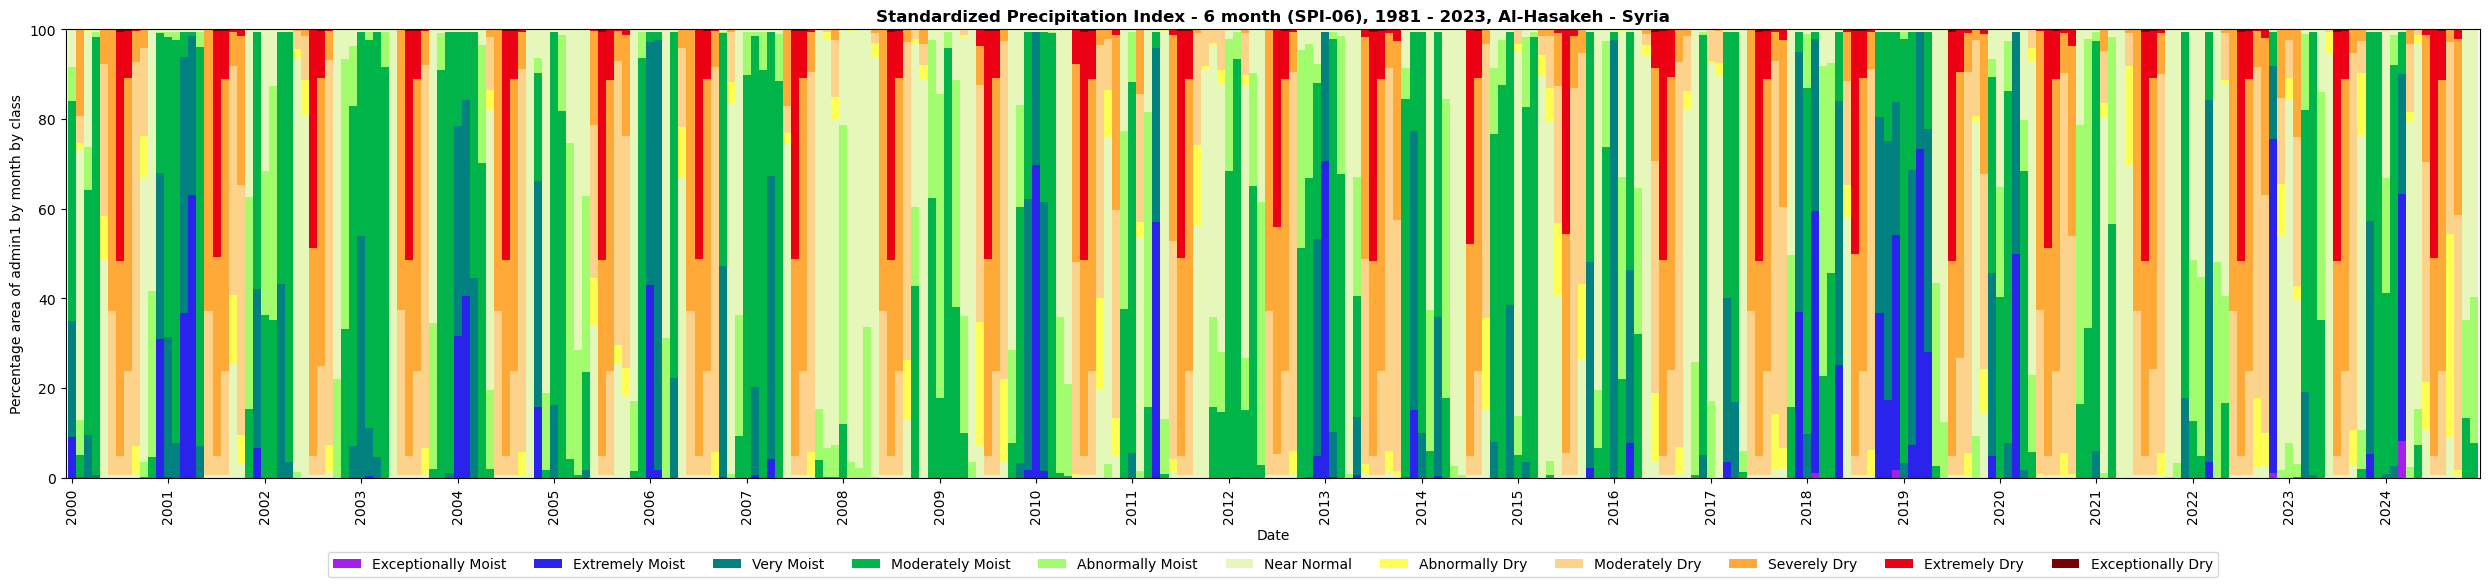

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load the data from the CSV file
data = pd.read_csv(r"C:\Users\ishaa\OneDrive\Desktop\DataLab\Syria\syria-economic-monitor2\syria-economic-monitor\data\mar_cli_spi_gamma_6_month.csv")

'''unique_countries = data['adm0_name'].unique()
if len(unique_countries) == 1:
    country_name = unique_countries[0]
else:
    raise ValueError("The dataset contains data for multiple countries.")'''

# Extract unique adm1_name values
unique_adm1 = data['ADM1_EN'].unique()

for adm1 in unique_adm1[1:]:
    adm1_data = data[(data['ADM1_EN'] == adm1)]

    # Define the classification bins and labels
    bins = [-float('inf'), -2.00, -1.50, -1.20, -0.70, -0.50, 0.50, 0.70, 1.20, 1.50, 2.00, float('inf')]
    labels = ['Exceptionally Dry', 'Extremely Dry', 'Severely Dry', 'Moderately Dry', 'Abnormally Dry', 'Near Normal', 'Abnormally Moist', 'Moderately Moist', 'Very Moist', 'Extremely Moist', 'Exceptionally Moist']
    colors = ['#760005', '#ec0013', '#ffa938', '#fdd28a', '#fefe53', '#e5f7bb', '#a2fd6e', '#00b44a', '#008180', '#2a23eb', '#a21fec']

    # Melt dataframe for the SPI columns into long format
    spi_data = adm1_data.melt(value_vars=[col for col in adm1_data.columns if col.startswith('20')], var_name='Date', value_name='SPI')

    # Drop rows with NaN values
    #spi_data.dropna(inplace=True)

    # Classify the SPI values
    spi_data['Classification'] = pd.cut(spi_data['SPI'], bins=bins, labels=labels)

    grouped = spi_data.groupby(['Date', 'Classification']).size().unstack().fillna(0)

    # Convert counts to percentages
    grouped_percentage = grouped.divide(grouped.sum(axis=1), axis=0) * 100

    '''# Add missing months for the starting year
    start_year = 20000101
    months_missing = int(grouped_percentage.index[0][4:6]) - 1

    for i in range(months_missing, 0, -1):
        new_index = f"{start_year}{i:02}01"
        grouped_percentage.loc[new_index] = [0]*len(labels)

    grouped_percentage.sort_index(inplace=True)'''

    # Reverse the order of colors, bins, and labels for the desired order in the stacked chart
    colors = colors[::-1]
    bins = bins[::-1]
    labels = labels[::-1]
    grouped_percentage = grouped_percentage[labels]

    # Create a stacked bar chart with increased figure width and bar width
    fig, ax = plt.subplots(figsize=(25, 6))
    grouped_percentage.plot(kind='bar', stacked=True, color=colors, width=1.0, ax=ax)

    # Set x-ticks at the start of each year
    yearly_ticks = [str(year) + '0101' for year in range(start_year, int(grouped_percentage.index[-1][:4]) + 1)]
    ax.set_xticks([grouped_percentage.index.get_loc(tick) for tick in yearly_ticks])
    ax.set_xticklabels([tick[:4] for tick in yearly_ticks])

    # Set the y-axis limits
    ax.set_ylim(0, 100)

    # Plot configuration
    plt.xlabel('Date')
    plt.ylabel('Percentage area of admin1 by month by class')

    # Change this line to use both adm1 and country_name
    plt.title(f'Standardized Precipitation Index - 6 month (SPI-06), 1981 - 2023, {adm1} - Syria',fontweight='bold')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(labels), fontsize='medium')
    plt.tight_layout()
    

In [ ]:
p = gdf_adm1.groupby(['adm1_name', 'class_type', 'time']).sum().reset_index()
p['percentage_area'] = 100*p['class_area']/p['adm_area']
p = p.groupby(['adm1_name', 'class_type', pd.Grouper(key='time', freq='Y')]).max().reset_index()
p = morocco_adm1[['adm1_name', 'geometry']].merge(p)
p = geopandas.GeoDataFrame(p, geometry='geometry')

fig, ax = plt.subplots(4,3, figsize=(10,10), sharex=True, sharey=True)

plots = []
for i, year in enumerate([1981, 2009, 2016, 2022]):
    p1 = p[p['time'].dt.year==year]
    ax[i][0].text(-0.2, 0.5, year, va='center', ha='center', fontsize=12,  transform=ax[i][0].transAxes,)
    for idx, class_type in enumerate(['Dry Classes', 'Moist Classes', 'Normal']):
        p2 = p1[p1['class_type']==class_type]
        plot = p2.plot(column='percentage_area',ax=ax[i][idx], cmap = cmap[idx], vmin=0, vmax=50)
        ax[i][idx].axis('off')
        plots.append(plot)
        ax[0][idx].set_title(class_type)
        #ax[idx][0].set_title(year)
    
    

cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Adjust the position as needed
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=50))
sm.set_array([])  # Fake empty array for the colorbar
cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Percentage Area')

plt.subplots_adjust(wspace=0.00005, hspace=0.005)

fig.suptitle('Maximum Percentage Area in SPI 6 month Drought Classes in a year by Adm1 Regions')